# Assignment - 3 (Natural Language Processing)

### Team Members :-
1. Donal Loitam (AI21BTECH11009)
2. Iragavarapu Sai Pradeep (AI21BTECH11013)
3. Suraj Kumar (AI21BTECH11029)

### **Project Setup & Overview**
**Title:** Pedagogical Ability Assessment of AI Tutors (Problem 2)

**Dataset:** MathDial/Bridge dataset containing tutor-student dialogues (JSON format).

##### Tasks:
- Mistake Identification (Yes/To some extent/No)
- Mistake Location (Yes/To some extent/No)
- Pedagogical Guidance (Yes/To some extent/No)
- Actionability (Yes/To some extent/No)

**Evaluation Metrics**: Exact Accuracy, Exact Macro F1, Lenient Accuracy, Lenient Macro F1 for each task.



In [27]:
# Uncomment the below line to install these if not already

%pip install transformers datasets scikit-learn pandas torch seaborn matplotlib nltk tqdm

Note: you may need to restart the kernel to use updated packages.


In [28]:
# --- Standard Libraries ---
import json
import os
import random
import string
import re
import traceback

# --- Data Handling ---
import pandas as pd
import numpy as np

# --- Machine Learning & NLP ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# PyTorch for modeling
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Hugging Face Transformers for models and tokenizers
import transformers
from transformers import AutoTokenizer, AutoModel # Base classes, specific models loaded later

# --- Visualization --
import matplotlib.pyplot as plt
import seaborn as sns

# --- NLTK (Optional, for Stopwords) ---
import nltk
try:
    from nltk.corpus import stopwords
    stopwords.words('english') # Check if already downloaded
except LookupError:
    print("NLTK stopwords not found. Downloading...")
    nltk.download('stopwords')
    from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))



# ---------------- Configuration & Constants -------------------------------
# Seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# --- Paths ---
DATA_PATH = 'assignment_3_ai_tutors_dataset.json'
OUTPUT_DIR = './results' # Directory to save models, logs, etc.
os.makedirs(OUTPUT_DIR, exist_ok=True) # Create output dir if it doesn't exist

# --- Device Setup ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# --- Experiment Parameters ---
BASE_MODELS_TO_TRY = ['distilbert-base-uncased', 'bert-base-uncased', 'roberta-base']
PREPROCESSING_OPTIONS = {
    'remove_punct': [False],
    'remove_stopwords': [False],
    'include_history': [True, False] # Try with and without conversation history
}
TASK_STRATEGIES = ['single_task', 'multi_task']
LOSS_FUNCTIONS_TO_TRY = ['CrossEntropyLoss', 'WeightedCrossEntropyLoss', 'FocalLoss']

# --- Model Hyperparameters (can be tuned) ---
MAX_LENGTH = 384  # Max sequence length for tokenizer (adjust based on EDA)
BATCH_SIZE = 16    # Adjust based on GPU memory
EPOCHS = 5        # Number of training epochs
LEARNING_RATE = 2e-5 # Common learning rate for fine-tuning transformers

# --- Label Mapping ---
LABEL_MAP = {"Yes": 0, "To some extent": 1, "No": 2}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
NUM_CLASSES = len(LABEL_MAP)

# Task names mapping to keys expected in the dataset's annotation dictionary
TASK_KEYS = {
    "Mistake_Identification": "Mistake_Identification", # Column name : JSON Key
    "Mistake_Location": "Mistake_Location",
    "Providing_Guidance": "Providing_Guidance", # Note the different key name
    "Actionability": "Actionability"
}

TASK_LIST = list(TASK_KEYS.keys())

print("Setup Complete.")

Using device: cuda
Setup Complete.


### **Data Loading**
The following cell defines a function load_data to read the dataset from the specified JSON file (DATA_PATH).

It parses the nested structure, extracts the relevant fields (conversation history, tutor response, and the four pedagogical annotations), maps the text labels ("Yes", "To some extent", "No") to integers (0, 1, 2 respectively), and organizes everything into a Pandas DataFrame.

Each row in the resulting DataFrame will represent a single tutor response instance ready for analysis.

In [29]:
def load_data(file_path):
    """
    Loads and parses the dataset from a JSON file based on the user-provided structure.

    Args:
        file_path (str): The path to the JSON dataset file.

    Returns:
        pandas.DataFrame: A Df where each row corresponds to a single
                          tutor response instance, including context and labels.
                          Returns None if the file cannot be loaded or parsed.

    Expected JSON Structure :
    [
        {
            "conversation_id": "...",
            "conversation_history": "...",
            "tutor_responses": {  <--- This is a DICTIONARY
                "Tutor Name/ID 1": {
                    "response": "...",
                    "annotation": {
                        "Mistake_Identification": "Yes" | "To some extent" | "No",
                        "Mistake_Location": "Yes" | "To some extent" | "No",
                        "Providing_Guidance": "Yes" | "To some extent" | "No",
                        "Actionability": "Yes" | "To some extent" | "No"
                    }
                },
                "Tutor Name/ID 2": { ... },
                ...
            }
        },
        ... // More conversations
    ]
    """
    data_rows = []
    # Check if file exists before trying to open
    if not os.path.exists(file_path):
        print(f"Error: Dataset file not found at {file_path}")
        return None

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            dataset = json.load(f)

        if not isinstance(dataset, list):
            print(f"Error: Expected a list of conversations in JSON, but got type {type(dataset)}. Check JSON structure.")
            return None

        for i, conversation in enumerate(dataset):

            conv_id = conversation.get("conversation_id", f"N/A_{i}")
            history = conversation.get("conversation_history", "")

            tutor_responses_dict = conversation.get("tutor_responses", {})

            for tutor_name, tutor_data in tutor_responses_dict.items():

                response_text = tutor_data.get("response", "")
                annotations = tutor_data.get("annotation", {})

                labels = {}
                valid_entry = True
                for df_col_name, json_key in TASK_KEYS.items():
                    label_text = annotations.get(json_key)
                    if label_text in LABEL_MAP:
                        labels[df_col_name] = LABEL_MAP[label_text]
                    else:
                        print(f"Warning: Invalid or missing label '{label_text}' for annotation key '{json_key}' in conv {conv_id}, tutor {tutor_name}. Skipping response.")
                        valid_entry = False
                        break # Skip this response if any label is invalid/missing

                if valid_entry:
                    data_rows.append({
                        "conversation_id": conv_id,
                        "conversation_history": history,
                        "tutor": tutor_name,
                        "response": response_text,
                        **labels # Unpack the label dictionary (e.g., "Mistake_Identification": 0, ...)
                    })

        if not data_rows:
             print(f"Warning: No valid data rows extracted from {file_path} after processing. Check file structure, content, and warnings.")
             df_columns = ["conversation_id", "conversation_history", "tutor", "response"] + TASK_LIST
             return pd.DataFrame(columns=df_columns)


        df = pd.DataFrame(data_rows)
        ordered_columns = ["conversation_id", "conversation_history", "tutor", "response"] + TASK_LIST
        df = df[ordered_columns]
        return df

    except json.JSONDecodeError as e:
        print(f"Error: Could not decode JSON from {file_path}. Check file format. Details: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}")
        traceback.print_exc()
        return None


# Check if DATA_PATH is defined and points to a file
if 'DATA_PATH' in locals() and DATA_PATH and os.path.exists(DATA_PATH):
    print(f"Attempting to load data from: {DATA_PATH}")
    df_raw = load_data(DATA_PATH)
elif 'DATA_PATH' in locals():
     print(f"Error: DATA_PATH ('{DATA_PATH}') is defined but does not exist. Please correct the path.")
     df_raw = None
else:
     print("Error: DATA_PATH is not defined. Please define it in the setup cell (Cell 2).")
     df_raw = None


# --- Display basic info ---
if df_raw is not None and not df_raw.empty:
    print(f"\nData loaded successfully using updated function. Shape: {df_raw.shape}")
    print("\nDataFrame Info:")
    df_raw.info()
    print("\nMissing values per column:")
    print(df_raw.isnull().sum())
    print("\nDataFrame Columns:", df_raw.columns.tolist())
elif df_raw is not None and df_raw.empty:
    print("\nData loading function ran, but returned an empty DataFrame. Check warnings and JSON content.")
else:
    print("\nData loading failed. Please check the DATA_PATH, file integrity, and error messages above.")



Attempting to load data from: assignment_3_ai_tutors_dataset.json

Data loaded successfully using updated function. Shape: (2476, 8)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2476 entries, 0 to 2475
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   conversation_id         2476 non-null   object
 1   conversation_history    2476 non-null   object
 2   tutor                   2476 non-null   object
 3   response                2476 non-null   object
 4   Mistake_Identification  2476 non-null   int64 
 5   Mistake_Location        2476 non-null   int64 
 6   Providing_Guidance      2476 non-null   int64 
 7   Actionability           2476 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 154.9+ KB

Missing values per column:
conversation_id           0
conversation_history      0
tutor                     0
response                  0
Mistake_Identification    0
Mist

In [30]:
print("First 10 rows of the df \n")
df_raw.head(10)

First 10 rows of the df 



conversation_id  \
0   221-362eb11a-f190-42a6-b2a4-985fafdcfa9e   
1   221-362eb11a-f190-42a6-b2a4-985fafdcfa9e   
2   221-362eb11a-f190-42a6-b2a4-985fafdcfa9e   
3   221-362eb11a-f190-42a6-b2a4-985fafdcfa9e   
4   221-362eb11a-f190-42a6-b2a4-985fafdcfa9e   
5   221-362eb11a-f190-42a6-b2a4-985fafdcfa9e   
6   221-362eb11a-f190-42a6-b2a4-985fafdcfa9e   
7   221-362eb11a-f190-42a6-b2a4-985fafdcfa9e   
8  4642-e2ccfa55-280b-421c-9245-25ff56e3f33e   
9  4642-e2ccfa55-280b-421c-9245-25ff56e3f33e   

                                conversation_history        tutor  \
0  Tutor: Hi, could you please provide a step-by-...       Sonnet   
1  Tutor: Hi, could you please provide a step-by-...    Llama318B   
2  Tutor: Hi, could you please provide a step-by-...  Llama31405B   
3  Tutor: Hi, could you please provide a step-by-...         GPT4   
4  Tutor: Hi, could you please provide a step-by-...      Mistral   
5  Tutor: Hi, could you please provide a step-by-...       Expert   
6  Tutor: Hi, could you please provide a step-by-...       Gemini   
7  Tutor: Hi, could you please provide a step-by-...         Phi3   
8  Tutor: Hi, could you please provide a step-by-...         GPT4   
9  Tutor: Hi, could you please provide a step-by-...       Sonnet   

                                            response  Mistake_Identification  \
0  Great, you've correctly identified the cost of...                       0   
1  Now that we know the cost of 1 pound of meat i...                       0   
2  You're close, but I notice that you calculated...                       0   
3  That's correct. So, if 1 pound of meat costs $...                       0   
4  It seems like you've calculated the cost as if...                       0   
5  And if there are 5 sandwiches, what is the mea...                       0   
6  You're absolutely right about the cost of meat...                       0   
7  To find the area of a rectangle, multiply its ...                       2   
8  You're doing great! But remember, the 20% incr...                       0   
9  I see where you're going with this, but let's ...                       1   

   Mistake_Location  Providing_Guidance  Actionability  
0                 0                   0              0  
1                 1                   1              1  
2                 0                   0              0  
3                 0                   0              0  
4                 0                   0              0  
5                 0                   0              0  
6                 1                   1              1  
7                 2                   1              2  
8                 0                   0              0  
9                 2                   2              1

### **Exploratory Data Analysis (EDA)**
This section performs Exploratory Data Analysis (EDA) to:

- **Analyze Label Distributions**: Check the frequency of each label ("Yes", "To some extent", "No") for all four tasks. This helps identify class imbalance, which might require special handling (e.g., weighted loss functions, specific sampling strategies).

- **Analyze Text Lengths**: Examine the distribution of lengths for response_text and history. This informs the choice of MAX_LENGTH for the tokenizer to balance capturing context and computational efficiency/memory usage

--- Starting Exploratory Data Analysis ---

--- Label Distributions ---


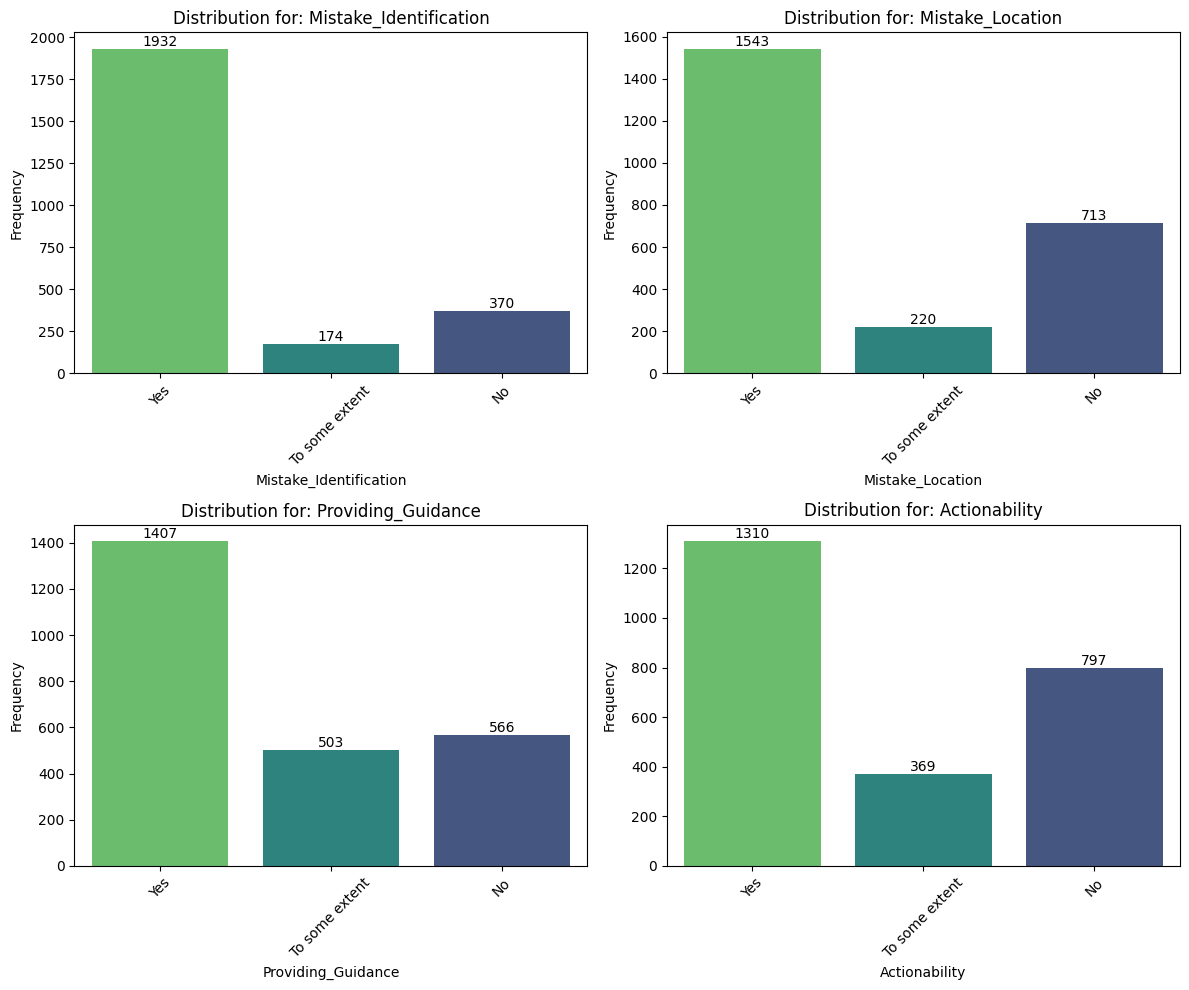


Value Counts for Mistake_Identification:
Mistake_Identification
Yes               1932
No                 370
To some extent     174
Name: count, dtype: int64

Value Counts for Mistake_Location:
Mistake_Location
Yes               1543
No                 713
To some extent     220
Name: count, dtype: int64

Value Counts for Providing_Guidance:
Providing_Guidance
Yes               1407
No                 566
To some extent     503
Name: count, dtype: int64

Value Counts for Actionability:
Actionability
Yes               1310
No                 797
To some extent     369
Name: count, dtype: int64

--- Text Length Analysis ---


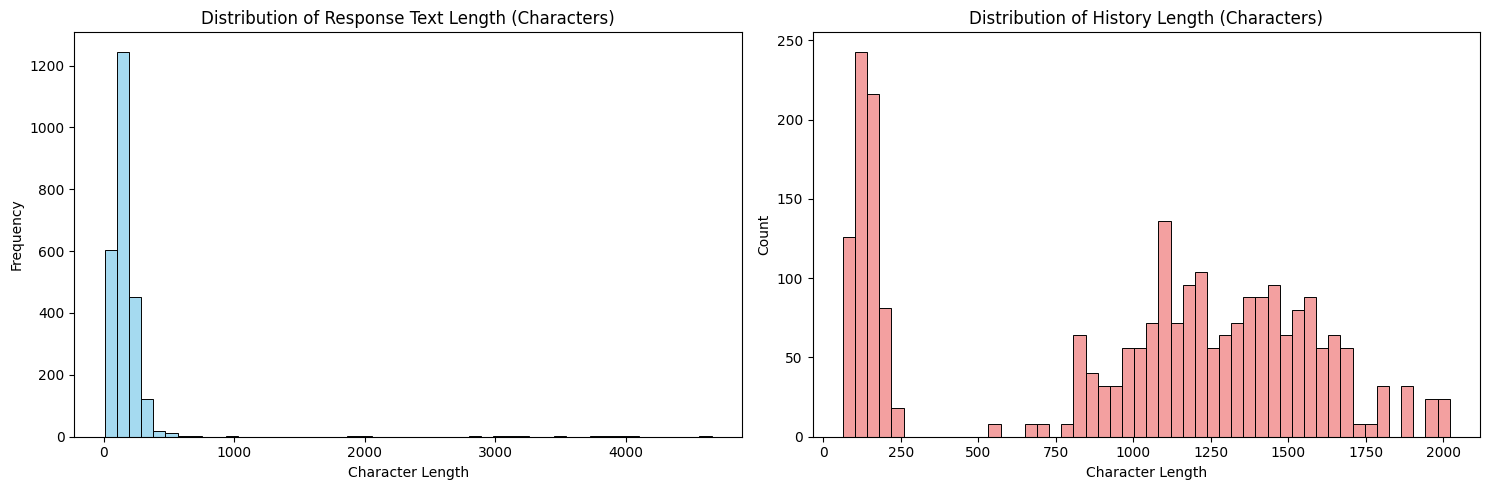

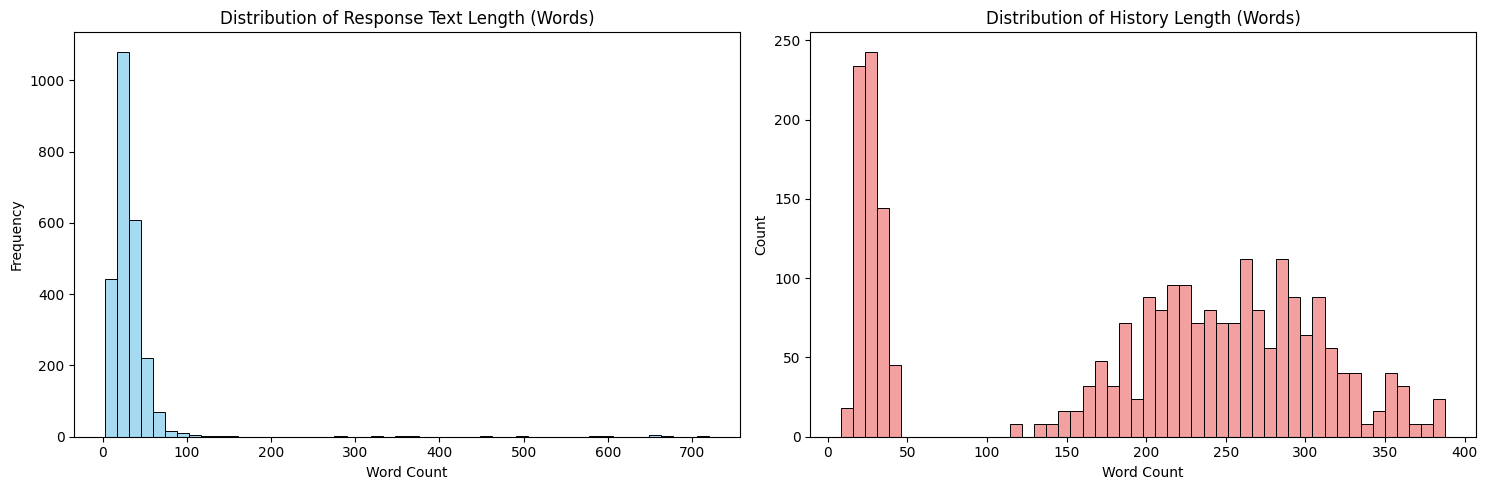


Descriptive Statistics for Text Lengths (Characters):
       response_len  history_len
count   2476.000000  2476.000000
mean     174.899031   988.957189
std      256.222749   579.441947
min        9.000000    63.000000
50%      146.000000  1144.000000
90%      262.000000  1629.500000
95%      310.000000  1723.000000
99%      532.000000  1973.000000
max     4656.000000  2021.000000

Descriptive Statistics for Text Lengths (Words):
       response_word_count  history_word_count
count          2476.000000         2476.000000
mean             32.339257          192.002019
std              44.575923          113.093320
min               2.000000            8.000000
50%              27.000000          221.000000
90%              49.000000          312.500000
95%              59.000000          348.000000
99%              99.000000          374.000000
max             721.000000          388.000000

--- EDA Complete ---


In [31]:
if df_raw is not None:
    print("--- Starting Exploratory Data Analysis ---")

    # --- 1. Analyze Label Distributions ---
    print("\n--- Label Distributions ---")
    label_columns = [f'{task}' for task in TASK_LIST]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, col in enumerate(label_columns):
        ax = axes[i]
        label_counts = df_raw[col].map(INV_LABEL_MAP).value_counts().sort_index()
        sns.barplot(x=label_counts.index, y=label_counts.values, ax=ax, hue=label_counts.index, palette="viridis", order=["Yes", "To some extent", "No"])
        ax.set_title(f'Distribution for: {TASK_KEYS[TASK_LIST[i]]}')
        ax.set_ylabel('Frequency')
        ax.tick_params(axis='x', rotation=45)
        for container in ax.containers:                                     # Add counts on top of bars
            ax.bar_label(container)

    plt.tight_layout()
    plt.show()

    for col in label_columns:
         print(f"\nValue Counts for {col}:")
         print(df_raw[col].map(INV_LABEL_MAP).value_counts())


    # --- 2. Analyze Text Lengths ---
    print("\n--- Text Length Analysis ---")

    df_raw['response_len'] = df_raw['response'].str.len()
    df_raw['history_len'] = df_raw['conversation_history'].str.len()

    df_raw['response_word_count'] = df_raw['response'].str.split().str.len()
    df_raw['history_word_count'] = df_raw['conversation_history'].str.split().str.len()


    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot character lengths
    sns.histplot(df_raw['response_len'], bins=50, ax=axes[0], color='skyblue')
    axes[0].set_title('Distribution of Response Text Length (Characters)')
    axes[0].set_xlabel('Character Length')
    axes[0].set_ylabel('Frequency')

    sns.histplot(df_raw['history_len'], bins=50, ax=axes[1], color='lightcoral')
    axes[1].set_title('Distribution of History Length (Characters)')
    axes[1].set_xlabel('Character Length')

    plt.tight_layout()
    plt.show()

    # Plot word counts
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(df_raw['response_word_count'], bins=50, ax=axes[0], color='skyblue')
    axes[0].set_title('Distribution of Response Text Length (Words)')
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')

    sns.histplot(df_raw['history_word_count'], bins=50, ax=axes[1], color='lightcoral')
    axes[1].set_title('Distribution of History Length (Words)')
    axes[1].set_xlabel('Word Count')

    plt.tight_layout()
    plt.show()


    # Print descriptive statistics for lengths
    print("\nDescriptive Statistics for Text Lengths (Characters):")
    print(df_raw[['response_len', 'history_len']].describe(percentiles=[0.90, 0.95, 0.99]))

    print("\nDescriptive Statistics for Text Lengths (Words):")
    print(df_raw[['response_word_count', 'history_word_count']].describe(percentiles=[0.90, 0.95, 0.99]))

    # MAX_LENGTH based on EDA (e.g., 90th/95th percentile of combined length if including history)
    # This requires a specific base model's tokenizer to be accurate, but character/word counts give a good initial estimate.
    # We should refine MAX_LENGTH when tokenizing if needed.

    print("\n--- EDA Complete ---")

else:
    print("Skipping EDA because data loading failed.")

In [32]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


CLASS_WEIGHTS = {} # Dictionary to store weights for each task

if 'df_raw' in locals() and df_raw is not None and not df_raw.empty:
    print("--- Calculating Class Weights (based on the entire dataset) ---")

    for task_name in TASK_LIST:
        if task_name in df_raw.columns:
            labels = df_raw[task_name].dropna().unique()
            labels.sort()
            # 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
            weights = compute_class_weight(class_weight='balanced',
                                           classes=labels,
                                           y=df_raw[task_name].dropna().values)
            CLASS_WEIGHTS[task_name] = torch.tensor(weights, dtype=torch.float)
            print(f"  Task: {task_name}, Weights: {CLASS_WEIGHTS[task_name]}")
        else:
            print(f"Warning: Label column '{task_name}' not found. Cannot calculate weights.")
else:
    print("Skipping class weight calculation because df_raw is not available.")

--- Calculating Class Weights (based on the entire dataset) ---
  Task: Mistake_Identification, Weights: tensor([0.4272, 4.7433, 2.2306])
  Task: Mistake_Location, Weights: tensor([0.5349, 3.7515, 1.1576])
  Task: Providing_Guidance, Weights: tensor([0.5866, 1.6408, 1.4582])
  Task: Actionability, Weights: tensor([0.6300, 2.2367, 1.0355])


#### **EDA takeaways** :
Here are a few key takeaways relevant to the next steps:

1. **Class Imbalance**: As the value counts show, there's a noticeable imbalance in the labels for all four tasks, especially with "To some extent" and sometimes "No" being minority classes. This brings up the idea that using techniques like weighted loss functions* (e.g., Focal Loss, or passing class weights to CrossEntropyLoss)* or careful evaluation metrics (like *Macro F1*) will be important during training and evaluation. *Stratified splitting* in create_dataloaders is also a good step.

2. **Text Length & MAX_LENGTH**:
The response lengths are mostly moderate (95% percentile at 59 words), but with some very long outliers.
The history lengths are significantly longer (95% percentile at 348 words).
We tried with MAX_LENGTH=256 as it seemed like a reasonable starting point, especially if we don't include the full history. If we do include history (include_history=True), we experienced significant truncation of the history part for many examples.

So, we changed MAX_LENGTH to 384, to not truncate too much and also not have resource overhead(if we used more)  

### **Preprocessing Functions**
This section defines functions for cleaning the text data and preparing it for the model.
- **clean_text (Optional)**: A function to optionally remove punctuation and/or stopwords.
- **TutorResponseDataset**: A custom PyTorch Dataset class. This class handles fetching individual data points, applying the selected cleaning options, combining history and response if specified, and using the Hugging Face tokenizer to convert the text into numerical input IDs and attention masks suitable for transformer models. It reads the label columns directly as defined in our DataFrame (e.g., Mistake_Identification).
- **create_dataloaders**: A helper function that takes the raw DataFrame, splits it into training, validation, and test sets, initializes the tokenizer and TutorResponseDataset for each split using the specified configuration, and finally creates PyTorch DataLoader objects to efficiently feed data to the model in batches.

In [33]:
import string
import re

def clean_text(text, remove_punct=False, remove_stopwords=False):
    """
    Applies basic text cleaning options.

    Args:
        text (str): The input text.
        remove_punct (bool): Whether to remove punctuation.
        remove_stopwords (bool): Whether to remove NLTK English stopwords.

    Returns:
        str: The cleaned text.
    """
    if not isinstance(text, str):
        return "" # Return empty string for non-string inputs

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    if remove_punct:
        translator = str.maketrans('', '', string.punctuation)
        text = text.translate(translator)

    # Remove stopwords
    if remove_stopwords:
        if STOPWORDS:
            text = ' '.join([word for word in text.split() if word not in STOPWORDS])
        else:
            print("NLTK stopwords not loaded. Skipping stopword removal.")

    text = re.sub(r'\s+', ' ', text).strip()

    return text

# --- Example Usage , just to see if it's working the way its intended to ---
example = " This is an example response... with punctuation! And stopwords. "
print("Original:", example)
print("Cleaned (Punct):", clean_text(example, remove_punct=True, remove_stopwords=False))
print("Cleaned (Punct+Stopwords):", clean_text(example, remove_punct=True, remove_stopwords=True))
print("Cleaned (None):", clean_text(example, remove_punct=False, remove_stopwords=False))

Original:  This is an example response... with punctuation! And stopwords. 
Cleaned (Punct): this is an example response with punctuation and stopwords
Cleaned (Punct+Stopwords): example response punctuation stopwords
Cleaned (None): this is an example response... with punctuation! and stopwords.


In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import pandas as pd
import os

class TutorResponseDataset(Dataset):
    """
    PyTorch Dataset class for tutor response classification.
    Handles text cleaning, formatting, and tokenization based on the
    DataFrame structure produced by the user's load_data function.
    """
    def __init__(self, dataframe, tokenizer, max_len, include_history=True, remove_punct=False, remove_stopwords=False):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing the data ('conversation_history',
                                      'response', and label columns like 'Mistake_Identification').
            tokenizer (transformers.PreTrainedTokenizer): Tokenizer instance.
            max_len (int): Maximum sequence length for tokenization.
            include_history (bool): Whether to prepend conversation history to the response.
            remove_punct (bool): Whether to remove punctuation during cleaning.
            remove_stopwords (bool): Whether to remove stopwords during cleaning.
                                                                                                                    """
        # --- Input Validation ---
        if not isinstance(dataframe, pd.DataFrame) or dataframe.empty:
            raise ValueError("Input 'dataframe' must be a non-empty Pandas DataFrame.")
        if not hasattr(tokenizer, 'encode_plus'):
             raise ValueError("Input 'tokenizer' must be a valid Hugging Face tokenizer instance.")
        if not isinstance(max_len, int) or max_len <= 0:
             raise ValueError("'max_len' must be a positive integer.")

        self.tokenizer = tokenizer
        self.data = dataframe.reset_index(drop=True)
        self.max_len = max_len
        self.include_history = include_history
        self.remove_punct = remove_punct
        self.remove_stopwords = remove_stopwords

        self.label_columns = TASK_LIST

        for col in self.label_columns:
            if col not in self.data.columns:
                raise ValueError(f"Label column '{col}' defined in TASK_LIST not found in the provided DataFrame.")


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        try:
            item = self.data.iloc[index]
        except IndexError:
             raise IndexError(f"Index {index} out of bounds for dataset with length {len(self)}")

        response_text = str(item.response)
        history_text = str(item.conversation_history)

        cleaned_response = clean_text(response_text, self.remove_punct, self.remove_stopwords)
        cleaned_history = clean_text(history_text, self.remove_punct, self.remove_stopwords)

        # Combine history and response if specified
        if self.include_history and cleaned_history:
            # Use tokenizer's special separator token if available (e.g., [SEP])
            sep_token = self.tokenizer.sep_token if self.tokenizer.sep_token else " "
            final_text = cleaned_history + sep_token + cleaned_response
        else:
            final_text = cleaned_response

        # Tokenize
        encoding = self.tokenizer.encode_plus(
            final_text,
            add_special_tokens=True, # Add [CLS] and [SEP] (or model-specific tokens)
            max_length=self.max_len,
            padding='max_length',    # Pad to max_len
            truncation=True,         # Truncate if longer than max_len
            return_attention_mask=True,
            return_tensors='pt',     # Return PyTorch tensors
        )

        # Get labels for all tasks using the column names from TASK_LIST
        try:
            labels = torch.tensor([item[col] for col in self.label_columns], dtype=torch.long)
        except KeyError as e:
             print(f"Error accessing label column at index {index}. Missing column: {e}")
             raise e
        except Exception as e:
             print(f"Error processing labels at index {index}: {e}")
             raise e


        return {
            # Use .squeeze() to remove the batch dimension added by return_tensors='pt'
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': labels
        }


def create_dataloaders(df, tokenizer_name, batch_size, max_len, preprocessing_flags, test_size=0.1, val_size=0.1, random_state=SEED):
    """
    Creates train, validation, and test dataloaders.

    Args:
        df (pd.DataFrame): The full dataset DataFrame.
        tokenizer_name (str): Name of the Hugging Face tokenizer to load.
        batch_size (int): Batch size for the dataloaders.
        max_len (int): Maximum sequence length for tokenization.
        preprocessing_flags (dict): Dictionary containing 'include_history',
                                    'remove_punct', 'remove_stopwords' booleans.
        test_size (float): Proportion of data for the test set.
        val_size (float): Proportion of data for the validation set (taken from the initial training split).
        random_state (int): Random seed for splitting.

    Returns:
        tuple: (train_loader, val_loader, test_loader, tokenizer)
               Returns None for loaders if splitting fails or df is invalid.
                                                                                                                    """
    if df is None or df.empty:
        print("Error: Input DataFrame is empty or None. Cannot create dataloaders.")
        return None, None, None, None
    if not all(flag in preprocessing_flags for flag in ['include_history', 'remove_punct', 'remove_stopwords']):
         print("Error: preprocessing_flags dictionary is missing required keys.")
         return None, None, None, None

    try:
        # Split data into Train+Validation and Test
        if 'TASK_LIST' not in globals():
             print("Error: Global variable TASK_LIST not found. Needed for stratification.")
             stratify_col = None
        else:
             stratify_col_name = TASK_LIST[0]
             if stratify_col_name in df.columns:
                  stratify_col = df[stratify_col_name]
             else:
                  print(f"Warning: Stratification column '{stratify_col_name}' not found. Proceeding without stratification.")
                  stratify_col = None

        train_val_df, test_df = train_test_split(
            df,
            test_size=test_size,
            random_state=random_state,
            stratify=stratify_col
        )

        # Split (Train + Validation) into Train and Validation
        val_size_adjusted = val_size / (1.0 - test_size) if (1.0 - test_size) > 0 else 0

        # Stratify the second split as well
        if stratify_col is not None and stratify_col_name in train_val_df.columns:
             stratify_col_train_val = train_val_df[stratify_col_name]
        else:
             stratify_col_train_val = None

        train_df, val_df = train_test_split(
            train_val_df,
            test_size=val_size_adjusted,
            random_state=random_state,
            stratify=stratify_col_train_val
        )

        print(f"Data split sizes:")
        print(f"  Train: {len(train_df)}")
        print(f"  Validation: {len(val_df)}")
        print(f"  Test: {len(test_df)}")

        # Load tokenizer
        print(f"Loading tokenizer: {tokenizer_name}")
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

        # Create Dataset instances
        print("Creating Train Dataset...")
        train_dataset = TutorResponseDataset(train_df, tokenizer, max_len, **preprocessing_flags)
        print("Creating Validation Dataset...")
        val_dataset = TutorResponseDataset(val_df, tokenizer, max_len, **preprocessing_flags)
        print("Creating Test Dataset...")
        test_dataset = TutorResponseDataset(test_df, tokenizer, max_len, **preprocessing_flags)

        # Determine num_workers based on CPU count, handle potential issues
        try:
            num_workers = max(0, os.cpu_count() // 2 - 1)
        except NotImplementedError:
            num_workers = 0

        print(f"Using {num_workers} workers for DataLoaders.")

        # Create DataLoader instances
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=torch.cuda.is_available()) # Pin memory if using GPU
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=torch.cuda.is_available())
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=torch.cuda.is_available())

        print("Dataloaders created successfully.")
        return train_loader, val_loader, test_loader, tokenizer

    except ValueError as ve:
         print(f"ValueError during dataloader creation: {ve}")
         return None, None, None, None
    except Exception as e:
        print(f"An unexpected error occurred during dataloader creation: {e}")
        traceback.print_exc()
        return None, None, None, None

### **Model Definition**
Now, we will define the model architectures we plan to experiment with. We'll use pre-trained transformer models from Hugging Face as the base and add classification heads suitable for our tasks.

We will implement 2 main strategies:

- **Single-Task**: Train four separate models, one for each pedagogical dimension (Mistake_Identification, Mistake_Location, Providing_Guidance, Actionability). Each model will be a standard sequence classification model fine-tuned for one specific task. This is simpler to set up and debug.

- **Multi-Task**: Train a single model with a shared transformer base (e.g., BERT, DistilBERT) and four separate classification heads, one for each task. Our idea/conjecture is that the shared base may learn representations beneficial for all four related tasks, potentially leading to better performance or efficiency.

The code below provide functions/classes to create both types of models based on a chosen base model name.

In [35]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoModelForSequenceClassification, PreTrainedModel, AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput # For custom model output

NUM_TASKS = len(TASK_LIST)

# --- Option A: Single-Task Model ---

def create_single_task_model(base_model_name, num_labels=NUM_CLASSES):
    """
    Loads a pre-trained transformer model with a single sequence classification head.

    Args:
        base_model_name (str): The name of the pre-trained model (e.g., 'bert-base-uncased').
        num_labels (int): The number of output classes (should be 3 for each task).

    Returns:
        transformers.PreTrainedModel: The loaded model ready for fine-tuning.
                                      Returns None if loading fails.
    """
    try:
        print(f"Loading single-task model: {base_model_name} with {num_labels} labels.")
        # Load the model for sequence classification with the specified number of labels
        model = AutoModelForSequenceClassification.from_pretrained(
            base_model_name,
            num_labels=num_labels
        )
        return model
    except Exception as e:
        print(f"Error loading single-task model {base_model_name}: {e}")
        return None



# --- Option B: Multi-Task Model ---
class MultiTaskModel(PreTrainedModel):
    """
    A custom multi-task learning model with a shared transformer base and
    separate classification heads for each task.
    """
    def __init__(self, config, base_model_name, num_labels_per_task):
        """
        Args:
            config (transformers.PretrainedConfig): The configuration object for the model.
            base_model_name (str): The name of the pre-trained base model.
            num_labels_per_task (list[int]): A list containing the number of labels for each task.
                                            (e.g., [3, 3, 3, 3] for our 4 tasks).
        """
        super().__init__(config) # Initialize the parent PreTrainedModel class
        self.num_tasks = len(num_labels_per_task)
        self.num_labels_per_task = num_labels_per_task

        # Load the shared base transformer model
        print(f"Loading base model for multi-task: {base_model_name}")
        self.my_model = AutoModel.from_pretrained(base_model_name, config=config)

        # Define separate classification heads (dropout + linear layer) for each task
        self.classifiers = nn.ModuleList([
            nn.Sequential(
                nn.Dropout(config.hidden_dropout_prob if hasattr(config, 'hidden_dropout_prob') else 0.1), # Use dropout from config if available
                nn.Linear(config.hidden_size, num_labels)
            )
            for num_labels in num_labels_per_task
        ])

        # Initialize weights for the classifiers
        self._init_weights()

    def _init_weights(self):
        """Initializes the weights of the classification heads."""
        for classifier in self.classifiers:
            for module in classifier:
                if isinstance(module, nn.Linear):
                    # Standard initialization for linear layers
                    module.weight.data.normal_(mean=0.0, std=self.config.initializer_range if hasattr(self.config, 'initializer_range') else 0.02)
                    if module.bias is not None:
                        module.bias.data.zero_()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None, # some models like BERT need them
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None, # shape: [batch_size, num_tasks]
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        """
        Forward pass for the multi-task model.

        Args:
            labels (torch.Tensor, optional): Labels for computing the loss.
                                             Shape: (batch_size, num_tasks).

        Returns:
            transformers.modeling_outputs.SequenceClassifierOutput or tuple:
                If return_dict is True, returns a SequenceClassifierOutput object
                containing loss (if labels provided) and logits (list of tensors).
                Otherwise, returns a tuple (loss, list_of_logits).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # Pass inputs through the base transformer model
        outputs = self.my_model(
            input_ids,
            attention_mask=attention_mask,
            # token_type_ids=token_type_ids,
            # position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=True,
        )

        # Use the pooled output (e.g., [CLS] token representation) for classification
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
             pooled_output = outputs.pooler_output
        else:
             pooled_output = outputs.last_hidden_state[:, 0] if hasattr(outputs, 'last_hidden_state') else None

        if pooled_output is None:
             raise ValueError("Could not get pooled output from the base model.")

        # Pass the pooled output through each task-specific classifier
        logits_list = [classifier(pooled_output) for classifier in self.classifiers]

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            total_loss = 0
            for i in range(self.num_tasks):
                task_logits = logits_list[i]
                task_labels = labels[:, i] # Get labels for the i-th task
                if task_labels.min() < 0 or task_labels.max() >= self.num_labels_per_task[i]:
                     print(f"Warning: Labels for task {i} out of range: min={task_labels.min()}, max={task_labels.max()}. Num classes={self.num_labels_per_task[i]}")

                task_loss = loss_fct(task_logits.view(-1, self.num_labels_per_task[i]), task_labels.view(-1))
                total_loss += task_loss

            # Average the loss across tasks
            loss = total_loss / self.num_tasks

        if not return_dict:
            # Return tuple if return_dict is False
            output = (logits_list,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        # Return SequenceClassifierOutput object (adapting it slightly for multi-task)
        # Note: SequenceClassifierOutput expects single logits tensor, we provide a list
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits_list, # Store the list of logits tensors
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


def create_multi_task_model(base_model_name, num_labels_per_task):
    """
    Loads the base model config and instantiates the MultiTaskModel.

    Args:
        base_model_name (str): Name of the pre-trained base model.
        num_labels_per_task (list[int]): List of label counts for each task.

    Returns:
        MultiTaskModel: The instantiated multi-task model.
                        Returns None if loading fails.
    """
    try:
        print(f"Loading config for multi-task model: {base_model_name}")
        config = AutoConfig.from_pretrained(base_model_name)
        # Optionally add dropout probability if missing
        if not hasattr(config, 'hidden_dropout_prob'):
             config.hidden_dropout_prob = 0.1
             print("Added default hidden_dropout_prob=0.1 to config")

        model = MultiTaskModel(config, base_model_name, num_labels_per_task)
        return model
    except Exception as e:
        print(f"Error creating multi-task model {base_model_name}: {e}")
        traceback.print_exc()
        return None


# --- Helper Function to Get Model Based on Strategy ---
def get_model(strategy, base_model_name):
    """
    Gets the appropriate model based on the specified strategy.

    Args:
        strategy (str): 'single_task' or 'multi_task'.
        base_model_name (str): Name of the pre-trained base model.

    Returns:
        torch.nn.Module: The instantiated model, or None if failed.
    """
    if strategy == 'single_task':
        # For single task, we'll load one model per task later in the training loop
        print(f"Strategy: single_task. Will load {base_model_name} with {NUM_CLASSES} labels per task during training.")
        test_model = create_single_task_model(base_model_name, NUM_CLASSES)
        if test_model is None:
             return None
        del test_model # Free memory
        # Return the function itself, to be called later for each task
        return create_single_task_model

    elif strategy == 'multi_task':
        print(f"Strategy: multi_task. Loading {base_model_name} with {NUM_TASKS} heads.")
        # Define the number of labels for each of our 4 tasks
        num_labels_list = [NUM_CLASSES] * NUM_TASKS # e.g., [3, 3, 3, 3]
        return create_multi_task_model(base_model_name, num_labels_list)
    else:
        print(f"Error: Unknown strategy '{strategy}'. Choose 'single_task' or 'multi_task'.")
        return None

# --- Example Usage (just to confirm it works the way it should) ---
test_strategy = 'multi_task' # or 'single_task'
test_model_name = 'distilbert-base-uncased'
print(f"\n--- Testing Model Creation (Strategy: {test_strategy}) ---")
model_instance_or_creator = get_model(test_strategy, test_model_name)

if model_instance_or_creator:
    print(f"Successfully obtained model/creator for strategy '{test_strategy}'.")
    if test_strategy == 'multi_task':
        print("Multi-task model instance created.")
        print(model_instance_or_creator) # Print model structure
    else:
        print("Single-task model creator function obtained.")
        test_single_task = model_instance_or_creator(test_model_name, NUM_CLASSES)
        if test_single_task:
             print("Successfully created a single-task model instance.")
             # print(test_single_task)
        else:
             print("Failed to create a single-task model instance.")

else:
     print(f"Failed to get model/creator for strategy '{test_strategy}'.")




--- Testing Model Creation (Strategy: multi_task) ---
Strategy: multi_task. Loading distilbert-base-uncased with 4 heads.
Loading config for multi-task model: distilbert-base-uncased
Added default hidden_dropout_prob=0.1 to config
Loading base model for multi-task: distilbert-base-uncased
Successfully obtained model/creator for strategy 'multi_task'.
Multi-task model instance created.
MultiTaskModel(
  (my_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear

### **Evaluation Metrics**
To evaluate our models, we will use the metrics given in Assign:
- **Accuracy and Macro F1-Score** : We need to calculate these for each of the four tasks individually. Furthermore, for each task, we calculate the metrics in two ways:
  - **Exact Match**: Considers the original three labels ("Yes", "To some extent", "No" mapped to 0, 1, 2). Performance is measured based on correctly predicting the exact label.

  - **Lenient Match**: Groups "Yes" (0) and "To some extent" (1) into a single positive class (mapped to 1), and considers "No" (2) as the negative class (mapped to 0). This simplifies the problem to binary classification for each task and provides a measure of whether the model generally captures the positive intent, even if not the exact thing.

The function below ***(compute_metrics***) will take model predictions (logits) and true labels and return a dictionary containing all eight scores (Exact Acc, Exact F1, Lenient Acc, Lenient F1) for each of the four tasks.

In [36]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import torch

def compute_metrics(predictions, labels):
    """
    Computes exact and lenient accuracy and macro F1 scores for each task.

    Args:
        predictions (list[torch.Tensor] or torch.Tensor):
            - If multi-task: A list of logit tensors, one for each task.
                             Each tensor shape: [num_samples, num_classes (3)].
            - If single-task: A single logit tensor. Shape: [num_samples, num_classes (3)].
        labels (torch.Tensor): Ground truth labels.
            - If multi-task: Shape [num_samples, num_tasks (4)].
            - If single-task: Shape [num_samples].

    Returns:
        dict: A dictionary containing metrics for each task.
              Example: {'Mistake_Identification': {'exact_acc': ..., 'exact_f1': ...,
                                                  'lenient_acc': ..., 'lenient_f1': ...},
                       ... }
              Returns an empty dict if inputs are invalid.
                                                                                                  """
    metrics = {}

    is_multi_task = isinstance(predictions, list)

    if is_multi_task:
        if not isinstance(labels, torch.Tensor) or labels.ndim != 2 or labels.shape[1] != len(predictions):
            print(f"Error: Invalid labels shape for multi-task. Expected [N, {len(predictions)}], got {labels.shape if isinstance(labels, torch.Tensor) else type(labels)}")
            return {}
        num_tasks = len(predictions)
        num_samples = labels.shape[0]
        # Convert list of logit tensors to predicted class indices
        try:
            preds_indices = [torch.argmax(p, dim=-1).cpu().numpy() for p in predictions] # List of numpy arrays
        except Exception as e:
             print(f"Error processing multi-task predictions: {e}")
             return {}
        labels_np = labels.cpu().numpy() # Shape [N, num_tasks]

    # Single-task case
    else:
        if not isinstance(predictions, torch.Tensor) or predictions.ndim != 2:
             print(f"Error: Invalid predictions shape for single-task. Expected [N, num_classes], got {predictions.shape if isinstance(predictions, torch.Tensor) else type(predictions)}")
             return {}
        if not isinstance(labels, torch.Tensor) or labels.ndim != 1:
             print(f"Error: Invalid labels shape for single-task. Expected [N], got {labels.shape if isinstance(labels, torch.Tensor) else type(labels)}")
             return {}
        num_tasks = 1
        num_samples = labels.shape[0]
        try:
            preds_indices = [torch.argmax(predictions, dim=-1).cpu().numpy()]
        except Exception as e:
             print(f"Error processing single-task predictions: {e}")
             return {}
        labels_np = labels.cpu().numpy().reshape(-1, 1) # Reshape to [N, 1] for consistency
    # --- End Input Validation ---


    # Iterate through each task
    for i in range(num_tasks):
        task_name = TASK_LIST[i] if is_multi_task else "single_task_metric"
        task_preds = preds_indices[i]
        task_labels = labels_np[:, i]

        # Ensure preds and labels have the same length
        if len(task_preds) != len(task_labels):
             print(f"Warning: Mismatch in length for task '{task_name}'. Preds: {len(task_preds)}, Labels: {len(task_labels)}. Skipping metrics for this task.")
             continue

        task_metrics = {}

        # 1. Exact Metrics (3 classes: 0, 1, 2)
        try:
            task_metrics['exact_acc'] = accuracy_score(task_labels, task_preds)
            task_metrics['exact_f1'] = f1_score(task_labels, task_preds, average='macro', zero_division=0)
        except Exception as e:
            print(f"Error calculating exact metrics for task '{task_name}': {e}")
            task_metrics['exact_acc'] = 0.0
            task_metrics['exact_f1'] = 0.0


        # 2. Lenient Metrics (Binary: {0, 1} -> 1, {2} -> 0)
        try:
            # Map labels: 0, 1 become 1; 2 becomes 0
            lenient_labels = np.where(task_labels < 2, 1, 0)
            lenient_preds = np.where(task_preds < 2, 1, 0)

            task_metrics['lenient_acc'] = accuracy_score(lenient_labels, lenient_preds)
            task_metrics['lenient_f1'] = f1_score(lenient_labels, lenient_preds, pos_label=1, average='binary', zero_division=0)
        except Exception as e:
            print(f"Error calculating lenient metrics for task '{task_name}': {e}")
            task_metrics['lenient_acc'] = 0.0
            task_metrics['lenient_f1'] = 0.0

        metrics[task_name] = task_metrics

    return metrics

# --- Example Usage  ---
num_samples_test = 10
num_tasks_test = 4
num_classes_test = 3

# Multi-task example
sample_logits_multi = [torch.randn(num_samples_test, num_classes_test) for _ in range(num_tasks_test)]
sample_labels_multi = torch.randint(0, num_classes_test, (num_samples_test, num_tasks_test))
metrics_result_multi = compute_metrics(sample_logits_multi, sample_labels_multi)
print("\n--- Multi-task Metrics Example ---")
print(metrics_result_multi)

# Single-task example
sample_logits_single = torch.randn(num_samples_test, num_classes_test)
sample_labels_single = torch.randint(0, num_classes_test, (num_samples_test,))
metrics_result_single = compute_metrics(sample_logits_single, sample_labels_single)
print("\n--- Single-task Metrics Example ---")
print(metrics_result_single)


--- Multi-task Metrics Example ---
{'Mistake_Identification': {'exact_acc': 0.4, 'exact_f1': 0.38095238095238093, 'lenient_acc': 0.4, 'lenient_f1': 0.5714285714285714}, 'Mistake_Location': {'exact_acc': 0.5, 'exact_f1': 0.3384615384615384, 'lenient_acc': 0.8, 'lenient_f1': 0.8888888888888888}, 'Providing_Guidance': {'exact_acc': 0.3, 'exact_f1': 0.3055555555555555, 'lenient_acc': 0.8, 'lenient_f1': 0.8571428571428571}, 'Actionability': {'exact_acc': 0.3, 'exact_f1': 0.2619047619047619, 'lenient_acc': 0.5, 'lenient_f1': 0.6153846153846154}}

--- Single-task Metrics Example ---
{'single_task_metric': {'exact_acc': 0.0, 'exact_f1': 0.0, 'lenient_acc': 0.4, 'lenient_f1': 0.5714285714285714}}


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    Implementation of Focal Loss.
                                    """
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        Args:
            alpha (Tensor, optional): Weighting factor for classes (alpha for positive class, 1-alpha for negative).
                                      Can be a single float or a Tensor of shape [num_classes].
                                      If None, defaults to equal weights.
            gamma (float, optional): Focusing parameter. Defaults to 2.0.
            reduction (str, optional): Specifies the reduction to apply to the output:
                                       'none' | 'mean' | 'sum'. Defaults to 'mean'.
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        # If alpha is provided, ensure it's a tensor
        if alpha is not None:
            if isinstance(alpha, (float, int)):
                # For multi-class, alpha should usually be a tensor of size num_classes.
                 raise ValueError("For multi-class, alpha must be a Tensor of size num_classes.")
            elif isinstance(alpha, list):
                 self.alpha = torch.tensor(alpha)
            elif isinstance(alpha, torch.Tensor):
                 self.alpha = alpha
            else:
                 raise TypeError("alpha must be float, list, or Tensor")
        else:
             self.alpha = None

        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Args:
            inputs (Tensor): Logits from the model (shape: [N, C]).
            targets (Tensor): Ground truth labels (shape: [N]).

        Returns:
            Tensor: Calculated focal loss.
        """
        # Calculate Cross Entropy loss without reduction
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        # Get probabilities p_t = P(y_true | x)
        log_p = F.log_softmax(inputs, dim=-1)
        p = torch.exp(log_p)
        # Gather the probabilities corresponding to the true label
        p_t = p.gather(1, targets.unsqueeze(1)).squeeze(1) # Shape: [N]

        # Calculate focal loss factor: (1 - p_t)^gamma
        loss_factor = (1 - p_t) ** self.gamma

        # Calculate the final focal loss
        focal_loss = loss_factor * ce_loss

        # Apply alpha weighting
        if self.alpha is not None:
            if self.alpha.device != targets.device:
                 self.alpha = self.alpha.to(targets.device)
            # Gather the alpha values corresponding to the true label
            alpha_t = self.alpha.gather(0, targets) # Shape: [N]
            focal_loss = alpha_t * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        elif self.reduction == 'none':
            return focal_loss
        else:
            raise ValueError(f"Invalid reduction type: {self.reduction}")

### **Training Loop Setup**
Following below cell, we define the core ***train_and_evaluate*** function.

Key components and steps within the function:
- **Inputs**: Takes the model, training dataloader, validation dataloader, optimizer, loss function details, learning rate scheduler (optional), device, number of epochs, and the task strategy ('single_task' or 'multi_task').

- **Loss Calculation**: For single-task models (like AutoModelForSequenceClassification), the loss is typically part of the model's output when labels are provided.

**Note** : *For our multi-task model, the forward method calculates and returns the average loss across all task heads.*

- **Backward Pass & Optimization**: Calculates gradients (loss.backward()) and updates model weights (optimizer.step()). Handles gradient accumulation if specified. Clears gradients (optimizer.zero_grad()). Updates the learning rate scheduler (if used).

- **Evaluation Mode**: After each epoch, sets the model to model.eval().

- **Validation Loop**: Iterates through the val_dataloader without calculating gradients (torch.no_grad()).

- **Metric Calculation**: Collects predictions and labels from the validation set and uses the compute_metrics function (defined in the above cell) to calculate performance metrics.

- Logging: Prints or logs the training loss and validation metrics for each epoch.

- Best Model Saving (Optional): Keeps track of the best validation score and saves the corresponding model state dictionary.

- Output: Returns the best trained model state dictionary (if saved) and a history of training/validation metrics.

In [38]:
%pip install transformers[torch] # Ensure the torch extra dependencies are installed

Note: you may need to restart the kernel to use updated packages.


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup # Optional scheduler
import time
import copy # For saving best model state
import numpy as np
import traceback

def train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn_provider,
                       device, epochs, strategy,
                       task_index=None, # Index of the task for single-task training
                       class_weights=None,
                       accumulation_steps=1, scheduler=None,
                       model_save_path=None, patience=3,
                       print_every_n_steps=50):
    """
    Trains the model and evaluates it on the validation set after each epoch.
    Handles both single-task and multi-task strategies.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader): DataLoader for the validation set.
        optimizer (torch.optim.Optimizer): The optimizer.
        loss_fn_provider (str): Name ('CrossEntropyLoss', 'WeightedCrossEntropyLoss', 'FocalLoss').
        device (torch.device): The device to train on (CPU or GPU).
        epochs (int): Number of training epochs.
        strategy (str): 'single_task' or 'multi_task'.
        task_index (int, optional): The index (0 to num_tasks-1) of the target task if strategy is 'single_task'. Required for single-task.
        class_weights (dict, optional): Dictionary mapping task names (from TASK_LIST) to weight tensors.
                                        Required if loss_fn_provider is 'WeightedCrossEntropyLoss'.
        accumulation_steps (int): Number of steps to accumulate gradients over.
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler.
        model_save_path (str, optional): Path to save the best model state dict. If None, not saved.
        patience (int): Number of epochs to wait for improvement before early stopping.
        print_every_n_steps (int): Print training progress every N steps within an epoch.

    Returns:
        tuple: (best_model_state, history)
    """
    # --- Validation ---
    if strategy == 'single_task' and task_index is None: raise ValueError("task_index required for single_task.")
    if strategy == 'single_task' and not (0 <= task_index < NUM_TASKS): raise ValueError(f"task_index out of range.")
    if loss_fn_provider == 'WeightedCrossEntropyLoss' and (class_weights is None or not isinstance(class_weights, dict)):
         raise ValueError("class_weights dictionary must be provided for WeightedCrossEntropyLoss.")
    # -----------------

    history = {'train_loss': [], 'val_metrics': []}
    best_val_metric = -np.inf
    best_model_state = None
    epochs_no_improve = 0

    print(f"--- Starting Training --- [Epochs: {epochs}, Strategy: {strategy}, Loss: {loss_fn_provider}" + (f", Task Index: {task_index}" if strategy == 'single_task' else "") + "]")
    num_train_batches = len(train_loader)

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        total_train_loss = 0
        optimizer.zero_grad()

        for step, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            all_task_labels = batch['labels'].to(device) # Shape [batch_size, num_tasks]

            # --- Forward pass: Get LOGITS ONLY ---
            # We will calculate loss manually outside the model
            try:
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True) # NO labels passed here
                logits = outputs.logits # List for multi-task, Tensor for single-task
            except Exception as e:
                 print(f"Error during model forward pass at step {step} (Epoch {epoch+1}): {e}")
                 traceback.print_exc()
                 break

            # --- Manual Loss Calculation ---
            try:
                loss = 0.0
                if strategy == 'single_task':
                    task_logits = logits # Single tensor [batch_size, num_classes]
                    task_labels = all_task_labels[:, task_index] # Labels for this task [batch_size]
                    task_name = TASK_LIST[task_index]

                    # Instantiate loss function for this task
                    if loss_fn_provider == 'CrossEntropyLoss':
                        loss_fct = nn.CrossEntropyLoss()
                    elif loss_fn_provider == 'WeightedCrossEntropyLoss':
                        weights = class_weights.get(task_name)
                        if weights is None: raise ValueError(f"Weights not found for task {task_name}")
                        loss_fct = nn.CrossEntropyLoss(weight=weights.to(device))
                    elif loss_fn_provider == 'FocalLoss':
                        # Can optionally pass alpha weights to FocalLoss too if needed
                        loss_fct = FocalLoss(gamma=2.0) # Default gamma=2
                    else:
                        raise ValueError(f"Unsupported loss function: {loss_fn_provider}")

                    # Calculate loss for the single task
                    loss = loss_fct(task_logits, task_labels)

                elif strategy == 'multi_task':
                    total_task_loss = 0
                    # Logits is a list of tensors, one per task
                    for i in range(NUM_TASKS):
                        task_logits = logits[i] # Logits for task i
                        task_labels = all_task_labels[:, i] # Labels for task i
                        task_name = TASK_LIST[i]

                        # Instantiate loss function for this task
                        if loss_fn_provider == 'CrossEntropyLoss':
                             loss_fct = nn.CrossEntropyLoss()
                        elif loss_fn_provider == 'WeightedCrossEntropyLoss':
                             weights = class_weights.get(task_name)
                             if weights is None: raise ValueError(f"Weights not found for task {task_name}")
                             loss_fct = nn.CrossEntropyLoss(weight=weights.to(device))
                        elif loss_fn_provider == 'FocalLoss':
                             # alpha_weights = class_weights.get(task_name)
                             # loss_fct = FocalLoss(alpha=alpha_weights.to(device) if alpha_weights is not None else None, gamma=2.0)
                             loss_fct = FocalLoss(gamma=2.0)
                        else:
                             raise ValueError(f"Unsupported loss function: {loss_fn_provider}")

                        # Calculate loss for this task and add to total
                        total_task_loss += loss_fct(task_logits, task_labels)

                    # Average loss across tasks for multi-task
                    loss = total_task_loss / NUM_TASKS
                else:
                     raise ValueError("Invalid strategy")

            except Exception as e:
                 print(f"Error during manual loss calculation at step {step} (Epoch {epoch+1}): {e}")
                 traceback.print_exc()
                 continue

            # --- Backpropagation and Optimizer Step ---
            if loss is None or not isinstance(loss, torch.Tensor):
                print(f"Warning: Invalid loss calculated at step {step}. Skipping backprop.")
                continue

            loss = loss / accumulation_steps
            current_batch_loss = loss.item() * accumulation_steps
            total_train_loss += current_batch_loss

            loss.backward()

            if (step + 1) % accumulation_steps == 0 or (step + 1) == num_train_batches:
                optimizer.step()
                if scheduler: scheduler.step()
                optimizer.zero_grad()

            if (step + 1) % print_every_n_steps == 0 or (step + 1) == num_train_batches:
                 print(f"  Epoch {epoch+1}/{epochs}, Step {step+1}/{num_train_batches}, Batch Loss: {current_batch_loss:.4f}")

        avg_train_loss = total_train_loss / num_train_batches if num_train_batches > 0 else 0
        history['train_loss'].append(avg_train_loss)

        # --- Validation Phase ---
        model.eval()
        all_logits = []
        all_labels = []
        if strategy == 'multi_task':
             for _ in range(NUM_TASKS): all_logits.append([])

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                batch_labels = batch['labels'].to(device)
                try:
                    # Forward pass without labels for validation too
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
                    logits = outputs.logits
                    if strategy == 'multi_task':
                        for i in range(NUM_TASKS): all_logits[i].append(logits[i].cpu())
                    else: # Single-task
                        all_logits.append(logits.cpu())
                    all_labels.append(batch_labels.cpu())
                except Exception as e:
                     print(f"Error during validation step (Epoch {epoch+1}): {e}")
                     traceback.print_exc()
                     break

        # --- Metric Calculation ---
        val_metrics = {}
        try:
             final_labels = torch.cat(all_labels, dim=0) if all_labels else torch.empty(0, NUM_TASKS)
             if final_labels.numel() > 0:
                 if strategy == 'multi_task':
                      final_preds_logits = [torch.cat(preds_list, dim=0) for preds_list in all_logits if preds_list]
                      if len(final_preds_logits) == NUM_TASKS:
                           val_metrics = compute_metrics(final_preds_logits, final_labels)
                      else: print("Warning: Mismatch in number of prediction tensors for multi-task validation.")
                 else: # Single-task
                      final_preds_logits = torch.cat(all_logits, dim=0) if all_logits else torch.empty(0, NUM_CLASSES)
                      single_task_labels = final_labels[:, task_index]
                      if final_preds_logits.numel() > 0 and single_task_labels.numel() > 0:
                           val_metrics = compute_metrics(final_preds_logits, single_task_labels)
                           if 'single_task_metric' in val_metrics:
                                val_metrics[TASK_LIST[task_index]] = val_metrics.pop('single_task_metric')
                      else: print("Warning: No validation predictions or labels collected for single task.")
             else: print("Warning: No validation labels collected. Skipping metric calculation.")
        except Exception as e:
             print(f"Error concatenating validation results or computing metrics (Epoch {epoch+1}): {e}")
             traceback.print_exc()

        history['val_metrics'].append(val_metrics)
        end_time = time.time()
        epoch_time = end_time - start_time

        # --- Logging & Best Model Check ---
        print(f"Epoch {epoch+1}/{epochs} | Time: {epoch_time:.2f}s | Avg Train Loss: {avg_train_loss:.4f}")
        current_epoch_avg_metric = 0.0
        if val_metrics:
            try:
                lenient_f1_scores = [task_metrics.get('lenient_f1', 0.0) for task_metrics in val_metrics.values()]
                if lenient_f1_scores: current_epoch_avg_metric = np.mean(lenient_f1_scores)
                else: print("  No valid F1 scores found in validation metrics.")
                print(f"  Avg Validation Lenient F1 (over evaluated tasks): {current_epoch_avg_metric:.4f}")
                for task_name, metrics_dict in val_metrics.items():
                     print(f"    {task_name}: Exact Acc: {metrics_dict.get('exact_acc', 0):.4f}, Exact F1: {metrics_dict.get('exact_f1', 0):.4f}, Lenient Acc: {metrics_dict.get('lenient_acc', 0):.4f}, Lenient F1: {metrics_dict.get('lenient_f1', 0):.4f}")
            except Exception as e: print(f"Error processing/printing validation metrics: {e}")
        else: print("  Validation metrics could not be calculated for this epoch.")

        if current_epoch_avg_metric > best_val_metric:
            print(f"  Validation metric improved ({best_val_metric:.4f} --> {current_epoch_avg_metric:.4f}).")
            best_val_metric = current_epoch_avg_metric
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            if model_save_path:
                try:
                    torch.save(best_model_state, model_save_path)
                    print(f"  Best model saved to {model_save_path}")
                except Exception as e: print(f"Error saving model to {model_save_path}: {e}")
        else:
            epochs_no_improve += 1
            print(f"  Validation metric did not improve. Patience: {epochs_no_improve}/{patience}.")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

    print(f"--- Training Finished --- Best Avg Validation Lenient F1: {best_val_metric:.4f}")
    if best_model_state is None and model is not None:
         print("Warning: No improvement observed during training. Returning current model state.")
         best_model_state = copy.deepcopy(model.state_dict())

    return best_model_state, history


### **Experimentations**
This is the section where we will systematically run experiments for different configurations. We will iterate through the combinations defined in the first cell :

- Preprocessing Options: Different settings for including history etc. (defined in PREPROCESSING_OPTIONS).

- Base Models: Different pre-trained transformer models (defined in BASE_MODELS_TO_TRY).

- Task Strategies: Single-task vs. Multi-task training (defined in TASK_STRATEGIES).

- Loss Functions: Different loss functions (defined in LOSS_FUNCTIONS_TO_TRY)

For each valid combination, the code will:

1. Prepare the data using create_dataloaders.

2. Initialize the appropriate model (single_task or multi_task) using get_model.

3. Set up the optimizer (AdamW).

4. Call the train_and_evaluate function.
  - For multi_task, this runs once per configuration.

  - For single_task, this involves an inner loop running train_and_evaluate four times, once for each task, using separate model instances.

5. Extract the best validation metrics from the training history.

6. Store the configuration details and the achieved validation metrics.

7. Perform cleanup



In [26]:
import itertools
import pandas as pd
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup # Optional scheduler
import gc
import traceback # For error printing
import time

all_results = []

# --- Generate all preprocessing combinations ---
pp_keys = PREPROCESSING_OPTIONS.keys()
pp_value_combinations = list(itertools.product(*PREPROCESSING_OPTIONS.values()))
preprocessing_configs = [dict(zip(pp_keys, values)) for values in pp_value_combinations]

print(f"Starting Experiment Runner...")
print(f"Total preprocessing configs: {len(preprocessing_configs)}")
print(f"Models to try: {BASE_MODELS_TO_TRY}")
print(f"Strategies to try: {TASK_STRATEGIES}")
print(f"Loss functions to try: {LOSS_FUNCTIONS_TO_TRY}")
print("-" * 50)

# --- Main Experiment Loop ---
experiment_count = 0
for pp_flags in preprocessing_configs:
    for base_model_name in BASE_MODELS_TO_TRY:
        for strategy in TASK_STRATEGIES:
            for loss_fn_name in LOSS_FUNCTIONS_TO_TRY:
                experiment_count += 1
                config = {
                    'exp_id': experiment_count,
                    'model': base_model_name,
                    'strategy': strategy,
                    'loss': loss_fn_name,
                    **pp_flags # Add preprocessing flags
                }
                print(f"\n--- Running Experiment {experiment_count} ---")
                print(f"Config: {config}")

                # --- 1. Data Preparation ---
                print("Preparing Dataloaders...")
                try:
                    train_loader, val_loader, test_loader, tokenizer = create_dataloaders(
                        df=df_raw,
                        tokenizer_name=base_model_name,
                        batch_size=BATCH_SIZE,
                        max_len=MAX_LENGTH,
                        preprocessing_flags=pp_flags,
                        random_state=SEED
                    )
                    if not train_loader or not val_loader:
                         print("Error: Dataloader creation failed. Skipping experiment.")
                         result_entry = {'config': config, 'status': 'dataloader_error', 'val_metrics': None}
                         all_results.append(result_entry)
                         continue
                except Exception as e:
                    print(f"Error during dataloader creation for config {config}: {e}")
                    traceback.print_exc()
                    result_entry = {'config': config, 'status': 'dataloader_exception', 'val_metrics': None}
                    all_results.append(result_entry)
                    continue

                # --- 2. Model, Optimizer, Scheduler Setup ---
                model = None
                optimizer = None
                scheduler = None
                best_val_metrics_agg = {}

                try:
                    if strategy == 'multi_task':
                        print("Initializing Multi-Task Model...")
                        model = get_model(strategy, base_model_name)
                        if model:
                            model.to(DEVICE)
                            optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
                            # scheduler = ... # Optional
                        else:
                            raise ValueError("Multi-task model creation failed.")

                        print("Starting Multi-Task Training...")
                        best_model_state, history = train_and_evaluate(
                            model=model,
                            train_loader=train_loader,
                            val_loader=val_loader,
                            optimizer=optimizer,
                            loss_fn_provider=loss_fn_name, # Pass loss name
                            class_weights=CLASS_WEIGHTS,
                            device=DEVICE,
                            epochs=EPOCHS,
                            strategy=strategy,
                            scheduler=scheduler
                        )
                        best_epoch_metrics = {}
                        if history and history.get('val_metrics'):
                             epoch_avg_f1s = [np.mean([m.get('lenient_f1', 0.0) for m in epoch_metrics.values()]) if epoch_metrics else -1 for epoch_metrics in history['val_metrics']]
                             if epoch_avg_f1s:
                                  best_epoch_idx = np.argmax(epoch_avg_f1s)
                                  best_epoch_metrics = history['val_metrics'][best_epoch_idx]
                             else: print("Warning: No valid validation metrics found in history.")
                        best_val_metrics_agg = best_epoch_metrics


                    elif strategy == 'single_task':
                        print("Initializing Single-Task Models (one per task)...")
                        model_creator = get_model(strategy, base_model_name)
                        if not model_creator: raise ValueError("Single-task model creator function not obtained.")

                        task_histories = {}
                        task_best_metrics = {}

                        for task_idx, task_name in enumerate(TASK_LIST):
                            print(f"\n-- Training Single-Task Model for: {task_name} (Task {task_idx+1}/{NUM_TASKS}) --")
                            task_model = model_creator(base_model_name, NUM_CLASSES)
                            if not task_model: print(f"Error creating model for task {task_name}. Skipping task."); continue
                            task_model.to(DEVICE)
                            task_optimizer = AdamW(task_model.parameters(), lr=LEARNING_RATE)
                            # task_scheduler = ... # Optional

                            best_task_model_state, task_history = train_and_evaluate(
                                model=task_model,
                                train_loader=train_loader,
                                val_loader=val_loader,
                                optimizer=task_optimizer,
                                loss_fn_provider=loss_fn_name, # Pass loss name
                                class_weights=CLASS_WEIGHTS,
                                device=DEVICE,
                                epochs=EPOCHS,
                                strategy=strategy,
                                task_index=task_idx,
                                scheduler=None # Optional: task_scheduler
                            )
                            task_histories[task_name] = task_history
                            best_task_epoch_metrics = {}
                            if task_history and task_history.get('val_metrics'):
                                 epoch_task_f1s = [epoch_metrics.get(task_name, {}).get('lenient_f1', -1) if epoch_metrics else -1 for epoch_metrics in task_history['val_metrics']]
                                 if epoch_task_f1s:
                                      best_epoch_idx = np.argmax(epoch_task_f1s)
                                      if best_epoch_idx < len(task_history['val_metrics']):
                                           best_task_epoch_metrics = task_history['val_metrics'][best_epoch_idx].get(task_name, {})
                                      else: print(f"Warning: Best epoch index {best_epoch_idx} out of range for task {task_name} history.")
                                 else: print(f"Warning: No valid validation metrics found in history for task {task_name}.")
                            task_best_metrics[task_name] = best_task_epoch_metrics

                            print(f"Cleaning up resources for task: {task_name}")
                            del task_model, task_optimizer
                            if 'best_task_model_state' in locals(): del best_task_model_state
                            gc.collect()
                            if torch.cuda.is_available(): torch.cuda.empty_cache()

                        best_val_metrics_agg = task_best_metrics


                    # --- Store results for this configuration ---
                    result_entry = { 'config': config, 'status': 'success', 'val_metrics': best_val_metrics_agg }
                    all_results.append(result_entry)
                    print(f"--- Experiment {experiment_count} Completed Successfully ---")

                except Exception as e:
                    print(f"Error during training/evaluation for config {config}: {e}")
                    traceback.print_exc()
                    result_entry = {'config': config, 'status': 'train_eval_exception', 'val_metrics': None}
                    all_results.append(result_entry)
                    print(f"--- Experiment {experiment_count} Failed ---")

                # --- Cleanup for the experiment ---
                print("Cleaning up experiment resources...")
                if 'model' in locals() and model is not None: del model
                if 'optimizer' in locals() and optimizer is not None : del optimizer
                if 'scheduler' in locals() and scheduler is not None: del scheduler
                if 'train_loader' in locals() and train_loader is not None: del train_loader
                if 'val_loader' in locals() and val_loader is not None: del val_loader
                if 'test_loader' in locals() and test_loader is not None: del test_loader
                if 'tokenizer' in locals() and tokenizer is not None: del tokenizer
                if 'best_model_state' in locals(): del best_model_state
                if 'history' in locals(): del history
                if 'task_histories' in locals(): del task_histories
                gc.collect()
                if torch.cuda.is_available(): torch.cuda.empty_cache()
                print("-" * 50)


# --- Convert results to DataFrame ---
print("\n--- Experiment Runner Finished ---")
results_df = pd.DataFrame(all_results)
print(f"Total experiments run (attempted): {experiment_count}")
if 'status' in results_df.columns:
    success_count = len(results_df[results_df['status'] == 'success'])
    print(f"Successfully completed experiments: {success_count}")
else:
    print("Status column not found in results, cannot count successful experiments.")

Starting Experiment Runner...
Total preprocessing configs: 2
Models to try: ['distilbert-base-uncased', 'bert-base-uncased', 'roberta-base']
Strategies to try: ['single_task', 'multi_task']
Loss functions to try: ['CrossEntropyLoss', 'WeightedCrossEntropyLoss', 'FocalLoss']
--------------------------------------------------

--- Running Experiment 1 ---
Config: {'exp_id': 1, 'model': 'distilbert-base-uncased', 'strategy': 'single_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: distilbert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Strategy: single_task. Will load distilbert-base-uncased with 3 labels per task during training.
Loading single-task model: di

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



-- Training Single-Task Model for: Mistake_Identification (Task 1/4) --
Loading single-task model: distilbert-base-uncased with 3 labels.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Starting Training --- [Epochs: 5, Strategy: single_task, Loss: CrossEntropyLoss, Task Index: 0]
  Epoch 1/5, Step 50/124, Batch Loss: 0.7915
  Epoch 1/5, Step 100/124, Batch Loss: 0.5949
  Epoch 1/5, Step 124/124, Batch Loss: 0.7353
Epoch 1/5 | Time: 21.34s | Avg Train Loss: 0.6867
  Avg Validation Lenient F1 (over evaluated tasks): 0.9194
    Mistake_Identification: Exact Acc: 0.7782, Exact F1: 0.2918, Lenient Acc: 0.8508, Lenient F1: 0.9194
  Validation metric improved (-inf --> 0.9194).
  Epoch 2/5, Step 50/124, Batch Loss: 0.4177
  Epoch 2/5, Step 100/124, Batch Loss: 0.5208
  Epoch 2/5, Step 124/124, Batch Loss: 0.3615
Epoch 2/5 | Time: 20.63s | Avg Train Loss: 0.5668
  Avg Validation Lenient F1 (over evaluated tasks): 0.9481
    Mistake_Identification: Exact Acc: 0.8347, Exact F1: 0.4899, Lenient Acc: 0.9073, Lenient F1: 0.9481
  Validation metric improved (0.9194 --> 0.9481).


KeyboardInterrupt: 

In [ ]:
results_df.to_csv('experiment_results.csv', index=False)
print("Results saved to experiment_results.csv")

Results saved to experiment_results.csv


In [ ]:
results_df

config   status  \
0   {'exp_id': 1, 'model': 'distilbert-base-uncase...  success   
1   {'exp_id': 2, 'model': 'distilbert-base-uncase...  success   
2   {'exp_id': 3, 'model': 'distilbert-base-uncase...  success   
3   {'exp_id': 4, 'model': 'distilbert-base-uncase...  success   
4   {'exp_id': 5, 'model': 'distilbert-base-uncase...  success   
5   {'exp_id': 6, 'model': 'distilbert-base-uncase...  success   
6   {'exp_id': 7, 'model': 'bert-base-uncased', 's...  success   
7   {'exp_id': 8, 'model': 'bert-base-uncased', 's...  success   
8   {'exp_id': 9, 'model': 'bert-base-uncased', 's...  success   
9   {'exp_id': 10, 'model': 'bert-base-uncased', '...  success   
10  {'exp_id': 11, 'model': 'bert-base-uncased', '...  success   
11  {'exp_id': 12, 'model': 'bert-base-uncased', '...  success   
12  {'exp_id': 13, 'model': 'roberta-base', 'strat...  success   
13  {'exp_id': 14, 'model': 'roberta-base', 'strat...  success   
14  {'exp_id': 15, 'model': 'roberta-base', 'strat...  success   
15  {'exp_id': 16, 'model': 'roberta-base', 'strat...  success   
16  {'exp_id': 17, 'model': 'roberta-base', 'strat...  success   
17  {'exp_id': 18, 'model': 'roberta-base', 'strat...  success   
18  {'exp_id': 19, 'model': 'distilbert-base-uncas...  success   
19  {'exp_id': 20, 'model': 'distilbert-base-uncas...  success   
20  {'exp_id': 21, 'model': 'distilbert-base-uncas...  success   
21  {'exp_id': 22, 'model': 'distilbert-base-uncas...  success   
22  {'exp_id': 23, 'model': 'distilbert-base-uncas...  success   
23  {'exp_id': 24, 'model': 'distilbert-base-uncas...  success   
24  {'exp_id': 25, 'model': 'bert-base-uncased', '...  success   
25  {'exp_id': 26, 'model': 'bert-base-uncased', '...  success   
26  {'exp_id': 27, 'model': 'bert-base-uncased', '...  success   
27  {'exp_id': 28, 'model': 'bert-base-uncased', '...  success   
28  {'exp_id': 29, 'model': 'bert-base-uncased', '...  success   
29  {'exp_id': 30, 'model': 'bert-base-uncased', '...  success   
30  {'exp_id': 31, 'model': 'roberta-base', 'strat...  success   
31  {'exp_id': 32, 'model': 'roberta-base', 'strat...  success   
32  {'exp_id': 33, 'model': 'roberta-base', 'strat...  success   
33  {'exp_id': 34, 'model': 'roberta-base', 'strat...  success   
34  {'exp_id': 35, 'model': 'roberta-base', 'strat...  success   
35  {'exp_id': 36, 'model': 'roberta-base', 'strat...  success   

                                          val_metrics  
0   {'Mistake_Identification': {'exact_acc': 0.846...  
1   {'Mistake_Identification': {'exact_acc': 0.653...  
2   {'Mistake_Identification': {'exact_acc': 0.834...  
3   {'Mistake_Identification': {'exact_acc': 0.838...  
4   {'Mistake_Identification': {'exact_acc': 0.653...  
5   {'Mistake_Identification': {'exact_acc': 0.838...  
6   {'Mistake_Identification': {'exact_acc': 0.862...  
7   {'Mistake_Identification': {'exact_acc': 0.600...  
8   {'Mistake_Identification': {'exact_acc': 0.854...  
9   {'Mistake_Identification': {'exact_acc': 0.826...  
10  {'Mistake_Identification': {'exact_acc': 0.709...  
11  {'Mistake_Identification': {'exact_acc': 0.838...  
12  {'Mistake_Identification': {'exact_acc': 0.854...  
13  {'Mistake_Identification': {'exact_acc': 0.580...  
14  {'Mistake_Identification': {'exact_acc': 0.850...  
15  {'Mistake_Identification': {'exact_acc': 0.846...  
16  {'Mistake_Identification': {'exact_acc': 0.685...  
17  {'Mistake_Identification': {'exact_acc': 0.842...  
18  {'Mistake_Identification': {'exact_acc': 0.875...  
19  {'Mistake_Identification': {'exact_acc': 0.649...  
20  {'Mistake_Identification': {'exact_acc': 0.899...  
21  {'Mistake_Identification': {'exact_acc': 0.879...  
22  {'Mistake_Identification': {'exact_acc': 0.778...  
23  {'Mistake_Identification': {'exact_acc': 0.887...  
24  {'Mistake_Identification': {'exact_acc': 0.875...  
25  {'Mistake_Identification': {'exact_acc': 0.806...  
26  {'Mistake_Identification': {'exact_acc': 0.866...  
27  {'Mistake_Identification': {'exa

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load results_df from experiment_results.csv
results_df = pd.read_csv('experiment_results.csv')
results_df

config   status  \
0   {'exp_id': 1, 'model': 'distilbert-base-uncase...  success   
1   {'exp_id': 2, 'model': 'distilbert-base-uncase...  success   
2   {'exp_id': 3, 'model': 'distilbert-base-uncase...  success   
3   {'exp_id': 4, 'model': 'distilbert-base-uncase...  success   
4   {'exp_id': 5, 'model': 'distilbert-base-uncase...  success   
5   {'exp_id': 6, 'model': 'distilbert-base-uncase...  success   
6   {'exp_id': 7, 'model': 'bert-base-uncased', 's...  success   
7   {'exp_id': 8, 'model': 'bert-base-uncased', 's...  success   
8   {'exp_id': 9, 'model': 'bert-base-uncased', 's...  success   
9   {'exp_id': 10, 'model': 'bert-base-uncased', '...  success   
10  {'exp_id': 11, 'model': 'bert-base-uncased', '...  success   
11  {'exp_id': 12, 'model': 'bert-base-uncased', '...  success   
12  {'exp_id': 13, 'model': 'roberta-base', 'strat...  success   
13  {'exp_id': 14, 'model': 'roberta-base', 'strat...  success   
14  {'exp_id': 15, 'model': 'roberta-base', 'strat...  success   
15  {'exp_id': 16, 'model': 'roberta-base', 'strat...  success   
16  {'exp_id': 17, 'model': 'roberta-base', 'strat...  success   
17  {'exp_id': 18, 'model': 'roberta-base', 'strat...  success   
18  {'exp_id': 19, 'model': 'distilbert-base-uncas...  success   
19  {'exp_id': 20, 'model': 'distilbert-base-uncas...  success   
20  {'exp_id': 21, 'model': 'distilbert-base-uncas...  success   
21  {'exp_id': 22, 'model': 'distilbert-base-uncas...  success   
22  {'exp_id': 23, 'model': 'distilbert-base-uncas...  success   
23  {'exp_id': 24, 'model': 'distilbert-base-uncas...  success   
24  {'exp_id': 25, 'model': 'bert-base-uncased', '...  success   
25  {'exp_id': 26, 'model': 'bert-base-uncased', '...  success   
26  {'exp_id': 27, 'model': 'bert-base-uncased', '...  success   
27  {'exp_id': 28, 'model': 'bert-base-uncased', '...  success   
28  {'exp_id': 29, 'model': 'bert-base-uncased', '...  success   
29  {'exp_id': 30, 'model': 'bert-base-uncased', '...  success   
30  {'exp_id': 31, 'model': 'roberta-base', 'strat...  success   
31  {'exp_id': 32, 'model': 'roberta-base', 'strat...  success   
32  {'exp_id': 33, 'model': 'roberta-base', 'strat...  success   
33  {'exp_id': 34, 'model': 'roberta-base', 'strat...  success   
34  {'exp_id': 35, 'model': 'roberta-base', 'strat...  success   
35  {'exp_id': 36, 'model': 'roberta-base', 'strat...  success   

                                          val_metrics  
0   {'Mistake_Identification': {'exact_acc': 0.846...  
1   {'Mistake_Identification': {'exact_acc': 0.653...  
2   {'Mistake_Identification': {'exact_acc': 0.834...  
3   {'Mistake_Identification': {'exact_acc': 0.838...  
4   {'Mistake_Identification': {'exact_acc': 0.653...  
5   {'Mistake_Identification': {'exact_acc': 0.838...  
6   {'Mistake_Identification': {'exact_acc': 0.862...  
7   {'Mistake_Identification': {'exact_acc': 0.600...  
8   {'Mistake_Identification': {'exact_acc': 0.854...  
9   {'Mistake_Identification': {'exact_acc': 0.826...  
10  {'Mistake_Identification': {'exact_acc': 0.709...  
11  {'Mistake_Identification': {'exact_acc': 0.838...  
12  {'Mistake_Identification': {'exact_acc': 0.854...  
13  {'Mistake_Identification': {'exact_acc': 0.580...  
14  {'Mistake_Identification': {'exact_acc': 0.850...  
15  {'Mistake_Identification': {'exact_acc': 0.846...  
16  {'Mistake_Identification': {'exact_acc': 0.685...  
17  {'Mistake_Identification': {'exact_acc': 0.842...  
18  {'Mistake_Identification': {'exact_acc': 0.875...  
19  {'Mistake_Identification': {'exact_acc': 0.649...  
20  {'Mistake_Identification': {'exact_acc': 0.899...  
21  {'Mistake_Identification': {'exact_acc': 0.879...  
22  {'Mistake_Identification': {'exact_acc': 0.778...  
23  {'Mistake_Identification': {'exact_acc': 0.887...  
24  {'Mistake_Identification': {'exact_acc': 0.875...  
25  {'Mistake_Identification': {'exact_acc': 0.806...  
26  {'Mistake_Identification': {'exact_acc': 0.866...  
27  {'Mistake_Identification': {'exa

In [ ]:
import pandas as pd
import ast
import numpy as np
import os
import traceback

# --- Configuration ---
INPUT_CSV_PATH = 'experiment_results.csv'
OUTPUT_CSV_PATH = 'analysis_results.csv'


TASK_LIST = ['Mistake_Identification', 'Mistake_Location', 'Providing_Guidance', 'Actionability']

def parse_literal(data_str):
    """Safely parses a string containing a Python literal (dict, list, etc.)."""
    if pd.isna(data_str):
        return None
    try:
        data_str = re.sub(r':\s*true\b', ': True', data_str, flags=re.IGNORECASE)
        data_str = re.sub(r':\s*false\b', ': False', data_str, flags=re.IGNORECASE)

        return ast.literal_eval(data_str)
    except (ValueError, SyntaxError, TypeError) as e:
        print(f"Warning: Could not parse string: {str(data_str)[:100]}... Error: {e}")
        try:
             return None
        except Exception:
             return None
    except Exception as e:
        print(f"Unexpected Error during parsing: {str(data_str)[:100]}... Error: {e}")
        return None

# --- Main Processing ---
print(f"Loading data from: {INPUT_CSV_PATH}")
if not os.path.exists(INPUT_CSV_PATH):
    print(f"Error: Input file not found at {INPUT_CSV_PATH}")
else:
    try:
        # Load the CSV
        df = pd.read_csv(INPUT_CSV_PATH)
        print(f"Loaded {len(df)} rows.")

        # Keep the original val_metrics string
        df['original_val_metrics_str'] = df['val_metrics']


        print("Parsing 'config' and 'val_metrics' columns...")
        df['config_dict'] = df['config'].apply(parse_literal)
        df['metrics_dict'] = df['original_val_metrics_str'].apply(parse_literal)

        failed_config_parses = df['config_dict'].isna().sum()
        failed_metrics_parses = df['metrics_dict'].isna().sum()
        if failed_config_parses > 0:
            print(f"Warning: Failed to parse 'config' for {failed_config_parses} rows.")
        if failed_metrics_parses > 0:
            print(f"Warning: Failed to parse 'val_metrics' for {failed_metrics_parses} rows.")

        initial_rows = len(df)
        df.dropna(subset=['config_dict', 'metrics_dict'], inplace=True)
        rows_after_drop = len(df)
        if initial_rows > rows_after_drop:
             print(f"{initial_rows - rows_after_drop} rows dropped due to parsing errors.")
        print(f"{rows_after_drop} rows remaining for processing.")

        # --- 2. Expand 'config' dictionary ---
        if not df.empty:
            print("Expanding 'config' dictionary...")
            try:
                valid_configs = df['config_dict'][df['config_dict'].apply(isinstance, args=(dict,))]
                if not valid_configs.empty:
                     config_expanded = pd.json_normalize(valid_configs).fillna('N/A')
                     config_expanded.columns = [f"{col}" for col in config_expanded.columns]
                     config_expanded = config_expanded.reindex(df.index)
                     df = pd.concat([df.drop(['config', 'config_dict'], axis=1), config_expanded], axis=1)
                else:
                     print("Warning: No valid dictionaries found in 'config_dict' column after parsing.")
                     df = df.drop(['config', 'config_dict'], axis=1)

            except Exception as e:
                print(f"Error expanding config dict: {e}")
                traceback.print_exc()
        else:
             print("Skipping config expansion as DataFrame is empty after parsing.")


        # --- 3. Expand 'val_metrics' dictionary ---
        if not df.empty:
            print("Expanding 'val_metrics' dictionary...")
            metrics_data = []
            for index, metrics_dict in df['metrics_dict'].items():
                row_metrics = {}
                if isinstance(metrics_dict, dict):
                    for task_name in TASK_LIST:
                        task_data = metrics_dict.get(task_name, {})
                        if isinstance(task_data, dict):
                            for metric_name, value in task_data.items():
                                col_name = f"{task_name}_{metric_name}"
                                row_metrics[col_name] = value
                        else:
                             print(f"Warning (Index {index}): Expected dict for task '{task_name}', got {type(task_data)}. Metrics might be missing.")
                elif metrics_dict is not None:
                     print(f"Warning (Index {index}): Expected dict for metrics, got {type(metrics_dict)}. Skipping metrics expansion for this row.")
                metrics_data.append(row_metrics)

            metrics_expanded = pd.DataFrame(metrics_data, index=df.index)
            df = pd.concat([df.drop(['metrics_dict'], axis=1), metrics_expanded], axis=1)
        else:
             print("Skipping metrics expansion as DataFrame is empty.")

        # --- 4. Calculate Average F1 Scores ---
        if not df.empty:
            print("Calculating average F1 scores...")
            lenient_f1_cols = [f"{task}_lenient_f1" for task in TASK_LIST if f"{task}_lenient_f1" in df.columns]
            exact_f1_cols = [f"{task}_exact_f1" for task in TASK_LIST if f"{task}_exact_f1" in df.columns]

            if lenient_f1_cols:
                 df['avg_val_lenient_f1'] = df[lenient_f1_cols].mean(axis=1, skipna=True)
            else:
                 df['avg_val_lenient_f1'] = np.nan
                 print("Warning: No 'lenient_f1' columns found for averaging.")

            if exact_f1_cols:
                 df['avg_val_exact_f1'] = df[exact_f1_cols].mean(axis=1, skipna=True)
            else:
                 df['avg_val_exact_f1'] = np.nan
                 print("Warning: No 'exact_f1' columns found for averaging.")
        else:
             print("Skipping average F1 calculation as DataFrame is empty.")

        if not df.empty:
            print("Reordering columns...")
            final_columns_prefix = [
                'config_exp_id', 'config_model', 'config_strategy', 'config_loss',
                'config_remove_punct', 'config_remove_stopwords', 'config_include_history',
                'status'
            ]
            final_columns_suffix = ['avg_val_lenient_f1', 'avg_val_exact_f1']

            final_columns_suffix.append('original_val_metrics_str')

            final_columns = [col for col in final_columns_prefix if col in df.columns]
            final_columns.extend([col for col in final_columns_suffix if col in df.columns])

            remaining_cols = [col for col in df.columns if col not in final_columns]
            remaining_cols = [col for col in remaining_cols if col != 'val_metrics']

            final_df = df[final_columns + remaining_cols] # Use the processed df here

            if 'original_val_metrics_str' in final_df.columns:
                 final_df.rename(columns={'original_val_metrics_str': 'val_metrics'}, inplace=True)

        else:
             print("Skipping column reordering as DataFrame is empty.")
             final_df = pd.DataFrame()


        # --- 6. Save Processed Data ---
        if not final_df.empty:
            print(f"Saving processed data to: {OUTPUT_CSV_PATH}")
            final_df.to_csv(OUTPUT_CSV_PATH, index=False)
            print("Processing complete.")
            print("\nFinal DataFrame Head:")
            print(final_df.head())
            print("\nFinal DataFrame Columns:")
            print(final_df.columns.tolist()) # Show final columns
        else:
             print("No data to save as the final DataFrame is empty.")


    except FileNotFoundError:
        print(f"Error: Input file not found at {INPUT_CSV_PATH}")
    except Exception as e:
        print(f"An unexpected error occurred during processing: {e}")
        traceback.print_exc()



Loading data from: experiment_results.csv
Loaded 36 rows.
Parsing 'config' and 'val_metrics' columns...
36 rows remaining for processing.
Expanding 'config' dictionary...
Expanding 'val_metrics' dictionary...
Calculating average F1 scores...
Reordering columns...
Saving processed data to: analysis_results.csv
Processing complete.

Final DataFrame Head:
    status  avg_val_lenient_f1  avg_val_exact_f1  \
0  success            0.885449          0.442812   
1  success            0.835188          0.465154   
2  success            0.872862          0.474017   
3  success            0.883358          0.516847   
4  success            0.856913          0.515979   

                                         val_metrics  exp_id  \
0  {'Mistake_Identification': {'exact_acc': 0.846...       1   
1  {'Mistake_Identification': {'exact_acc': 0.653...       2   
2  {'Mistake_Identification': {'exact_acc': 0.834...       3   
3  {'Mistake_Identification': {'exact_acc': 0.838...       4   
4  {'Mistake

<ipython-input-8-d637ae4f5cde>:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.rename(columns={'original_val_metrics_str': 'val_metrics'}, inplace=True)


In [ ]:
import pandas as pd
try:
    df = pd.read_csv('analysis_results.csv')
    display(df.head())
except FileNotFoundError:
    print("Error: 'analysis_results.csv' not found. Please ensure the file exists in the current directory or provide the correct path.")
    df = None

status  avg_val_lenient_f1  avg_val_exact_f1  \
0  success            0.885449          0.442812   
1  success            0.835188          0.465154   
2  success            0.872862          0.474017   
3  success            0.883358          0.516847   
4  success            0.856913          0.515979   

                                         val_metrics  exp_id  \
0  {'Mistake_Identification': {'exact_acc': 0.846...       1   
1  {'Mistake_Identification': {'exact_acc': 0.653...       2   
2  {'Mistake_Identification': {'exact_acc': 0.834...       3   
3  {'Mistake_Identification': {'exact_acc': 0.838...       4   
4  {'Mistake_Identification': {'exact_acc': 0.653...       5   

                     model     strategy                      loss  \
0  distilbert-base-uncased  single_task          CrossEntropyLoss   
1  distilbert-base-uncased  single_task  WeightedCrossEntropyLoss   
2  distilbert-base-uncased  single_task                 FocalLoss   
3  distilbert-base-uncased   multi_task          CrossEntropyLoss   
4  distilbert-base-uncased   multi_task  WeightedCrossEntropyLoss   

   remove_punct  remove_stopwords  ...  Mistake_Location_lenient_acc  \
0         False             False  ...                      0.774194   
1         False             False  ...                      0.677419   
2         False             False  ...                      0.774194   
3         False             False  ...                      0.786290   
4         False             False  ...                      0.750000   

   Mistake_Location_lenient_f1  Providing_Guidance_exact_acc  \
0                     0.851852                      0.625000   
1                     0.793814                      0.516129   
2                     0.851064                      0.629032   
3                     0.856369                      0.649194   
4                     0.833333                      0.532258   

   Providing_Guidance_exact_f1  Providing_Guidance_lenient_acc  \
0                     0.344378                        0.786290   
1                     0.501073                        0.766129   
2                     0.363985                        0.790323   
3                     0.485593                        0.802419   
4                     0.453906                        0.709677   

   Providing_Guidance_lenient_f1  Actionability_exact_acc  \
0                       0.874704                 0.661290   
1                       0.844920                 0.532258   
2                       0.875598                 0.629032   
3                       0.876574                 0.681452   
4                       0.808511                 0.596774   

   Actionability_exact_f1  Actionability_lenient_acc  Actionability_lenient_f1  
0                0.461302                   0.798387                  0.861111  
1                0.512909                   0.733871                  0.807018  
2                0.486725                   0.750000                  0.815476  
3                0.513884                   0.802419                  0.856305  
4                0.558881                   0.774194                  0.837209  

[5 rows x 27 columns]

In [ ]:
import json

df['val_metrics'] = df['val_metrics'].apply(lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) else x)


def process_metrics(metrics):
    results = {}
    for task, task_metrics in metrics.items():
        for metric_type in ['lenient_f1', 'lenient_acc', 'exact_f1', 'exact_acc']:
            if metric_type in task_metrics:
                results[f'{task}_{metric_type}'] = task_metrics[metric_type]
            else:
                results[f'{task}_{metric_type}'] = 0
    return results

metrics_df = df['val_metrics'].apply(process_metrics).apply(pd.Series)
df = pd.concat([df, metrics_df], axis=1)

# Calculate average scores for each metric type
for metric_type in ['lenient_f1', 'lenient_acc', 'exact_f1', 'exact_acc']:
    cols = [col for col in df.columns if metric_type in col]
    df[f'avg_{metric_type}'] = df[cols].mean(axis=1, skipna=True)


display(df.head())

status  avg_val_lenient_f1  avg_val_exact_f1  \
0  success            0.885449          0.442812   
1  success            0.835188          0.465154   
2  success            0.872862          0.474017   
3  success            0.883358          0.516847   
4  success            0.856913          0.515979   

                                         val_metrics  exp_id  \
0  {'Mistake_Identification': {'exact_acc': 0.846...       1   
1  {'Mistake_Identification': {'exact_acc': 0.653...       2   
2  {'Mistake_Identification': {'exact_acc': 0.834...       3   
3  {'Mistake_Identification': {'exact_acc': 0.838...       4   
4  {'Mistake_Identification': {'exact_acc': 0.653...       5   

                     model     strategy                      loss  \
0  distilbert-base-uncased  single_task          CrossEntropyLoss   
1  distilbert-base-uncased  single_task  WeightedCrossEntropyLoss   
2  distilbert-base-uncased  single_task                 FocalLoss   
3  distilbert-base-uncased   multi_task          CrossEntropyLoss   
4  distilbert-base-uncased   multi_task  WeightedCrossEntropyLoss   

   remove_punct  remove_stopwords  ...  Providing_Guidance_exact_f1  \
0         False             False  ...                     0.344378   
1         False             False  ...                     0.501073   
2         False             False  ...                     0.363985   
3         False             False  ...                     0.485593   
4         False             False  ...                     0.453906   

   Providing_Guidance_exact_acc  Actionability_lenient_f1  \
0                      0.625000                  0.861111   
1                      0.516129                  0.807018   
2                      0.629032                  0.815476   
3                      0.649194                  0.856305   
4                      0.532258                  0.837209   

   Actionability_lenient_acc  Actionability_exact_f1  Actionability_exact_acc  \
0                   0.798387                0.461302                 0.661290   
1                   0.733871                0.512909                 0.532258   
2                   0.750000                0.486725                 0.629032   
3                   0.802419                0.513884                 0.681452   
4                   0.774194                0.558881                 0.596774   

   avg_lenient_f1  avg_lenient_acc  avg_exact_f1  avg_exact_acc  
0        0.885449         0.819556      0.442812       0.707661  
1        0.835188         0.752016      0.465154       0.528226  
2        0.872862         0.806452      0.474017       0.690524  
3        0.883358         0.823589      0.516847       0.721774  
4        0.856913         0.786290      0.515979       0.589718  

[5 rows x 47 columns]

In [ ]:
TASK_KEYS = {
    "Mistake_Identification": "Mistake_Identification", # Column name : JSON Key
    "Mistake_Location": "Mistake_Location",
    "Providing_Guidance": "Providing_Guidance", # Note the different key name
    "Actionability": "Actionability"
}

TASK_LIST = list(TASK_KEYS.keys())

# Create separate DataFrames for analysis
metric_types = ['lenient_f1', 'lenient_acc', 'exact_f1', 'exact_acc']
df_analysis = {}
df_sorted = {}
for metric_type in metric_types:
    columns_to_keep = ['model', 'strategy', 'loss', 'include_history', f'avg_{metric_type}'] + \
                      [f'{task}_{metric_type}' for task in TASK_LIST]
    df_analysis[metric_type] = df[columns_to_keep]
    df_sorted[metric_type] = df_analysis[metric_type].sort_values(by=f'avg_{metric_type}', ascending=False)


In [ ]:
# Display the top 10 configurations based off lenient f1
display(df_sorted['lenient_f1'].head(10))

# Similarly, we can do find the top configurations for other metrics as well

model     strategy              loss  include_history  \
32             roberta-base  single_task         FocalLoss            False   
23  distilbert-base-uncased   multi_task         FocalLoss            False   
26        bert-base-uncased  single_task         FocalLoss            False   
18  distilbert-base-uncased  single_task  CrossEntropyLoss            False   
20  distilbert-base-uncased  single_task         FocalLoss            False   
30             roberta-base  single_task  CrossEntropyLoss            False   
21  distilbert-base-uncased   multi_task  CrossEntropyLoss            False   
24        bert-base-uncased  single_task  CrossEntropyLoss            False   
33             roberta-base   multi_task  CrossEntropyLoss            False   
27        bert-base-uncased   multi_task  CrossEntropyLoss            False   

    avg_lenient_f1  Mistake_Identification_lenient_f1  \
32        0.915663                           0.971831   
23        0.915067                           0.966981   
26        0.913640                           0.964539   
18        0.913415                           0.964539   
20        0.911828                           0.976415   
30        0.911617                           0.964200   
21        0.910747                           0.966825   
24        0.910700                           0.962085   
33        0.907040                           0.962264   
27        0.906537                           0.962264   

    Mistake_Identification_lenient_f1  Mistake_Location_lenient_f1  \
32                           0.971831                     0.875000   
23                           0.966981                     0.888889   
26                           0.964539                     0.881081   
18                           0.964539                     0.892045   
20                           0.976415                     0.889474   
30                           0.964200                     0.875000   
21                           0.966825                     0.871233   
24                           0.962085                     0.883191   
33                           0.962264                     0.878947   
27                           0.962264                     0.877005   

    Mistake_Location_lenient_f1  Providing_Guidance_lenient_f1  \
32                     0.875000                       0.907268   
23                     0.888889                       0.899497   
26                     0.881081                       0.904177   
18                     0.892045                       0.895000   
20                     0.889474                       0.886076   
30                     0.875000                       0.904040   
21                     0.871233                       0.891139   
24                     0.883191                       0.907317   
33                     0.878947                       0.903226   
27                     0.877005                       0.886076   

    Providing_Guidance_lenient_f1  Actionability_lenient_f1  \
32                       0.907268                  0.908555   
23                       0.899497                  0.904899   
26                       0.904177                  0.904762   
18                       0.895000                  0.902077   
20                       0.886076                  0.895349   
30                       0.904040                  0.903226   
21                       0.891139                  0.913793   
24                       0.907317                  0.890208   
33                       0.903226                  0.883721   
27                       0.886076                  0.900804   

    Actionability_lenient_f1  
32                  0.908555  
23                  0.904899  
26                  0.904762  
18                  0.902077  
20                  0.895349  
30                  0.903226  
21                  0.913793  
24                  0.890208  
33                  0.883721  
27                  0.

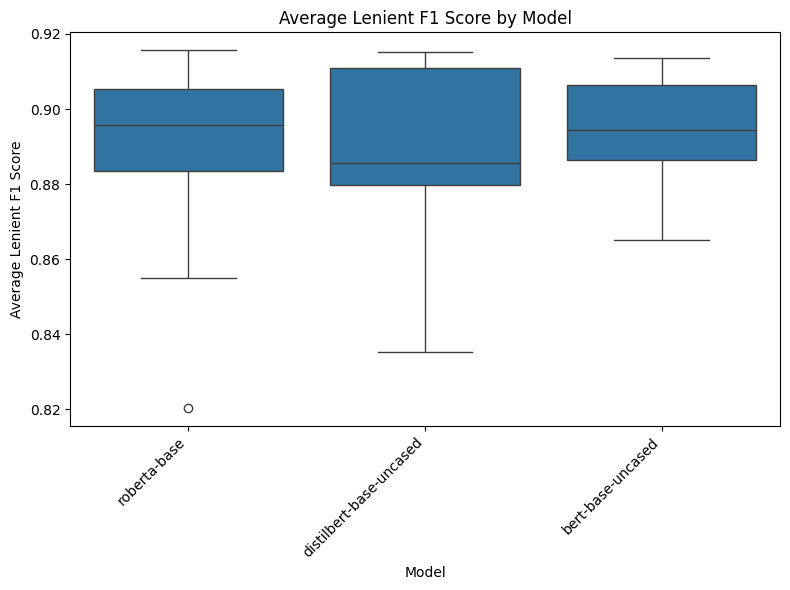

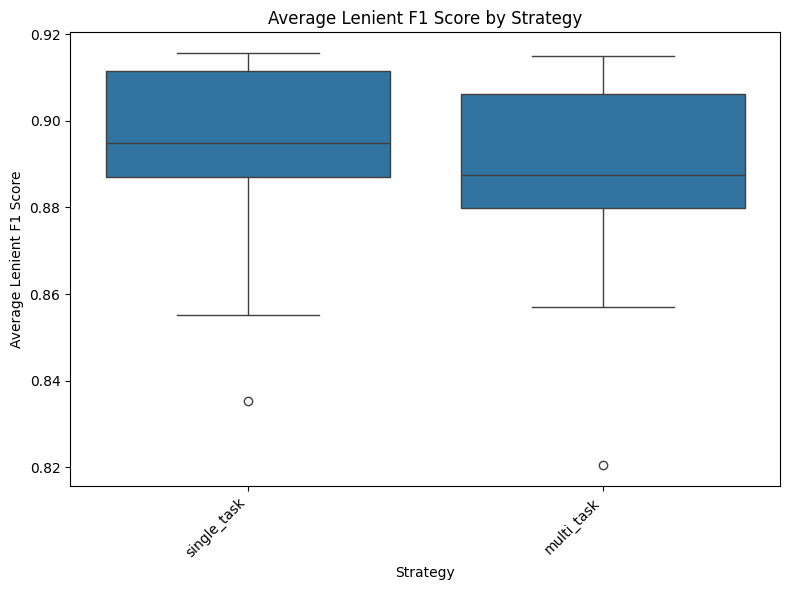

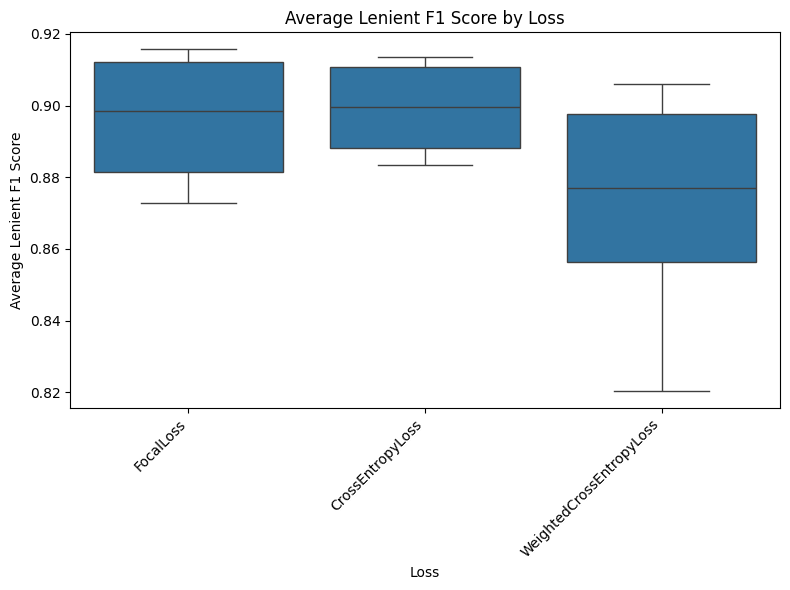

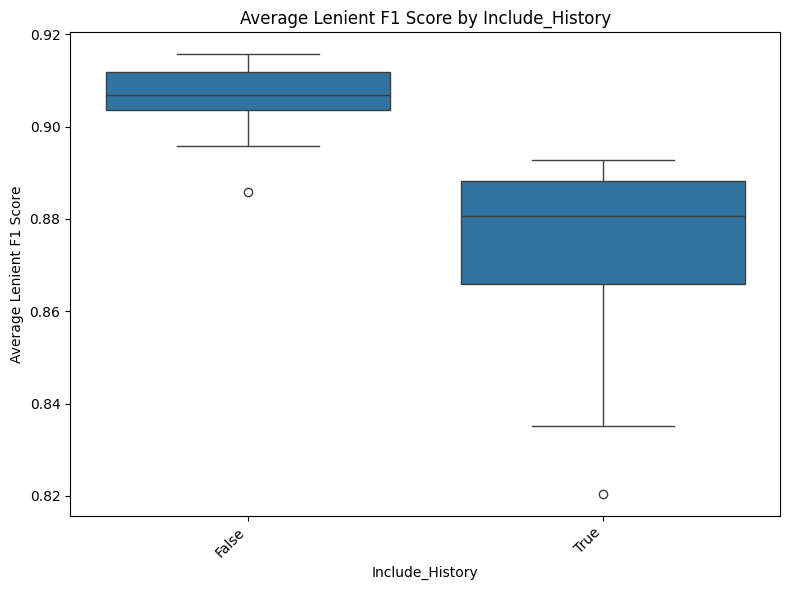

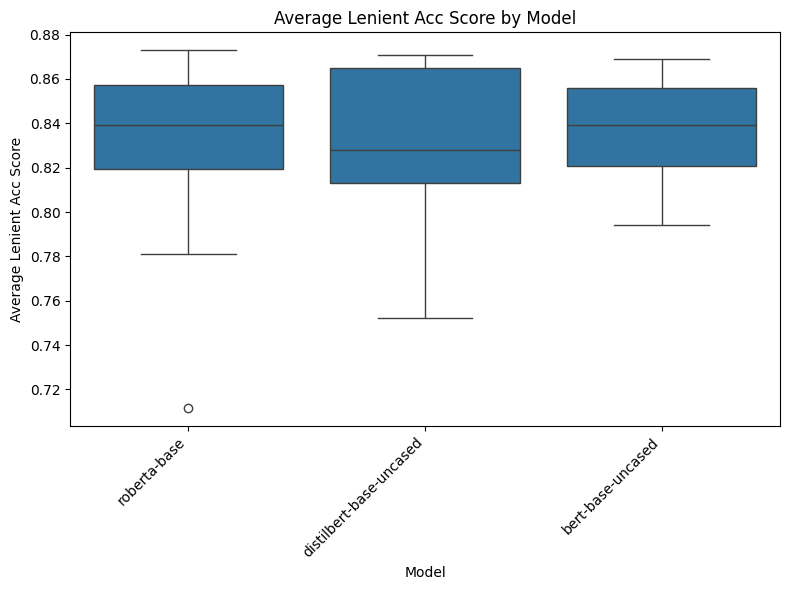

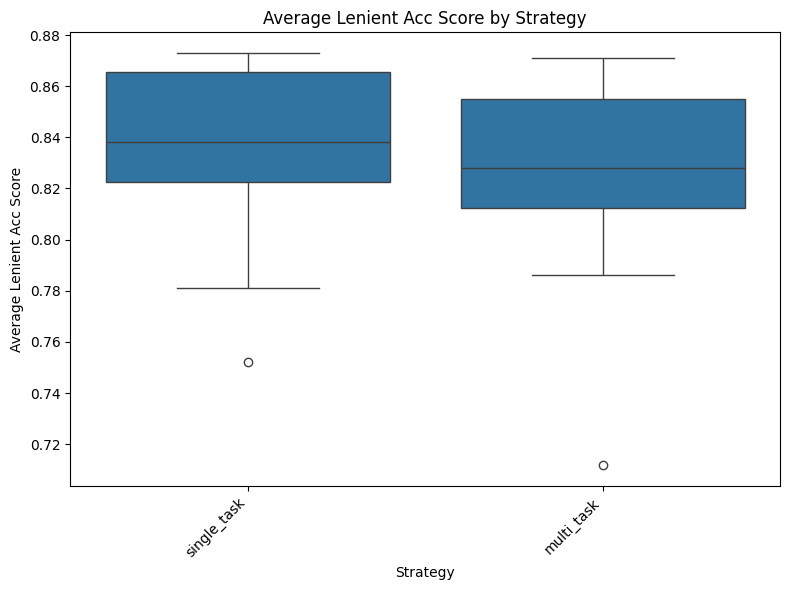

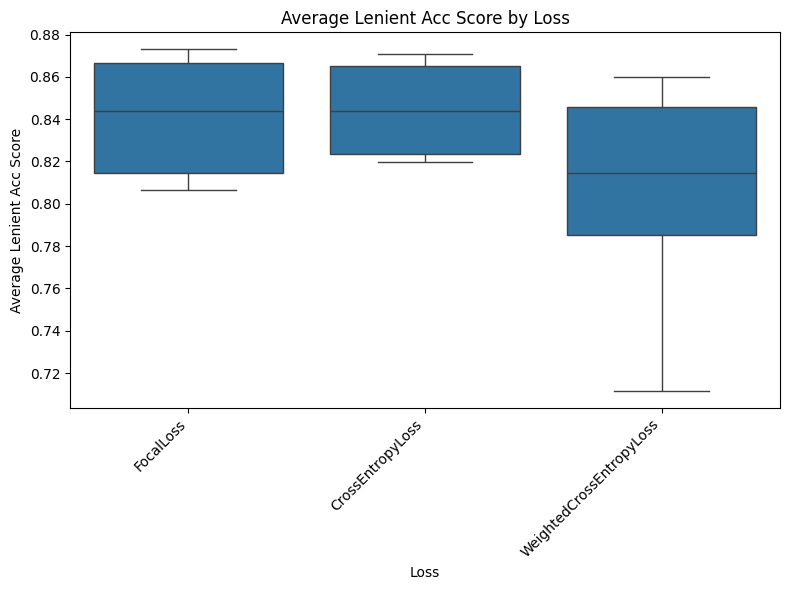

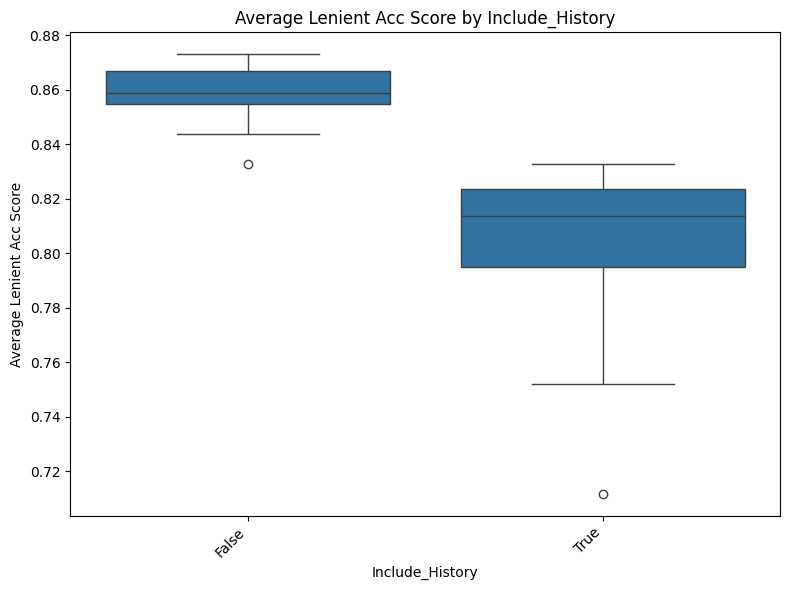

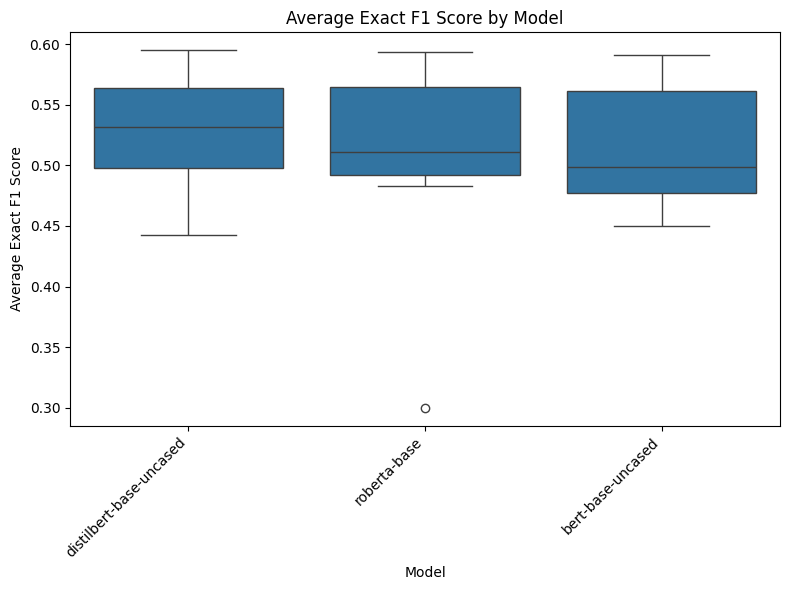

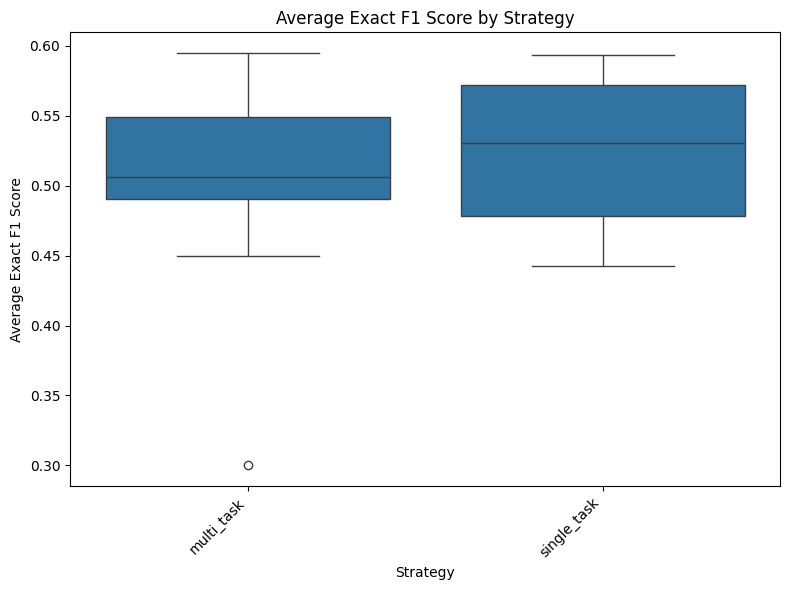

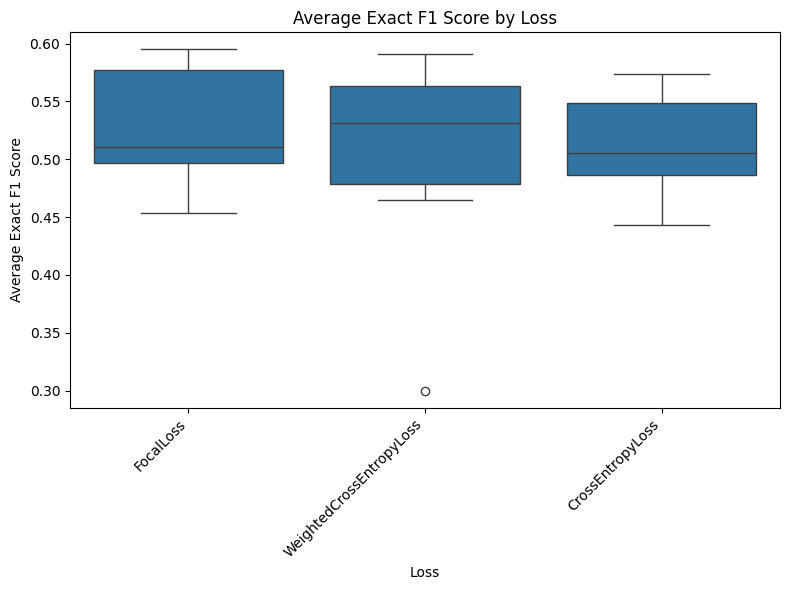

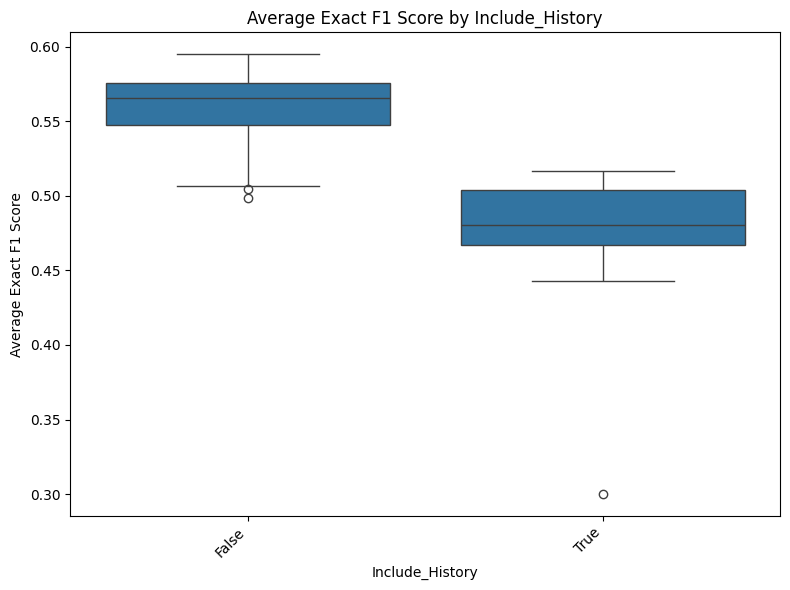

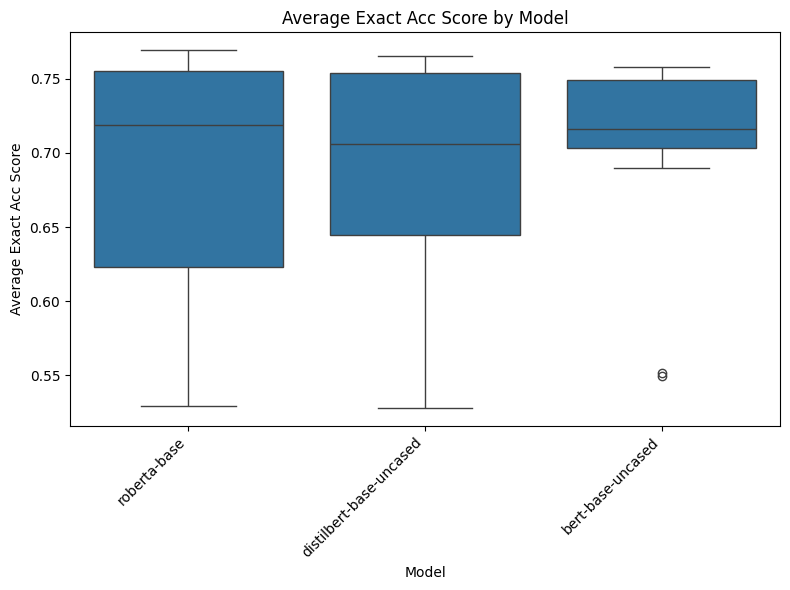

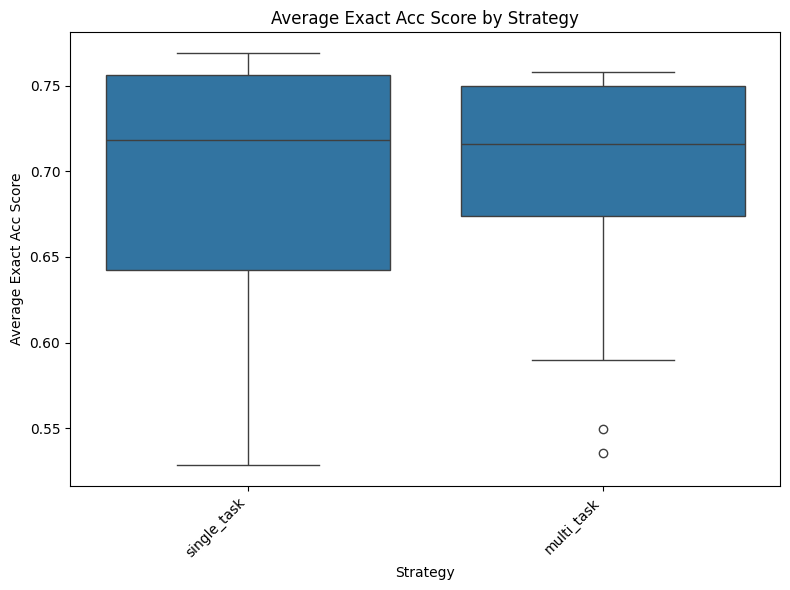

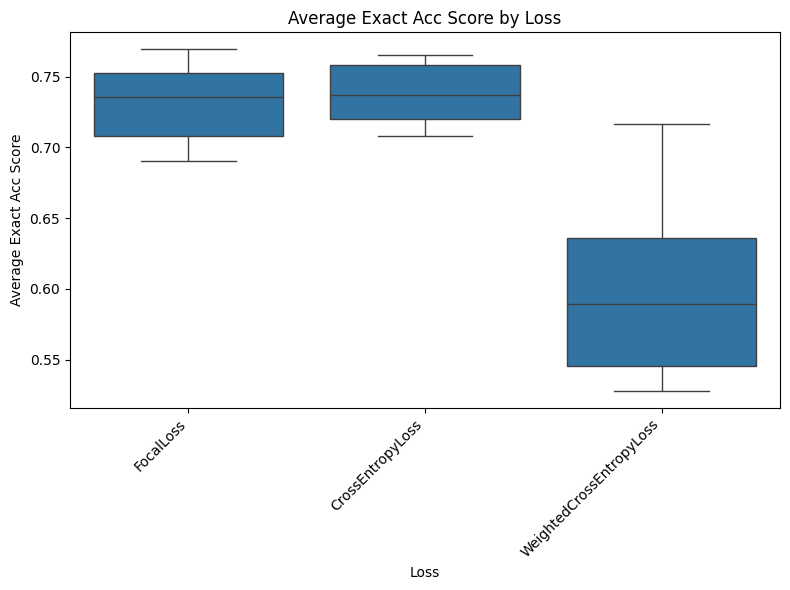

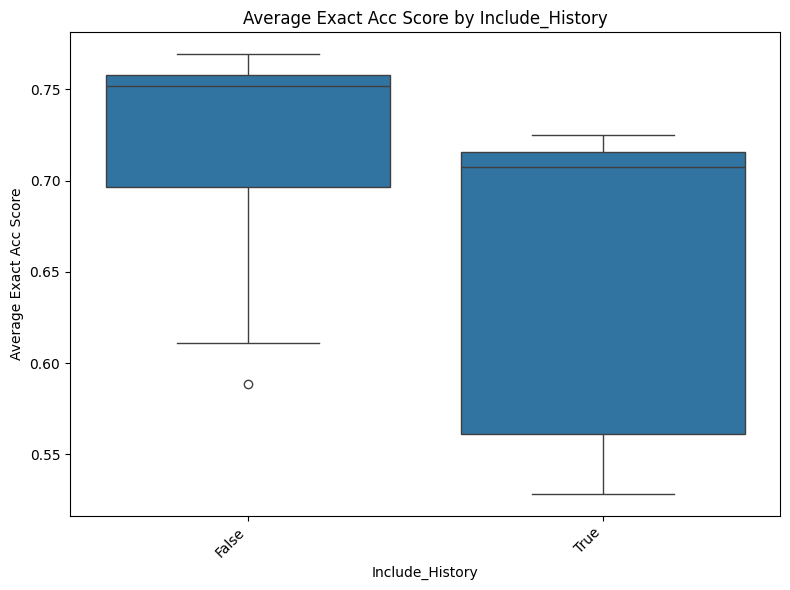

In [ ]:
# Generate box plots for each metric type
for metric_type in metric_types:
    for category in ['model', 'strategy', 'loss', 'include_history']:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=category, y=f'avg_{metric_type}', data=df_sorted[metric_type])
        plt.title(f'Average {metric_type.replace("_", " ").title()} Score by {category.title()}')
        plt.xlabel(category.title())
        plt.ylabel(f'Average {metric_type.replace("_", " ").title()} Score')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

### Final Evaluation on Test Set

In [ ]:
import torch
import torch.optim as optim
from torch.optim import AdamW
import numpy as np
import pandas as pd
import gc
import traceback
import time # Added for timing retraining
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer


print("--- Final Evaluation on Test Set ---")

# --- 1. Define Best Configuration based off whatever metric you want to optimise on (in our case avg lenient f1) ---
best_config = {
    'model': 'roberta-base',
    'strategy': 'single_task',
    'loss': 'FocalLoss',
    'include_history': False,
    'remove_punct': False,
    'remove_stopwords': False
}

best_model_name = best_config['model']
best_strategy = best_config['strategy']
best_loss_name = best_config['loss']
best_pp_flags = {
    'include_history': best_config['include_history'],
    'remove_punct': best_config['remove_punct'],
    'remove_stopwords': best_config['remove_stopwords']
}
# Define number of epochs for final retraining (can be tuned)
FINAL_TRAIN_EPOCHS = 5

print(f"Using Best Configuration: {best_config}")
print(f"Retraining for {FINAL_TRAIN_EPOCHS} epochs.")

# --- 2. Data Preparation (Train+Val / Test Split) ---
print("Preparing Train+Val and Test Dataloaders...")
final_train_df = None
test_df_final = None
final_train_loader = None
test_loader = None
tokenizer = None
try:
    stratify_col_name = TASK_LIST[0]
    stratify_col = df_raw[stratify_col_name] if stratify_col_name in df_raw.columns else None
    final_train_df, test_df_final = train_test_split(
        df_raw,
        test_size=0.1, # Use the same test_size as in create_dataloaders
        random_state=SEED,
        stratify=stratify_col
    )
    print(f"Final Train+Val size: {len(final_train_df)}, Test size: {len(test_df_final)}")

    # Load tokenizer for the best model
    tokenizer = AutoTokenizer.from_pretrained(best_model_name)

    final_train_dataset = TutorResponseDataset(final_train_df, tokenizer, MAX_LENGTH, **best_pp_flags)
    test_dataset = TutorResponseDataset(test_df_final, tokenizer, MAX_LENGTH, **best_pp_flags)

    # Create DataLoader instances
    final_train_loader = DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) # num_workers=0 might be safer
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    print("Dataloaders for final training created.")

except Exception as e:
    print(f"Error preparing data for final evaluation: {e}")
    traceback.print_exc()
    final_train_loader = None
    test_loader = None

# --- 3. Model Initialization & 4. Retraining ---
final_models = {} # Store trained models if single_task

if final_train_loader and test_loader:
    try:
        if best_strategy == 'multi_task':
            print(f"Initializing and retraining Multi-Task Model: {best_model_name}")
            model = get_model(best_strategy, best_model_name)
            if not model: raise ValueError("Model creation failed")
            model.to(DEVICE)
            optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

            # Simplified Training Loop (No Validation/Early Stopping)
            model.train()
            for epoch in range(FINAL_TRAIN_EPOCHS):
                start_time = time.time()
                total_loss = 0
                optimizer.zero_grad()
                for step, batch in enumerate(final_train_loader):
                    input_ids = batch['input_ids'].to(DEVICE)
                    attention_mask = batch['attention_mask'].to(DEVICE)
                    labels = batch['labels'].to(DEVICE) # Multi-task labels

                    # Manual loss calculation needed if using weighted/focal
                    # Forward pass - Get Logits
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
                    logits = outputs.logits

                    # Calculate Loss Manually
                    loss = 0.0
                    for i in range(NUM_TASKS):
                         task_logits = logits[i]
                         task_labels = labels[:, i]
                         task_name = TASK_LIST[i]
                         if best_loss_name == 'CrossEntropyLoss': loss_fct = nn.CrossEntropyLoss()
                         elif best_loss_name == 'WeightedCrossEntropyLoss': loss_fct = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS[task_name].to(DEVICE))
                         elif best_loss_name == 'FocalLoss': loss_fct = FocalLoss()
                         else: raise ValueError(f"Invalid loss function name: {best_loss_name}")
                         loss += loss_fct(task_logits, task_labels)
                    loss /= NUM_TASKS # Average loss

                    total_loss += loss.item()
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                    if (step + 1) % 50 == 0 or (step + 1) == len(final_train_loader): print(f"  Epoch {epoch+1}/{FINAL_TRAIN_EPOCHS}, Step {step+1}/{len(final_train_loader)}, Batch Loss: {loss.item():.4f}")

                avg_loss = total_loss / len(final_train_loader) if len(final_train_loader) > 0 else 0
                epoch_time = time.time() - start_time
                print(f"Epoch {epoch+1}/{FINAL_TRAIN_EPOCHS} | Time: {epoch_time:.2f}s | Avg Train Loss: {avg_loss:.4f}")
            final_models['multi_task_model'] = model # Store the single trained model

        elif best_strategy == 'single_task':
            print(f"Initializing and retraining Single-Task Models: {best_model_name}")
            model_creator = get_model(best_strategy, best_model_name)
            if not model_creator: raise ValueError("Model creator failed")

            for task_idx, task_name in enumerate(TASK_LIST):
                print(f"\n-- Retraining Single-Task Model for: {task_name} --")
                model = model_creator(best_model_name, NUM_CLASSES)
                if not model: raise ValueError(f"Model creation failed for {task_name}")
                model.to(DEVICE)
                optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

                # Simplified Training Loop
                model.train()
                for epoch in range(FINAL_TRAIN_EPOCHS):
                    start_time = time.time()
                    total_loss = 0
                    optimizer.zero_grad()
                    for step, batch in enumerate(final_train_loader):
                        input_ids = batch['input_ids'].to(DEVICE)
                        attention_mask = batch['attention_mask'].to(DEVICE)
                        labels = batch['labels'][:, task_idx].to(DEVICE) # Single-task labels

                        # Forward pass (model calculates loss internally for single-task HF models)
                        if best_loss_name == 'CrossEntropyLoss': loss_fct = nn.CrossEntropyLoss()
                        elif best_loss_name == 'WeightedCrossEntropyLoss': loss_fct = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS[task_name].to(DEVICE))
                        elif best_loss_name == 'FocalLoss': loss_fct = FocalLoss() # Ensure FocalLoss class is defined
                        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels, return_dict=True)
                        loss = outputs.loss

                        if loss is None: # Add check for None loss
                             print(f"Warning: Loss is None for batch {step}. Skipping batch.")
                             continue

                        total_loss += loss.item()
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()
                        if (step + 1) % 50 == 0 or (step + 1) == len(final_train_loader): print(f"  Epoch {epoch+1}/{FINAL_TRAIN_EPOCHS}, Step {step+1}/{len(final_train_loader)}, Batch Loss: {loss.item():.4f}")

                    avg_loss = total_loss / len(final_train_loader) if len(final_train_loader) > 0 else 0
                    epoch_time = time.time() - start_time
                    print(f"Epoch {epoch+1}/{FINAL_TRAIN_EPOCHS} | Time: {epoch_time:.2f}s | Avg Train Loss: {avg_loss:.4f}")
                final_models[task_name] = model # Store trained model for this task

    except Exception as e:
        print(f"Error during final model retraining: {e}")
        traceback.print_exc()
        final_models = {}


    # --- 5. Evaluation on Test Set ---
    print("\n--- Evaluating on Test Set ---")
    test_metrics = {}
    if final_models and test_loader:
        all_test_logits = {} # Store logits {task_name: [list of batch logits tensors]}
        all_labels = []

        with torch.no_grad():
            # Prepare logits structure
            if best_strategy == 'multi_task':
                for task_name in TASK_LIST: all_test_logits[task_name] = []

            # Get predictions
            if best_strategy == 'multi_task':
                # Check if the model exists before using it
                if 'multi_task_model' in final_models:
                    model = final_models['multi_task_model']
                    model.eval()
                    print("Evaluating multi-task model...")
                    for batch in test_loader:
                        input_ids = batch['input_ids'].to(DEVICE)
                        attention_mask = batch['attention_mask'].to(DEVICE)
                        batch_labels = batch['labels'].cpu() # Get labels on CPU
                        outputs = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
                        logits = outputs.logits # List of tensors
                        for i, task_name in enumerate(TASK_LIST):
                            if task_name not in all_test_logits: all_test_logits[task_name] = []
                            all_test_logits[task_name].append(logits[i].cpu())
                        all_labels.append(batch_labels) # Append labels collected during this loop
                else:
                    print("Error: Multi-task model not found in final_models.")


            elif best_strategy == 'single_task':
                 print("Collecting test labels...")
                 if not all_labels:
                      for batch in test_loader:
                           all_labels.append(batch['labels'].cpu())
                 else:
                      print("Warning: all_labels list was not empty before collecting test labels.")

                 # Evaluate each single-task model
                 for task_idx, task_name in enumerate(TASK_LIST):
                      if task_name in final_models:
                           model = final_models[task_name]
                           model.eval()
                           print(f"Evaluating single-task model for: {task_name}")
                           task_logits_list = []
                           for batch in test_loader:
                                input_ids = batch['input_ids'].to(DEVICE)
                                attention_mask = batch['attention_mask'].to(DEVICE)
                                outputs = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
                                task_logits_list.append(outputs.logits.cpu())
                           # Store the list of batch logits tensors for this task
                           all_test_logits[task_name] = task_logits_list
                      else:
                           print(f"Model for task {task_name} not found. Skipping evaluation.")


        # --- 6. Metric Calculation ---
        try:
            # Concatenate labels
            final_test_labels = torch.cat(all_labels, dim=0) if all_labels else torch.empty(0, NUM_TASKS)
            final_test_preds_logits = [] # List to hold final logit tensors for compute_metrics

            if best_strategy == 'multi_task':
                # Check if all tasks have collected logits
                if len(all_test_logits) == NUM_TASKS and all(all_test_logits.get(task) for task in TASK_LIST):
                    final_test_preds_logits = [torch.cat(all_test_logits[task], dim=0) for task in TASK_LIST]
                else:
                    print("Warning: Logits missing for some tasks in multi-task evaluation.")
            elif best_strategy == 'single_task':
                 # We need to ensure the order matches TASK_LIST for compute_metrics
                 temp_logits_list = []
                 all_tasks_present = True
                 for task_name in TASK_LIST:
                      if task_name in all_test_logits and all_test_logits[task_name]:
                           temp_logits_list.append(torch.cat(all_test_logits[task_name], dim=0))
                      else:
                           print(f"Warning: No logits found for task {task_name} in single-task evaluation.")
                           temp_logits_list.append(None) # Placeholder
                           all_tasks_present = False

                 if all_tasks_present:
                      final_test_preds_logits = temp_logits_list
                 else:
                      print("Skipping metric calculation due to missing task predictions.")


            # Calculate metrics if we have predictions and labels
            if final_test_preds_logits and final_test_labels.numel() > 0:
                 print("Calculating final test metrics...")
                 # compute_metrics expects list of logits, one per task
                 test_metrics = compute_metrics(final_test_preds_logits, final_test_labels)
            else:
                 print("Skipping final metric calculation due to missing predictions or labels.")

        except Exception as e:
            print(f"Error during final metric calculation: {e}")
            traceback.print_exc()

    # --- 7. Report---
    print("\n--- Final Test Set Performance ---")
    if test_metrics:
        avg_lenient_f1 = np.mean([m.get('lenient_f1', 0.0) for m in test_metrics.values()])
        avg_exact_f1 = np.mean([m.get('exact_f1', 0.0) for m in test_metrics.values()])
        print(f"Configuration: {best_config}")
        print(f"Average Test Lenient F1: {avg_lenient_f1:.4f}")
        print(f"Average Test Exact F1: {avg_exact_f1:.4f}")
        print("\nMetrics per Task:")
        for task_name, metrics_dict in test_metrics.items():
            print(f"  {task_name}: "
                  f"Exact Acc: {metrics_dict.get('exact_acc', 0):.4f}, "
                  f"Exact F1: {metrics_dict.get('exact_f1', 0):.4f}, "
                  f"Lenient Acc: {metrics_dict.get('lenient_acc', 0):.4f}, "
                  f"Lenient F1: {metrics_dict.get('lenient_f1', 0):.4f}")
    else:
        print("Could not calculate final test metrics.")

else:
    print("Skipping final evaluation due to errors in data preparation.")



--- Final Evaluation on Test Set ---
Using Best Configuration: {'model': 'roberta-base', 'strategy': 'single_task', 'loss': 'FocalLoss', 'include_history': False, 'remove_punct': False, 'remove_stopwords': False}
Retraining for 5 epochs.
Preparing Train+Val and Test Dataloaders...
Final Train+Val size: 2228, Test size: 248


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Dataloaders for final training created.
Initializing and retraining Single-Task Models: roberta-base
Strategy: single_task. Will load roberta-base with 3 labels per task during training.
Loading single-task model: roberta-base with 3 labels.


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



-- Retraining Single-Task Model for: Mistake_Identification --
Loading single-task model: roberta-base with 3 labels.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/5, Step 50/70, Batch Loss: 0.4881
  Epoch 1/5, Step 70/70, Batch Loss: 0.1933
Epoch 1/5 | Time: 132.17s | Avg Train Loss: 0.5940
  Epoch 2/5, Step 50/70, Batch Loss: 0.3935
  Epoch 2/5, Step 70/70, Batch Loss: 0.1847
Epoch 2/5 | Time: 134.93s | Avg Train Loss: 0.4106
  Epoch 3/5, Step 50/70, Batch Loss: 0.2162
  Epoch 3/5, Step 70/70, Batch Loss: 0.4204
Epoch 3/5 | Time: 135.20s | Avg Train Loss: 0.3310
  Epoch 4/5, Step 50/70, Batch Loss: 0.1940
  Epoch 4/5, Step 70/70, Batch Loss: 0.3634
Epoch 4/5 | Time: 134.91s | Avg Train Loss: 0.2621
  Epoch 5/5, Step 50/70, Batch Loss: 0.0509
  Epoch 5/5, Step 70/70, Batch Loss: 0.0215
Epoch 5/5 | Time: 135.06s | Avg Train Loss: 0.1935

-- Retraining Single-Task Model for: Mistake_Location --
Loading single-task model: roberta-base with 3 labels.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/5, Step 50/70, Batch Loss: 0.8696
  Epoch 1/5, Step 70/70, Batch Loss: 0.5770
Epoch 1/5 | Time: 135.08s | Avg Train Loss: 0.8296
  Epoch 2/5, Step 50/70, Batch Loss: 0.4749
  Epoch 2/5, Step 70/70, Batch Loss: 0.3096
Epoch 2/5 | Time: 135.14s | Avg Train Loss: 0.6725
  Epoch 3/5, Step 50/70, Batch Loss: 0.5990
  Epoch 3/5, Step 70/70, Batch Loss: 0.7152
Epoch 3/5 | Time: 135.00s | Avg Train Loss: 0.5720
  Epoch 4/5, Step 50/70, Batch Loss: 0.4576
  Epoch 4/5, Step 70/70, Batch Loss: 0.3566
Epoch 4/5 | Time: 134.81s | Avg Train Loss: 0.4616
  Epoch 5/5, Step 50/70, Batch Loss: 0.3499
  Epoch 5/5, Step 70/70, Batch Loss: 0.5807
Epoch 5/5 | Time: 134.92s | Avg Train Loss: 0.3456

-- Retraining Single-Task Model for: Providing_Guidance --
Loading single-task model: roberta-base with 3 labels.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/5, Step 50/70, Batch Loss: 0.8455
  Epoch 1/5, Step 70/70, Batch Loss: 0.7687
Epoch 1/5 | Time: 134.87s | Avg Train Loss: 0.9269
  Epoch 2/5, Step 50/70, Batch Loss: 0.6294
  Epoch 2/5, Step 70/70, Batch Loss: 0.8441
Epoch 2/5 | Time: 134.82s | Avg Train Loss: 0.7854
  Epoch 3/5, Step 50/70, Batch Loss: 0.7000
  Epoch 3/5, Step 70/70, Batch Loss: 0.7080
Epoch 3/5 | Time: 134.76s | Avg Train Loss: 0.6696
  Epoch 4/5, Step 50/70, Batch Loss: 0.6879
  Epoch 4/5, Step 70/70, Batch Loss: 0.8797
Epoch 4/5 | Time: 135.07s | Avg Train Loss: 0.5525
  Epoch 5/5, Step 50/70, Batch Loss: 0.3991
  Epoch 5/5, Step 70/70, Batch Loss: 0.6825
Epoch 5/5 | Time: 134.79s | Avg Train Loss: 0.3919

-- Retraining Single-Task Model for: Actionability --
Loading single-task model: roberta-base with 3 labels.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/5, Step 50/70, Batch Loss: 0.7987
  Epoch 1/5, Step 70/70, Batch Loss: 0.6569
Epoch 1/5 | Time: 134.83s | Avg Train Loss: 0.8770
  Epoch 2/5, Step 50/70, Batch Loss: 0.4739
  Epoch 2/5, Step 70/70, Batch Loss: 0.5706
Epoch 2/5 | Time: 134.89s | Avg Train Loss: 0.6790
  Epoch 3/5, Step 50/70, Batch Loss: 0.6892
  Epoch 3/5, Step 70/70, Batch Loss: 0.3390
Epoch 3/5 | Time: 134.91s | Avg Train Loss: 0.5646
  Epoch 4/5, Step 50/70, Batch Loss: 0.4450
  Epoch 4/5, Step 70/70, Batch Loss: 0.6804
Epoch 4/5 | Time: 135.15s | Avg Train Loss: 0.4890
  Epoch 5/5, Step 50/70, Batch Loss: 0.3326
  Epoch 5/5, Step 70/70, Batch Loss: 0.4837
Epoch 5/5 | Time: 135.03s | Avg Train Loss: 0.3858

--- Evaluating on Test Set ---
Evaluating single-task model for: Mistake_Identification
Evaluating single-task model for: Mistake_Location
Evaluating single-task model for: Providing_Guidance
Evaluating single-task model for: Actionability
Calculating final test metrics...

--- Final Test Set Performanc

### Final Test Set Performance

#### Configuration:
- **Model**: roberta-base
- **Strategy**: single_task
- **Loss**: FocalLoss
- **Include History**: False
- **Remove Punctuation**: False
- **Remove Stopwords**: False

#### Average Metrics Across Tasks:
- **Average Test Lenient F1**: 0.8982
- **Average Test Exact F1**: 0.6018

#### Metrics per Task:

| Task                  | Exact Acc | Exact F1 | Lenient Acc | Lenient F1 |
|-----------------------|-----------|----------|-------------|------------|
| Mistake_Identification | 0.8750    | 0.6727   | 0.9395      | 0.9649     |
| Mistake_Location      | 0.6815    | 0.4783   | 0.7863      | 0.8616     |
| Providing_Guidance    | 0.6250    | 0.5924   | 0.7944      | 0.8661     |
| Actionability         | 0.7298    | 0.6637   | 0.8629      | 0.9000     |


### Model Interpretability (Examples)
Understanding why a model makes certain predictions is crucial, especially for evaluating fairness, identifying biases or shortcuts, and building trust. Here we explore two common techniques:

1. LIME (Local Interpretable Model-agnostic Explanations):

  - Idea: Explains individual predictions by learning a simpler, interpretable model (like linear regression) locally around the prediction. It perturbs the input text (e.g., removing words) and sees how the model's output probability changes, assigning importance scores to words based on their impact.

  - Use Case: Good for understanding which words in a specific tutor response contributed most to predicting a certain label (e.g., why was "Actionability" predicted as "Yes"?).


2. Attention Visualization (using BertViz):

  - Idea: Transformers rely on attention mechanisms, where tokens "attend" to other tokens to build contextual representations. BertViz allows visualizing these attention patterns, showing which words the model focused on when processing the input. This can be done head-by-head and layer-by-layer.

  - Use Case: Helps understand the model's internal reasoning process. Does it focus on specific keywords ("hint", "next", "wrong")? Does attention flow logically between the history (if included) and the response?



The following cell provides example code snippets for setting up and using these tools. We would  run this on our final, best-performing model

In [ ]:
# --- Prerequisites ---
# 1. a trained model instance should be ready.
#    We'll try to use the model from the 'final_models' dict created in previous Cell
#    Need to choose ONE model (e.g., the multi-task model or one single-task model).
# 2. corresponding tokenizer should be available.
# 3. Install required libraries below:

!pip install lime bertviz ipywidgets # ipywidgets often needed for bertviz display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 7.0 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=80986724b216aa1395db5327ba669e70d7320296c8a19405402b5a6726c85590
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
# --- Interpretability ---
# Note: Run this cell after (Final Evaluation) has successfully run and a trained model instance is there.

print("--- Model Interpretability Examples ---")
import torch
import torch.nn.functional as F
import numpy as np
import traceback

# --- Select Model and Tokenizer ---
selected_model_for_interpret = None
selected_tokenizer_for_interpret = None
model_interpret_strategy = None
model_interpret_task_idx = None

if 'final_models' in locals() and final_models:
    if best_strategy == 'multi_task' and 'multi_task_model' in final_models:
        selected_model_for_interpret = final_models['multi_task_model']
        model_interpret_strategy = 'multi_task'
        print("Using the trained Multi-Task model for interpretability.")
    elif best_strategy == 'single_task':
        # Choose one of the single-task models, e.g., the first one trained
        first_task_name = TASK_LIST[3]
        if first_task_name in final_models:
            selected_model_for_interpret = final_models[first_task_name]
            model_interpret_strategy = 'single_task'
            model_interpret_task_idx = 0 # Index corresponding to the chosen task
            print(f"Using the trained Single-Task model for '{first_task_name}' for interpretability.")
        else:
            print("Could not find a trained single-task model in final_models.")
    else:
         print("Could not identify a suitable trained model in final_models.")

    if 'best_config' in locals():
         try:
             selected_tokenizer_for_interpret = AutoTokenizer.from_pretrained(best_config['model'])
             print(f"Loaded tokenizer: {best_config['model']}")
         except Exception as e:
              print(f"Could not load tokenizer {best_config['model']}: {e}")
    else:
         print("best_config not found, cannot determine tokenizer to load.")

else:
    print("Warning: 'final_models' dictionary not found or empty. Cannot perform interpretability.")


# === LIME Example ===
if selected_model_for_interpret and selected_tokenizer_for_interpret:
    print("\n--- LIME Interpretability ---")
    try:
        import lime
        import lime.lime_text
        from lime.lime_text import LimeTextExplainer

        print("LIME library imported successfully.")

        # --- Define the LIME predictor function ---
        def lime_predictor(texts):
            selected_model_for_interpret.eval() # Ensure model is in eval mode
            selected_model_for_interpret.to(DEVICE)

            # Use preprocessing settings from the best config
            current_pp_flags = best_pp_flags if 'best_pp_flags' in locals() else \
                              {'include_history': False, 'remove_punct': False, 'remove_stopwords': False}

            processed_texts = []
            for text in texts:
                 # Apply basic cleaning if used during training
                 cleaned_text = clean_text(text,
                                           remove_punct=current_pp_flags['remove_punct'],
                                           remove_stopwords=current_pp_flags['remove_stopwords'])
                 # Don't include history for LIME input for clearer attribution
                 processed_texts.append(cleaned_text)


            # Tokenize the texts
            inputs = selected_tokenizer_for_interpret(
                processed_texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=MAX_LENGTH # Use the same max length
            )
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

            # Get model predictions (logits)
            with torch.no_grad():
                outputs = selected_model_for_interpret(**inputs, return_dict=True)
                logits = outputs.logits # Tensor for single-task, List for multi-task

            # Convert logits to probabilities using Softmax
            if model_interpret_strategy == 'multi_task':
                 # Choose ONE task to explain, e.g., the first one
                 task_idx_to_explain = 1
                 print(f"LIME: Explaining Task: {TASK_LIST[task_idx_to_explain]}")
                 probs = F.softmax(logits[task_idx_to_explain], dim=-1).cpu().numpy()
            elif model_interpret_strategy == 'single_task':
                 print(f"LIME: Explaining Task: {TASK_LIST[model_interpret_task_idx]}")     # Single-task model already outputs logits for its specific task
                 probs = F.softmax(logits, dim=-1).cpu().numpy()
            else:
                 return np.zeros((len(texts), NUM_CLASSES))

            return probs

        # --- Create LIME Explainer ---
        # Class names corresponding to model output indices [0, 1, 2]
        class_names = [INV_LABEL_MAP[i] for i in range(NUM_CLASSES)]
        explainer = LimeTextExplainer(class_names=class_names)

        # --- Explain an Instance ---
        if 'test_df_final' in locals() and not test_df_final.empty:
             idx_to_explain = 0 # Explain the first test sample
             text_to_explain = test_df_final.iloc[idx_to_explain]['response'] # Use only response for clarity
             print(f"\nExplaining text instance (Index {idx_to_explain}):\n'{text_to_explain}'")

             # Generate explanation (explain for all 3 classes)
             explanation = explainer.explain_instance(
                 text_to_explain,
                 lime_predictor,
                 num_features=10, # Show top 10 important words
                 num_samples=1000, # Number of perturbations LIME creates
                 top_labels=3
             )

             # Show explanation in notebook (and save to HTML)
             explanation.show_in_notebook(text=True)
             explanation.save_to_file(f'lime_explanation_{first_task_name}_{idx_to_explain}.html')

        else:
             print("Cannot run LIME example: Test data not available.")

    except ImportError:
        print("LIME library not found. Please install it: pip install lime")
    except Exception as e:
        print(f"An error occurred during LIME execution: {e}")
        traceback.print_exc()

# === BertViz Example ===
if selected_model_for_interpret and selected_tokenizer_for_interpret:
    print("\n--- BertViz Attention Visualization ---")
    # Check if the selected model is transformer-based (needed for attention)
    is_transformer = hasattr(selected_model_for_interpret, 'base_model') or \
                     isinstance(selected_model_for_interpret, (transformers.BertForSequenceClassification,
                                                                transformers.DistilBertForSequenceClassification,
                                                                transformers.RobertaForSequenceClassification))
    if is_transformer:
        try:
            from bertviz import head_view, model_view
            from IPython.display import display

            print("BertViz library imported successfully.")

            # --- Prepare Input and Get Attention Weights ---
            # Select a sample text
            if 'test_df_final' in locals() and not test_df_final.empty:
                 idx_to_viz = 1 # Visualize attention for the second test sample
                 text_to_viz = test_df_final.iloc[idx_to_viz]['response']
                 history_to_viz = test_df_final.iloc[idx_to_viz]['conversation_history']

                 # Use preprocessing consistent with how the model was trained (e.g., include history?)
                 current_pp_flags = best_pp_flags if 'best_pp_flags' in locals() else \
                                   {'include_history': False, 'remove_punct': False, 'remove_stopwords': False}

                 cleaned_response = clean_text(text_to_viz, current_pp_flags['remove_punct'], current_pp_flags['remove_stopwords'])
                 if current_pp_flags['include_history']:
                      cleaned_history = clean_text(history_to_viz, current_pp_flags['remove_punct'], current_pp_flags['remove_stopwords'])
                      sep_token = selected_tokenizer_for_interpret.sep_token if selected_tokenizer_for_interpret.sep_token else " "
                      final_text_viz = cleaned_history + sep_token + cleaned_response
                 else:
                      final_text_viz = cleaned_response

                 print(f"\nVisualizing attention for text instance (Index {idx_to_viz}):\n'{final_text_viz[:500]}...'") # Print start of text

                 # Tokenize
                 inputs = selected_tokenizer_for_interpret(
                     final_text_viz,
                     return_tensors="pt",
                     truncation=True,
                     max_length=MAX_LENGTH # Use appropriate max length
                 )
                 tokens = selected_tokenizer_for_interpret.convert_ids_to_tokens(inputs['input_ids'][0])
                 inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

                 selected_model_for_interpret.eval()
                 selected_model_for_interpret.to(DEVICE)
                 with torch.no_grad():
                      outputs = selected_model_for_interpret(**inputs, output_attentions=True, return_dict=True)

                 attention_weights = outputs.attentions

                 # --- Display Attention using BertViz ---
                 print("Displaying BertViz Head View (requires model with attention output)...")
                 # head_view needs attentions and tokens
                 display(head_view(attention_weights, tokens))

            else:
                 print("Cannot run BertViz example: Test data not available.")

        except ImportError:
            print("BertViz library not found. Please install it: pip install bertviz")
        except AttributeError:
             print("Model output does not contain 'attentions'. Ensure 'output_attentions=True' is passed during forward call.")
        except Exception as e:
            print(f"An error occurred during BertViz execution: {e}")
            traceback.print_exc()
    else:
        print("Selected model does not appear to be a standard transformer model with attention. Skipping BertViz.")

# Final cleanup
print("\n--- Interpretability Examples Complete ---")
if 'selected_model_for_interpret' in locals(): del selected_model_for_interpret
if 'selected_tokenizer_for_interpret' in locals(): del selected_tokenizer_for_interpret
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

--- Model Interpretability Examples ---
Using the trained Single-Task model for 'Actionability' for interpretability.
Loaded tokenizer: roberta-base

--- LIME Interpretability ---
LIME library imported successfully.

Explaining text instance (Index 0):
'It looks like there's still a bit of confusion. You should subtract 245 from the total time Frank could spend in all mazes (300 minutes), not from 60. Try that and see what you get.'
LIME: Explaining Task: Mistake_Identification


RobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.



--- BertViz Attention Visualization ---
BertViz library imported successfully.

Visualizing attention for text instance (Index 1):
'great job! to further enhance your understanding, let's explore more examples and practice solving similar problems together....'
Displaying BertViz Head View (requires model with attention output)...


<IPython.core.display.Javascript object>

None


--- Interpretability Examples Complete ---


## Interpretability : Actionability
### Observations
- Key tokens: "Try", "what", "subtract", "should"
- These indicate explicit **next actions**: suggesting the student rework the problem by subtracting and **trying again.**

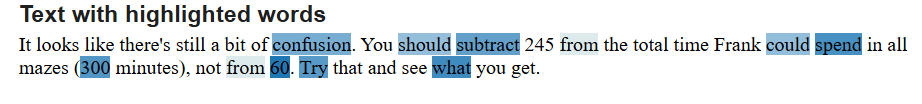

### Experimentation with larger MAX_LEN and better models like ELECTRA
- Now, that we know which loss function, which preprocessing configs, which strategy works the best for these tasks, we can improve upon our model to actually see how it performs - does it increase performance ?

In [ ]:
import torch
import torch.nn as nn # Ensure nn is imported for loss functions
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import DataLoader # Ensure DataLoader is imported
import numpy as np
import pandas as pd
import gc
import traceback
import time
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

BATCH_SIZE = 16
print("--- Final Evaluation on Test Set ---")
print(f"Using BATCH SIZE : {BATCH_SIZE}")

# --- 1. Define Best Configuration ---
# Examples: 'google/electra-base-discriminator', 'microsoft/deberta-v3-base', 'xlnet-base-cased'
best_config = {
    'model': 'google/electra-base-discriminator',
    'strategy': 'single_task',
    'loss': 'FocalLoss',
    'include_history': False,
    'remove_punct': False,
    'remove_stopwords': False
}
# Extract relevant parts for functions
best_model_name = best_config['model']
best_strategy = best_config['strategy']
best_loss_name = best_config['loss']
best_pp_flags = {
    'include_history': best_config['include_history'],
    'remove_punct': best_config['remove_punct'],
    'remove_stopwords': best_config['remove_stopwords']
}
# Define number of epochs for final retraining
FINAL_TRAIN_EPOCHS = 5

print(f"Using Best Configuration: {best_config}")
print(f"Retraining for {FINAL_TRAIN_EPOCHS} epochs.")

# --- 2. Data Preparation (Train+Val / Test Split) ---
print("Preparing Train+Val and Test Dataloaders...")
final_train_df = None
test_df_final = None
final_train_loader = None
test_loader = None
tokenizer = None
try:
    stratify_col_name = TASK_LIST[0] if TASK_LIST else None
    stratify_col = df_raw[stratify_col_name] if stratify_col_name and stratify_col_name in df_raw.columns else None

    # Split data into Train+Validation and Test
    final_train_df, test_df_final = train_test_split(
        df_raw,
        test_size=0.1,
        random_state=SEED,
        stratify=stratify_col
    )
    print(f"Final Train+Val size: {len(final_train_df)}, Test size: {len(test_df_final)}")

    # Load tokenizer for the chosen model
    print(f"Loading tokenizer for: {best_model_name}")
    tokenizer = AutoTokenizer.from_pretrained(best_model_name)

    # Create Dataset instancesly
    print("Creating Dataset instances...")
    final_train_dataset = TutorResponseDataset(final_train_df, tokenizer, MAX_LENGTH, **best_pp_flags)
    test_dataset = TutorResponseDataset(test_df_final, tokenizer, MAX_LENGTH, **best_pp_flags)
    print("Dataset instances created.")

    # Create DataLoader instances
    print("Creating DataLoader instances...")
    final_train_loader = DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    print("Dataloaders for final training created.")

except Exception as e:
    print(f"Error preparing data for final evaluation: {e}")
    traceback.print_exc()
    final_train_loader = None
    test_loader = None

# --- 3. Model Initialization & 4. Retraining ---
final_models = {} # Store trained models {task_name: model} or {'multi_task_model': model}
# final_history = {}

if final_train_loader and test_loader:
    try:
        if best_strategy == 'multi_task':
            print(f"Initializing and retraining Multi-Task Model: {best_model_name}")
            # get_model should return the instantiated multi-task model
            model = get_model(best_strategy, best_model_name)
            if not model: raise ValueError("Multi-task model creation failed")
            model.to(DEVICE)
            optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

            # Simplified Training Loop (No Validation/Early Stopping for final train)
            model.train()
            for epoch in range(FINAL_TRAIN_EPOCHS):
                start_time = time.time()
                total_loss = 0
                for step, batch in enumerate(final_train_loader):
                    optimizer.zero_grad()
                    input_ids = batch['input_ids'].to(DEVICE)
                    attention_mask = batch['attention_mask'].to(DEVICE)
                    labels = batch['labels'].to(DEVICE) # Shape: [batch_size, num_tasks]

                    # Forward pass - Get Logits (list of tensors for multi-task)
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
                    logits = outputs.logits # List of tensors [task1_logits, task2_logits, ...]

                    # Calculate Loss Manually based on best_loss_name
                    loss = 0.0
                    for i in range(NUM_TASKS):
                        task_logits = logits[i]
                        task_labels = labels[:, i]
                        task_name = TASK_LIST[i]

                        # Select the appropriate loss function
                        if best_loss_name == 'CrossEntropyLoss':
                            loss_fct = nn.CrossEntropyLoss()
                        elif best_loss_name == 'WeightedCrossEntropyLoss':
                            if CLASS_WEIGHTS and task_name in CLASS_WEIGHTS:
                                loss_fct = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS[task_name].to(DEVICE))
                            else:
                                print(f"Warning: CLASS_WEIGHTS not found for {task_name}. Using unweighted CE Loss.")
                                loss_fct = nn.CrossEntropyLoss()
                        elif best_loss_name == 'FocalLoss':
                            # Ensure FocalLoss class is defined and instantiated correctly
                            loss_fct = FocalLoss() # Add parameters if needed: FocalLoss(alpha=..., gamma=...)
                        else:
                            raise ValueError(f"Invalid loss function name: {best_loss_name}")

                        loss += loss_fct(task_logits, task_labels)

                    loss /= NUM_TASKS # Average loss across tasks

                    if torch.isnan(loss): # Check for NaN loss
                       print(f"Warning: NaN loss detected at Epoch {epoch+1}, Step {step+1}. Skipping batch.")
                       optimizer.zero_grad() # Ensure grads are zeroed before next batch
                       continue # Skip backward and step

                    total_loss += loss.item()
                    loss.backward()
                    # Optional: Gradient Clipping
                    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    # optimizer.zero_grad() # Zero grad moved to the start of the loop

                    if (step + 1) % 50 == 0 or (step + 1) == len(final_train_loader):
                        print(f"  Epoch {epoch+1}/{FINAL_TRAIN_EPOCHS}, Step {step+1}/{len(final_train_loader)}, Batch Loss: {loss.item():.4f}")

                avg_loss = total_loss / len(final_train_loader) if len(final_train_loader) > 0 else 0
                epoch_time = time.time() - start_time
                print(f"Epoch {epoch+1}/{FINAL_TRAIN_EPOCHS} | Time: {epoch_time:.2f}s | Avg Train Loss: {avg_loss:.4f}")

            final_models['multi_task_model'] = model # Store the single trained model

        elif best_strategy == 'single_task':
            print(f"Initializing and retraining Single-Task Models: {best_model_name}")
            # get_model should return the creator function for single-task
            model_creator = get_model(best_strategy, best_model_name)
            if not model_creator: raise ValueError("Single-task model creator function failed")

            for task_idx, task_name in enumerate(TASK_LIST):
                print(f"\n-- Retraining Single-Task Model for: {task_name} --")
                # Create a fresh model instance for each task
                model = model_creator(best_model_name, NUM_CLASSES)
                if not model: raise ValueError(f"Model creation failed for {task_name}")
                model.to(DEVICE)
                optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

                # Simplified Training Loop
                model.train()
                for epoch in range(FINAL_TRAIN_EPOCHS):
                    start_time = time.time()
                    total_loss = 0
                    for step, batch in enumerate(final_train_loader):
                        optimizer.zero_grad()
                        input_ids = batch['input_ids'].to(DEVICE)
                        attention_mask = batch['attention_mask'].to(DEVICE)
                        labels = batch['labels'][:, task_idx].to(DEVICE) # Get labels for the specific task

                        # Forward pass to get logits
                        outputs = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
                        logits = outputs.logits

                        # Calculate loss based on best_loss_name
                        if best_loss_name == 'CrossEntropyLoss':
                            loss_fct = nn.CrossEntropyLoss()
                        elif best_loss_name == 'WeightedCrossEntropyLoss':
                             if CLASS_WEIGHTS and task_name in CLASS_WEIGHTS:
                                loss_fct = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS[task_name].to(DEVICE))
                             else:
                                print(f"Warning: CLASS_WEIGHTS not found for {task_name}. Using unweighted CE Loss.")
                                loss_fct = nn.CrossEntropyLoss()
                        elif best_loss_name == 'FocalLoss':
                            loss_fct = FocalLoss() # Add parameters if needed
                        else:
                            raise ValueError(f"Invalid loss function name: {best_loss_name}")

                        loss = loss_fct(logits, labels)
                        # --- End Manual Loss Calculation ---

                        if torch.isnan(loss): # Check for NaN loss
                           print(f"Warning: NaN loss detected at Epoch {epoch+1}, Step {step+1} (Task: {task_name}). Skipping batch.")
                           optimizer.zero_grad() # Ensure grads are zeroed before next batch
                           continue # Skip backward and step

                        total_loss += loss.item()
                        loss.backward()
                        # Optional: Gradient Clipping
                        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        optimizer.step()
                        # optimizer.zero_grad() # Zero grad moved to start

                        if (step + 1) % 50 == 0 or (step + 1) == len(final_train_loader):
                             print(f"  Epoch {epoch+1}/{FINAL_TRAIN_EPOCHS}, Step {step+1}/{len(final_train_loader)}, Batch Loss: {loss.item():.4f}")

                    avg_loss = total_loss / len(final_train_loader) if len(final_train_loader) > 0 else 0
                    epoch_time = time.time() - start_time
                    print(f"Epoch {epoch+1}/{FINAL_TRAIN_EPOCHS} | Time: {epoch_time:.2f}s | Avg Train Loss: {avg_loss:.4f}")

                final_models[task_name] = model # Store trained model for this task
                # Optional: Clean up GPU memory if needed between tasks
                del model, optimizer
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error during final model retraining: {e}")
        traceback.print_exc()
        final_models = {} # Clear models if error occurred
        # Optional: Clean up GPU memory after failure
        # gc.collect()
        # torch.cuda.empty_cache()


    # --- 5. Evaluation on Test Set ---
    print("\n--- Evaluating on Test Set ---")
    test_metrics = {}
    if final_models and test_loader:
        all_test_logits = {} # Store logits {task_name: [list of batch logits tensors]}
        all_labels_list = [] # Store list of label tensors from each batch

        with torch.no_grad():
            # --- Collect all labels first (needed for both strategies) ---
            print("Collecting all test labels...")
            for batch in test_loader:
                all_labels_list.append(batch['labels'].cpu()) # Store labels on CPU
            if not all_labels_list:
                 print("Error: No labels collected from the test loader.")
                 final_test_labels = torch.empty(0, NUM_TASKS) # Create empty tensor
            else:
                 final_test_labels = torch.cat(all_labels_list, dim=0)
            print(f"Collected labels shape: {final_test_labels.shape}")


            # --- Get predictions ---
            if best_strategy == 'multi_task':
                if 'multi_task_model' in final_models:
                    model = final_models['multi_task_model']
                    model.eval()
                    print("Evaluating multi-task model...")
                    # Initialize lists for logits for each task
                    for task_name in TASK_LIST: all_test_logits[task_name] = []

                    for batch in test_loader:
                        input_ids = batch['input_ids'].to(DEVICE)
                        attention_mask = batch['attention_mask'].to(DEVICE)
                        # Labels already collected, no need for batch['labels'] here
                        outputs = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
                        logits = outputs.logits # List of tensors
                        for i, task_name in enumerate(TASK_LIST):
                            if i < len(logits): # Safety check
                                all_test_logits[task_name].append(logits[i].cpu())
                            else:
                                print(f"Warning: Missing logit output for task {i} ({task_name}) in multi-task batch.")
                else:
                    print("Error: Multi-task model not found in final_models for evaluation.")

            elif best_strategy == 'single_task':
                # Evaluate each single-task model
                for task_idx, task_name in enumerate(TASK_LIST):
                    if task_name in final_models:
                        model = final_models[task_name]
                        model.eval()
                        print(f"Evaluating single-task model for: {task_name}")
                        task_logits_list = []
                        for batch in test_loader:
                            input_ids = batch['input_ids'].to(DEVICE)
                            attention_mask = batch['attention_mask'].to(DEVICE)
                            # Labels already collected
                            outputs = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
                            task_logits_list.append(outputs.logits.cpu()) # Append logits tensor on CPU
                        # Store the list of batch logits tensors for this task
                        all_test_logits[task_name] = task_logits_list
                    else:
                        print(f"Model for task {task_name} not found. Skipping evaluation for this task.")


        # --- 6. Metric Calculation ---
        try:
            # Concatenate logits for each task
            final_test_preds_logits = [] # List to hold final concatenated logit tensors
            all_tasks_have_logits = True

            for task_name in TASK_LIST:
                if task_name in all_test_logits and all_test_logits[task_name]:
                    # Concatenate the list of batch logit tensors into one tensor for the task
                    concatenated_logits = torch.cat(all_test_logits[task_name], dim=0)
                    final_test_preds_logits.append(concatenated_logits)
                    print(f"Logits shape for task {task_name}: {concatenated_logits.shape}")
                else:
                    print(f"Warning: Logits missing or empty for task '{task_name}'. Cannot calculate metrics for this task.")
                    final_test_preds_logits.append(None) # Add placeholder
                    all_tasks_have_logits = False # Mark that not all tasks are present

            # Check if the number of predictions matches the number of labels
            if final_test_preds_logits and final_test_preds_logits[0] is not None and final_test_preds_logits[0].shape[0] != final_test_labels.shape[0]:
                 print(f"Warning: Mismatch between number of predictions ({final_test_preds_logits[0].shape[0]}) and labels ({final_test_labels.shape[0]}). Metrics might be incorrect.")
                 # Decide how to handle: maybe skip metric calculation or try to debug the mismatch
                 all_tasks_have_logits = False # Treat as incomplete

            # Calculate metrics only if we have labels and logits for ALL tasks
            # (compute_metrics likely expects logits for all tasks)
            # Modify this if your compute_metrics can handle missing tasks
            if all_tasks_have_logits and final_test_labels.numel() > 0:
                print("Calculating final test metrics...")
                # Ensure compute_metrics handles a list of tensors (one per task)
                test_metrics = compute_metrics(final_test_preds_logits, final_test_labels)
            elif final_test_labels.numel() == 0:
                 print("Skipping final metric calculation because no test labels were collected.")
            else:
                print("Skipping final metric calculation due to missing predictions for one or more tasks or label/prediction count mismatch.")

        except Exception as e:
            print(f"Error during final metric calculation: {e}")
            traceback.print_exc()

        # --- 7. Reporting ---
        print("\n--- Final Test Set Performance ---")
        if test_metrics:
            # Calculate average metrics, handling potential missing keys gracefully
            lenient_f1s = [m.get('lenient_f1', np.nan) for m in test_metrics.values()]
            exact_f1s = [m.get('exact_f1', np.nan) for m in test_metrics.values()]
            avg_lenient_f1 = np.nanmean(lenient_f1s) if lenient_f1s else 0.0
            avg_exact_f1 = np.nanmean(exact_f1s) if exact_f1s else 0.0

            print(f"Configuration: {best_config}")
            print(f"Average Test Lenient F1: {avg_lenient_f1:.4f}")
            print(f"Average Test Exact F1: {avg_exact_f1:.4f}")
            print("\nMetrics per Task:")
            for task_name, metrics_dict in test_metrics.items():
                print(f"  {task_name}: "
                      f"Exact Acc: {metrics_dict.get('exact_acc', 'N/A'):.4f}, "
                      f"Exact F1: {metrics_dict.get('exact_f1', 'N/A'):.4f}, "
                      f"Lenient Acc: {metrics_dict.get('lenient_acc', 'N/A'):.4f}, "
                      f"Lenient F1: {metrics_dict.get('lenient_f1', 'N/A'):.4f}")
        else:
            print("Could not calculate final test metrics.")

        # --- 8. Cleanup (Optional) ---
        print("\nCleaning up models and data loaders...")
        del final_models, final_train_loader, test_loader, final_train_dataset, test_dataset
        del all_test_logits, all_labels_list, final_test_labels, final_test_preds_logits
        if 'model' in locals(): del model
        if 'optimizer' in locals(): del optimizer
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print("Cleanup complete.")

else:
    print("Skipping final evaluation due to errors in data preparation.")



--- Final Evaluation on Test Set ---
Using BATCH SIZE : 16
Using Best Configuration: {'model': 'google/electra-base-discriminator', 'strategy': 'single_task', 'loss': 'FocalLoss', 'include_history': False, 'remove_punct': False, 'remove_stopwords': False}
Retraining for 5 epochs.
Preparing Train+Val and Test Dataloaders...
Final Train+Val size: 2228, Test size: 248
Loading tokenizer for: google/electra-base-discriminator
Creating Dataset instances...
Dataset instances created.
Creating DataLoader instances...
Dataloaders for final training created.
Initializing and retraining Single-Task Models: google/electra-base-discriminator
Strategy: single_task. Will load google/electra-base-discriminator with 3 labels per task during training.
Loading single-task model: google/electra-base-discriminator with 3 labels.


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



-- Retraining Single-Task Model for: Mistake_Identification --
Loading single-task model: google/electra-base-discriminator with 3 labels.


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/5, Step 50/140, Batch Loss: 0.1505
  Epoch 1/5, Step 100/140, Batch Loss: 0.1404
  Epoch 1/5, Step 140/140, Batch Loss: 0.0682
Epoch 1/5 | Time: 145.53s | Avg Train Loss: 0.2183
  Epoch 2/5, Step 50/140, Batch Loss: 0.1175
  Epoch 2/5, Step 100/140, Batch Loss: 0.3362
  Epoch 2/5, Step 140/140, Batch Loss: 0.4255
Epoch 2/5 | Time: 144.71s | Avg Train Loss: 0.1531
  Epoch 3/5, Step 50/140, Batch Loss: 0.0129
  Epoch 3/5, Step 100/140, Batch Loss: 0.0884
  Epoch 3/5, Step 140/140, Batch Loss: 0.0125
Epoch 3/5 | Time: 145.10s | Avg Train Loss: 0.1049
  Epoch 4/5, Step 50/140, Batch Loss: 0.0377
  Epoch 4/5, Step 100/140, Batch Loss: 0.0807
  Epoch 4/5, Step 140/140, Batch Loss: 0.3177
Epoch 4/5 | Time: 144.80s | Avg Train Loss: 0.0708
  Epoch 5/5, Step 50/140, Batch Loss: 0.0044
  Epoch 5/5, Step 100/140, Batch Loss: 0.1221
  Epoch 5/5, Step 140/140, Batch Loss: 0.2024
Epoch 5/5 | Time: 145.30s | Avg Train Loss: 0.0435

-- Retraining Single-Task Model for: Mistake_Location --
Lo

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/5, Step 50/140, Batch Loss: 0.3068
  Epoch 1/5, Step 100/140, Batch Loss: 0.2348
  Epoch 1/5, Step 140/140, Batch Loss: 0.1349
Epoch 1/5 | Time: 144.89s | Avg Train Loss: 0.3311
  Epoch 2/5, Step 50/140, Batch Loss: 0.2191
  Epoch 2/5, Step 100/140, Batch Loss: 0.2310
  Epoch 2/5, Step 140/140, Batch Loss: 0.1775
Epoch 2/5 | Time: 144.85s | Avg Train Loss: 0.2656
  Epoch 3/5, Step 50/140, Batch Loss: 0.2030
  Epoch 3/5, Step 100/140, Batch Loss: 0.1332
  Epoch 3/5, Step 140/140, Batch Loss: 0.3918
Epoch 3/5 | Time: 144.94s | Avg Train Loss: 0.2082
  Epoch 4/5, Step 50/140, Batch Loss: 0.0700
  Epoch 4/5, Step 100/140, Batch Loss: 0.1986
  Epoch 4/5, Step 140/140, Batch Loss: 0.0249
Epoch 4/5 | Time: 145.08s | Avg Train Loss: 0.1303
  Epoch 5/5, Step 50/140, Batch Loss: 0.0849
  Epoch 5/5, Step 100/140, Batch Loss: 0.0160
  Epoch 5/5, Step 140/140, Batch Loss: 0.0101
Epoch 5/5 | Time: 144.98s | Avg Train Loss: 0.0638

-- Retraining Single-Task Model for: Providing_Guidance --


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/5, Step 50/140, Batch Loss: 0.4373
  Epoch 1/5, Step 100/140, Batch Loss: 0.2963
  Epoch 1/5, Step 140/140, Batch Loss: 0.4755
Epoch 1/5 | Time: 145.23s | Avg Train Loss: 0.3902
  Epoch 2/5, Step 50/140, Batch Loss: 0.3184
  Epoch 2/5, Step 100/140, Batch Loss: 0.2129
  Epoch 2/5, Step 140/140, Batch Loss: 0.5292
Epoch 2/5 | Time: 144.79s | Avg Train Loss: 0.3356
  Epoch 3/5, Step 50/140, Batch Loss: 0.3335
  Epoch 3/5, Step 100/140, Batch Loss: 0.3011
  Epoch 3/5, Step 140/140, Batch Loss: 0.3095
Epoch 3/5 | Time: 144.97s | Avg Train Loss: 0.2858
  Epoch 4/5, Step 50/140, Batch Loss: 0.2299
  Epoch 4/5, Step 100/140, Batch Loss: 0.2803
  Epoch 4/5, Step 140/140, Batch Loss: 0.3760
Epoch 4/5 | Time: 144.76s | Avg Train Loss: 0.3591
  Epoch 5/5, Step 50/140, Batch Loss: 0.4317
  Epoch 5/5, Step 100/140, Batch Loss: 0.4089
  Epoch 5/5, Step 140/140, Batch Loss: 0.5223
Epoch 5/5 | Time: 144.56s | Avg Train Loss: 0.4291

-- Retraining Single-Task Model for: Actionability --
Loadi

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/5, Step 50/140, Batch Loss: 0.4741
  Epoch 1/5, Step 100/140, Batch Loss: 0.4356
  Epoch 1/5, Step 140/140, Batch Loss: 0.1913
Epoch 1/5 | Time: 145.13s | Avg Train Loss: 0.3568
  Epoch 2/5, Step 50/140, Batch Loss: 0.3161
  Epoch 2/5, Step 100/140, Batch Loss: 0.2098
  Epoch 2/5, Step 140/140, Batch Loss: 0.4305
Epoch 2/5 | Time: 144.72s | Avg Train Loss: 0.2580
  Epoch 3/5, Step 50/140, Batch Loss: 0.2457
  Epoch 3/5, Step 100/140, Batch Loss: 0.1357
  Epoch 3/5, Step 140/140, Batch Loss: 0.1568
Epoch 3/5 | Time: 144.62s | Avg Train Loss: 0.1917
  Epoch 4/5, Step 50/140, Batch Loss: 0.1058
  Epoch 4/5, Step 100/140, Batch Loss: 0.1107
  Epoch 4/5, Step 140/140, Batch Loss: 0.2708
Epoch 4/5 | Time: 144.86s | Avg Train Loss: 0.1304
  Epoch 5/5, Step 50/140, Batch Loss: 0.0697
  Epoch 5/5, Step 100/140, Batch Loss: 0.0982
  Epoch 5/5, Step 140/140, Batch Loss: 0.0013
Epoch 5/5 | Time: 145.07s | Avg Train Loss: 0.0836

--- Evaluating on Test Set ---
Collected labels shape: torc

### Why ELECTRA had Lower Training Loss but Worse Test Performance than RoBERTa ?

It's a common and insightful observation in machine learning when a model shows lower loss during training but doesn't perform as well on the unseen test data compared to another model. They were trained on the **same (Train + Val)** and evaluated on the **same Test set**

- ELECTRA: Lower average training loss across epochs for most tasks.
    - Test Performance: Avg Lenient F1: 0.8863, Avg Exact F1: 0.4773

- RoBERTa: Higher average training loss across epochs.
    - Test Performance: Avg Lenient F1: 0.8982, Avg Exact F1: 0.6018

In other task specific metrics too, Roberta performs better.
Likely reasons :-
1. Overfitting by ELECTRA : RoBERTa's higher training loss indicates it didn't fit the training data quite as tightly, potentially leading it to learn more robust, general patterns.
2. Models converge differently.

### Layer-Wise Ablation studies

In [39]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoModelForSequenceClassification, PreTrainedModel, AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput # For custom model output

# Ensure global constants NUM_CLASSES and TASK_LIST are available from Cell #2
# NUM_CLASSES = 3 (Yes, To some extent, No)
# TASK_LIST = ['Mistake_Identification', 'Mistake_Location', 'Providing_Guidance', 'Actionability']
NUM_TASKS = len(TASK_LIST) # Should be 4

# # --- Option A: Single-Task Model ---

from transformers import AutoModel, AutoConfig

class AntepenultimateModel(nn.Module):
    def __init__(self, base_model_name, num_labels):
        super(AntepenultimateModel, self).__init__()
        self.config = AutoConfig.from_pretrained(base_model_name, output_hidden_states=True)
        self.my_model = AutoModel.from_pretrained(base_model_name, config=self.config)
        hidden_size = self.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None,return_dict=True):
      outputs = self.my_model(
          input_ids=input_ids,
          attention_mask=attention_mask,
      )

      hidden_states = outputs.hidden_states
      third_last_cls = hidden_states[-3][:, 0, :] # [CLS] token from third last layer
      concat_cls=third_last_cls
      logits = self.classifier(concat_cls)

      return SequenceClassifierOutput(

              logits=logits,
              hidden_states=outputs.hidden_states,
              attentions=outputs.attentions,
          )

def create_single_task_model(base_model_name, num_labels=NUM_CLASSES):
    try:
        print(f"Loading custom concat-based single-task model: {base_model_name} with {num_labels} labels.")
        model = AntepenultimateModel(base_model_name, num_labels)
        return model
    except Exception as e:
        print(f"Error loading custom model {base_model_name}: {e}")
        return None


In [12]:
import itertools
import pandas as pd
import torch
from torch.optim import AdamW # Import specifically AdamW from torch.optim
from transformers import get_linear_schedule_with_warmup # Optional scheduler
import gc # Garbage collector
import traceback # For error printing
import time # Added for potential timing if needed

# Ensure df_raw, CLASS_WEIGHTS and all necessary functions/constants are defined
# (create_dataloaders, get_model, train_and_evaluate, compute_metrics, FocalLoss)
# Also needs: PREPROCESSING_OPTIONS, BASE_MODELS_TO_TRY, TASK_STRATEGIES,
# LOSS_FUNCTIONS_TO_TRY, BATCH_SIZE, MAX_LENGTH, LEARNING_RATE, EPOCHS,
# DEVICE, SEED, TASK_LIST, NUM_TASKS

all_results = []

# --- Generate all preprocessing combinations ---
pp_keys = PREPROCESSING_OPTIONS.keys()
pp_value_combinations = list(itertools.product(*PREPROCESSING_OPTIONS.values()))
preprocessing_configs = [dict(zip(pp_keys, values)) for values in pp_value_combinations]

print(f"Starting Experiment Runner...")
print(f"Total preprocessing configs: {len(preprocessing_configs)}")
print(f"Models to try: {BASE_MODELS_TO_TRY}")
print(f"Strategies to try: {TASK_STRATEGIES}")
print(f"Loss functions to try: {LOSS_FUNCTIONS_TO_TRY}") # Should include new ones now
print("-" * 50)

# --- Main Experiment Loop ---
experiment_count = 0
for pp_flags in preprocessing_configs:
    for base_model_name in BASE_MODELS_TO_TRY:
        for strategy in TASK_STRATEGIES:
            for loss_fn_name in LOSS_FUNCTIONS_TO_TRY: # Now iterates through new losses
                experiment_count += 1
                config = {
                    'exp_id': experiment_count,
                    'model': base_model_name,
                    'strategy': strategy,
                    'loss': loss_fn_name,
                    **pp_flags # Add preprocessing flags
                }
                print(f"\n--- Running Experiment {experiment_count} ---")
                print(f"Config: {config}")

                # --- 1. Data Preparation ---
                print("Preparing Dataloaders...")
                # (Dataloader creation code remains the same)
                try:
                    train_loader, val_loader, test_loader, tokenizer = create_dataloaders(
                        df=df_raw,
                        tokenizer_name=base_model_name,
                        batch_size=BATCH_SIZE,
                        max_len=MAX_LENGTH,
                        preprocessing_flags=pp_flags,
                        random_state=SEED
                    )
                    if not train_loader or not val_loader:
                         print("Error: Dataloader creation failed. Skipping experiment.")
                         result_entry = {'config': config, 'status': 'dataloader_error', 'val_metrics': None}
                         all_results.append(result_entry)
                         continue
                except Exception as e:
                    print(f"Error during dataloader creation for config {config}: {e}")
                    traceback.print_exc()
                    result_entry = {'config': config, 'status': 'dataloader_exception', 'val_metrics': None}
                    all_results.append(result_entry)
                    continue

                # --- 2. Model, Optimizer, Scheduler Setup ---
                model = None
                optimizer = None
                scheduler = None
                best_val_metrics_agg = {}

                try:
                    if strategy == 'multi_task':
                        print("Initializing Multi-Task Model...")
                        model = get_model(strategy, base_model_name)
                        if model:
                            model.to(DEVICE)
                            optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
                            # scheduler = ... # Optional
                        else:
                            raise ValueError("Multi-task model creation failed.")

                        print("Starting Multi-Task Training...")
                        best_model_state, history = train_and_evaluate(
                            model=model,
                            train_loader=train_loader,
                            val_loader=val_loader,
                            optimizer=optimizer,
                            loss_fn_provider=loss_fn_name, # Pass loss name
                            class_weights=CLASS_WEIGHTS, # *** Pass class weights ***
                            device=DEVICE,
                            epochs=EPOCHS,
                            strategy=strategy,
                            scheduler=scheduler
                        )
                        # (Result extraction remains the same)
                        best_epoch_metrics = {}
                        if history and history.get('val_metrics'):
                             epoch_avg_f1s = [np.mean([m.get('lenient_f1', 0.0) for m in epoch_metrics.values()]) if epoch_metrics else -1 for epoch_metrics in history['val_metrics']]
                             if epoch_avg_f1s:
                                  best_epoch_idx = np.argmax(epoch_avg_f1s)
                                  best_epoch_metrics = history['val_metrics'][best_epoch_idx]
                             else: print("Warning: No valid validation metrics found in history.")
                        best_val_metrics_agg = best_epoch_metrics


                    elif strategy == 'single_task':
                        print("Initializing Single-Task Models (one per task)...")
                        model_creator = get_model(strategy, base_model_name)
                        if not model_creator: raise ValueError("Single-task model creator function not obtained.")

                        task_histories = {}
                        task_best_metrics = {}

                        for task_idx, task_name in enumerate(TASK_LIST):
                            print(f"\n-- Training Single-Task Model for: {task_name} (Task {task_idx+1}/{NUM_TASKS}) --")
                            task_model = model_creator(base_model_name, NUM_CLASSES)
                            if not task_model: print(f"Error creating model for task {task_name}. Skipping task."); continue
                            task_model.to(DEVICE)
                            task_optimizer = AdamW(task_model.parameters(), lr=LEARNING_RATE)
                            # task_scheduler = ... # Optional

                            best_task_model_state, task_history = train_and_evaluate(
                                model=task_model,
                                train_loader=train_loader,
                                val_loader=val_loader,
                                optimizer=task_optimizer,
                                loss_fn_provider=loss_fn_name, # Pass loss name
                                class_weights=CLASS_WEIGHTS, # *** Pass class weights ***
                                device=DEVICE,
                                epochs=EPOCHS,
                                strategy=strategy,
                                task_index=task_idx,
                                scheduler=None # Optional: task_scheduler
                            )
                            task_histories[task_name] = task_history
                            # (Result extraction remains the same)
                            best_task_epoch_metrics = {}
                            if task_history and task_history.get('val_metrics'):
                                 epoch_task_f1s = [epoch_metrics.get(task_name, {}).get('lenient_f1', -1) if epoch_metrics else -1 for epoch_metrics in task_history['val_metrics']]
                                 if epoch_task_f1s:
                                      best_epoch_idx = np.argmax(epoch_task_f1s)
                                      if best_epoch_idx < len(task_history['val_metrics']):
                                           best_task_epoch_metrics = task_history['val_metrics'][best_epoch_idx].get(task_name, {})
                                      else: print(f"Warning: Best epoch index {best_epoch_idx} out of range for task {task_name} history.")
                                 else: print(f"Warning: No valid validation metrics found in history for task {task_name}.")
                            task_best_metrics[task_name] = best_task_epoch_metrics

                            print(f"Cleaning up resources for task: {task_name}")
                            del task_model, task_optimizer
                            if 'best_task_model_state' in locals(): del best_task_model_state
                            gc.collect()
                            if torch.cuda.is_available(): torch.cuda.empty_cache()

                        best_val_metrics_agg = task_best_metrics


                    # --- Store results for this configuration ---
                    result_entry = { 'config': config, 'status': 'success', 'val_metrics': best_val_metrics_agg }
                    all_results.append(result_entry)
                    print(f"--- Experiment {experiment_count} Completed Successfully ---")

                except Exception as e:
                    print(f"Error during training/evaluation for config {config}: {e}")
                    traceback.print_exc()
                    result_entry = {'config': config, 'status': 'train_eval_exception', 'val_metrics': None}
                    all_results.append(result_entry)
                    print(f"--- Experiment {experiment_count} Failed ---")

                # --- Cleanup for the experiment ---
                # (Cleanup code remains the same)
                print("Cleaning up experiment resources...")
                if 'model' in locals() and model is not None: del model
                if 'optimizer' in locals() and optimizer is not None : del optimizer
                if 'scheduler' in locals() and scheduler is not None: del scheduler
                if 'train_loader' in locals() and train_loader is not None: del train_loader
                if 'val_loader' in locals() and val_loader is not None: del val_loader
                if 'test_loader' in locals() and test_loader is not None: del test_loader
                if 'tokenizer' in locals() and tokenizer is not None: del tokenizer
                if 'best_model_state' in locals(): del best_model_state
                if 'history' in locals(): del history
                if 'task_histories' in locals(): del task_histories
                gc.collect()
                if torch.cuda.is_available(): torch.cuda.empty_cache()
                print("-" * 50)


# --- Convert results to DataFrame ---
# (Result conversion and saving code remains the same)
print("\n--- Experiment Runner Finished ---")
results_df = pd.DataFrame(all_results)
print(f"Total experiments run (attempted): {experiment_count}")
if 'status' in results_df.columns:
    success_count = len(results_df[results_df['status'] == 'success'])
    print(f"Successfully completed experiments: {success_count}")
else:
    print("Status column not found in results, cannot count successful experiments.")



Starting Experiment Runner...
Total preprocessing configs: 2
Models to try: ['distilbert-base-uncased', 'bert-base-uncased', 'roberta-base']
Strategies to try: ['single_task', 'multi_task']
Loss functions to try: ['CrossEntropyLoss', 'WeightedCrossEntropyLoss', 'FocalLoss']
--------------------------------------------------

--- Running Experiment 1 ---
Config: {'exp_id': 1, 'model': 'distilbert-base-uncased', 'strategy': 'single_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: distilbert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Error during training/evaluation for config {'exp_id': 1, 'model': 'distilbert-base-uncased', 'strategy': 'single_task', 'loss

Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 114, in <module>
    model_creator = get_model(strategy, base_model_name)
                    ^^^^^^^^^
NameError: name 'get_model' is not defined


Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Error during training/evaluation for config {'exp_id': 2, 'model': 'distilbert-base-uncased', 'strategy': 'single_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}: name 'get_model' is not defined
--- Experiment 2 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 3 ---
Config: {'exp_id': 3, 'model': 'distilbert-base-uncased', 'strategy': 'single_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: distilbert-base-uncased


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 114, in <module>
    model_creator = get_model(strategy, base_model_name)
                    ^^^^^^^^^
NameError: name 'get_model' is not defined


Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Error during training/evaluation for config {'exp_id': 3, 'model': 'distilbert-base-uncased', 'strategy': 'single_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}: name 'get_model' is not defined
--- Experiment 3 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 4 ---
Config: {'exp_id': 4, 'model': 'distilbert-base-uncased', 'strategy': 'multi_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: distilbert-base-uncased


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 114, in <module>
    model_creator = get_model(strategy, base_model_name)
                    ^^^^^^^^^
NameError: name 'get_model' is not defined


Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Multi-Task Model...
Error during training/evaluation for config {'exp_id': 4, 'model': 'distilbert-base-uncased', 'strategy': 'multi_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}: name 'get_model' is not defined
--- Experiment 4 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 5 ---
Config: {'exp_id': 5, 'model': 'distilbert-base-uncased', 'strategy': 'multi_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: distilbert-base-uncased


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 80, in <module>
    model = get_model(strategy, base_model_name)
            ^^^^^^^^^
NameError: name 'get_model' is not defined


Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Multi-Task Model...
Error during training/evaluation for config {'exp_id': 5, 'model': 'distilbert-base-uncased', 'strategy': 'multi_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}: name 'get_model' is not defined
--- Experiment 5 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 6 ---
Config: {'exp_id': 6, 'model': 'distilbert-base-uncased', 'strategy': 'multi_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: distilbert-base-uncased


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 80, in <module>
    model = get_model(strategy, base_model_name)
            ^^^^^^^^^
NameError: name 'get_model' is not defined


Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Multi-Task Model...
Error during training/evaluation for config {'exp_id': 6, 'model': 'distilbert-base-uncased', 'strategy': 'multi_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}: name 'get_model' is not defined
--- Experiment 6 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 7 ---
Config: {'exp_id': 7, 'model': 'bert-base-uncased', 'strategy': 'single_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: bert-base-uncased


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 80, in <module>
    model = get_model(strategy, base_model_name)
            ^^^^^^^^^
NameError: name 'get_model' is not defined


Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Error during training/evaluation for config {'exp_id': 7, 'model': 'bert-base-uncased', 'strategy': 'single_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}: name 'get_model' is not defined
--- Experiment 7 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 8 ---
Config: {'exp_id': 8, 'model': 'bert-base-uncased', 'strategy': 'single_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: bert-base-uncased


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 114, in <module>
    model_creator = get_model(strategy, base_model_name)
                    ^^^^^^^^^
NameError: name 'get_model' is not defined


Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Error during training/evaluation for config {'exp_id': 8, 'model': 'bert-base-uncased', 'strategy': 'single_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}: name 'get_model' is not defined
--- Experiment 8 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 9 ---
Config: {'exp_id': 9, 'model': 'bert-base-uncased', 'strategy': 'single_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}
Preparing Dataloaders...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 114, in <module>
    model_creator = get_model(strategy, base_model_name)
                    ^^^^^^^^^
NameError: name 'get_model' is not defined


Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: bert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Error during training/evaluation for config {'exp_id': 9, 'model': 'bert-base-uncased', 'strategy': 'single_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}: name 'get_model' is not defined
--- Experiment 9 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 10 ---
Config: {'exp_id': 10, 'model': 'bert-base-uncased', 'strategy': 'multi_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: bert-base-uncased


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 114, in <module>
    model_creator = get_model(strategy, base_model_name)
                    ^^^^^^^^^
NameError: name 'get_model' is not defined


Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Multi-Task Model...
Error during training/evaluation for config {'exp_id': 10, 'model': 'bert-base-uncased', 'strategy': 'multi_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}: name 'get_model' is not defined
--- Experiment 10 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 11 ---
Config: {'exp_id': 11, 'model': 'bert-base-uncased', 'strategy': 'multi_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: bert-base-uncased


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 80, in <module>
    model = get_model(strategy, base_model_name)
            ^^^^^^^^^
NameError: name 'get_model' is not defined


Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Multi-Task Model...
Error during training/evaluation for config {'exp_id': 11, 'model': 'bert-base-uncased', 'strategy': 'multi_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}: name 'get_model' is not defined
--- Experiment 11 Failed ---
Cleaning up experiment resources...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 80, in <module>
    model = get_model(strategy, base_model_name)
            ^^^^^^^^^
NameError: name 'get_model' is not defined
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f010aecc110>>
Traceback (most recent call last):
  File "/home/ai21btech11012/ViT-pruning/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


--------------------------------------------------

--- Running Experiment 12 ---
Config: {'exp_id': 12, 'model': 'bert-base-uncased', 'strategy': 'multi_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: bert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Multi-Task Model...
Error during training/evaluation for config {'exp_id': 12, 'model': 'bert-base-uncased', 'strategy': 'multi_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}: name 'get_model' is not defined
--- Experiment 12 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 13 ---
Config: {'exp_id': 13, 'model': 'roberta-base

Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 80, in <module>
    model = get_model(strategy, base_model_name)
            ^^^^^^^^^
NameError: name 'get_model' is not defined


Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Error during training/evaluation for config {'exp_id': 13, 'model': 'roberta-base', 'strategy': 'single_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}: name 'get_model' is not defined
--- Experiment 13 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 14 ---
Config: {'exp_id': 14, 'model': 'roberta-base', 'strategy': 'single_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: roberta-base


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 114, in <module>
    model_creator = get_model(strategy, base_model_name)
                    ^^^^^^^^^
NameError: name 'get_model' is not defined


Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Error during training/evaluation for config {'exp_id': 14, 'model': 'roberta-base', 'strategy': 'single_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}: name 'get_model' is not defined
--- Experiment 14 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 15 ---
Config: {'exp_id': 15, 'model': 'roberta-base', 'strategy': 'single_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}
Preparing Dataloaders...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 114, in <module>
    model_creator = get_model(strategy, base_model_name)
                    ^^^^^^^^^
NameError: name 'get_model' is not defined


Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: roberta-base
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Error during training/evaluation for config {'exp_id': 15, 'model': 'roberta-base', 'strategy': 'single_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}: name 'get_model' is not defined
--- Experiment 15 Failed ---
Cleaning up experiment resources...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 114, in <module>
    model_creator = get_model(strategy, base_model_name)
                    ^^^^^^^^^
NameError: name 'get_model' is not defined


--------------------------------------------------

--- Running Experiment 16 ---
Config: {'exp_id': 16, 'model': 'roberta-base', 'strategy': 'multi_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: roberta-base
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Multi-Task Model...
Error during training/evaluation for config {'exp_id': 16, 'model': 'roberta-base', 'strategy': 'multi_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}: name 'get_model' is not defined
--- Experiment 16 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 17 ---
Config: {'exp_id': 17, 'model': 'roberta-base'

Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 80, in <module>
    model = get_model(strategy, base_model_name)
            ^^^^^^^^^
NameError: name 'get_model' is not defined


Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: roberta-base
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Multi-Task Model...
Error during training/evaluation for config {'exp_id': 17, 'model': 'roberta-base', 'strategy': 'multi_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}: name 'get_model' is not defined
--- Experiment 17 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 18 ---
Config: {'exp_id': 18, 'model': 'roberta-base', 'strategy': 'multi_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}
Preparing Dataloaders...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 80, in <module>
    model = get_model(strategy, base_model_name)
            ^^^^^^^^^
NameError: name 'get_model' is not defined


Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: roberta-base
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Multi-Task Model...
Error during training/evaluation for config {'exp_id': 18, 'model': 'roberta-base', 'strategy': 'multi_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}: name 'get_model' is not defined
--- Experiment 18 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 19 ---
Config: {'exp_id': 19, 'model': 'distilbert-base-uncased', 'strategy': 'single_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}
Preparing Dataloaders...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 80, in <module>
    model = get_model(strategy, base_model_name)
            ^^^^^^^^^
NameError: name 'get_model' is not defined


Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: distilbert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Error during training/evaluation for config {'exp_id': 19, 'model': 'distilbert-base-uncased', 'strategy': 'single_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}: name 'get_model' is not defined
--- Experiment 19 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 20 ---
Config: {'exp_id': 20, 'model': 'distilbert-base-uncased', 'strategy': 'single_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Load

Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 114, in <module>
    model_creator = get_model(strategy, base_model_name)
                    ^^^^^^^^^
NameError: name 'get_model' is not defined


Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Error during training/evaluation for config {'exp_id': 20, 'model': 'distilbert-base-uncased', 'strategy': 'single_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}: name 'get_model' is not defined
--- Experiment 20 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 21 ---
Config: {'exp_id': 21, 'model': 'distilbert-base-uncased', 'strategy': 'single_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}
Preparing Dataloaders...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 114, in <module>
    model_creator = get_model(strategy, base_model_name)
                    ^^^^^^^^^
NameError: name 'get_model' is not defined


Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: distilbert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Error during training/evaluation for config {'exp_id': 21, 'model': 'distilbert-base-uncased', 'strategy': 'single_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}: name 'get_model' is not defined
--- Experiment 21 Failed ---
Cleaning up experiment resources...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 114, in <module>
    model_creator = get_model(strategy, base_model_name)
                    ^^^^^^^^^
NameError: name 'get_model' is not defined


--------------------------------------------------

--- Running Experiment 22 ---
Config: {'exp_id': 22, 'model': 'distilbert-base-uncased', 'strategy': 'multi_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: distilbert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Multi-Task Model...
Error during training/evaluation for config {'exp_id': 22, 'model': 'distilbert-base-uncased', 'strategy': 'multi_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}: name 'get_model' is not defined
--- Experiment 22 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 23 ---
Config: {'e

Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 80, in <module>
    model = get_model(strategy, base_model_name)
            ^^^^^^^^^
NameError: name 'get_model' is not defined


Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: distilbert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Multi-Task Model...
Error during training/evaluation for config {'exp_id': 23, 'model': 'distilbert-base-uncased', 'strategy': 'multi_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}: name 'get_model' is not defined
--- Experiment 23 Failed ---
Cleaning up experiment resources...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 80, in <module>
    model = get_model(strategy, base_model_name)
            ^^^^^^^^^
NameError: name 'get_model' is not defined


--------------------------------------------------

--- Running Experiment 24 ---
Config: {'exp_id': 24, 'model': 'distilbert-base-uncased', 'strategy': 'multi_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: distilbert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Multi-Task Model...
Error during training/evaluation for config {'exp_id': 24, 'model': 'distilbert-base-uncased', 'strategy': 'multi_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}: name 'get_model' is not defined
--- Experiment 24 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 25 ---
Config: {'exp_id': 25, 'm

Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 80, in <module>
    model = get_model(strategy, base_model_name)
            ^^^^^^^^^
NameError: name 'get_model' is not defined


Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: bert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Error during training/evaluation for config {'exp_id': 25, 'model': 'bert-base-uncased', 'strategy': 'single_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}: name 'get_model' is not defined
--- Experiment 25 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 26 ---
Config: {'exp_id': 26, 'model': 'bert-base-uncased', 'strategy': 'single_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}
Preparing Dataloaders...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 114, in <module>
    model_creator = get_model(strategy, base_model_name)
                    ^^^^^^^^^
NameError: name 'get_model' is not defined


Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: bert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Error during training/evaluation for config {'exp_id': 26, 'model': 'bert-base-uncased', 'strategy': 'single_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}: name 'get_model' is not defined
--- Experiment 26 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 27 ---
Config: {'exp_id': 27, 'model': 'bert-base-uncased', 'strategy': 'single_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}
Preparing Dataloaders...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 114, in <module>
    model_creator = get_model(strategy, base_model_name)
                    ^^^^^^^^^
NameError: name 'get_model' is not defined


Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: bert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Error during training/evaluation for config {'exp_id': 27, 'model': 'bert-base-uncased', 'strategy': 'single_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}: name 'get_model' is not defined
--- Experiment 27 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 28 ---
Config: {'exp_id': 28, 'model': 'bert-base-uncased', 'strategy': 'multi_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}
Preparing Dataloaders...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 114, in <module>
    model_creator = get_model(strategy, base_model_name)
                    ^^^^^^^^^
NameError: name 'get_model' is not defined


Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: bert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Multi-Task Model...
Error during training/evaluation for config {'exp_id': 28, 'model': 'bert-base-uncased', 'strategy': 'multi_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}: name 'get_model' is not defined
--- Experiment 28 Failed ---
Cleaning up experiment resources...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 80, in <module>
    model = get_model(strategy, base_model_name)
            ^^^^^^^^^
NameError: name 'get_model' is not defined


--------------------------------------------------

--- Running Experiment 29 ---
Config: {'exp_id': 29, 'model': 'bert-base-uncased', 'strategy': 'multi_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: bert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Multi-Task Model...
Error during training/evaluation for config {'exp_id': 29, 'model': 'bert-base-uncased', 'strategy': 'multi_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}: name 'get_model' is not defined
--- Experiment 29 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 30 ---
Config: {'exp

Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 80, in <module>
    model = get_model(strategy, base_model_name)
            ^^^^^^^^^
NameError: name 'get_model' is not defined


Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: bert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Multi-Task Model...
Error during training/evaluation for config {'exp_id': 30, 'model': 'bert-base-uncased', 'strategy': 'multi_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}: name 'get_model' is not defined
--- Experiment 30 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 31 ---
Config: {'exp_id': 31, 'model': 'roberta-base', 'strategy': 'single_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}
Preparing Dataloaders...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 80, in <module>
    model = get_model(strategy, base_model_name)
            ^^^^^^^^^
NameError: name 'get_model' is not defined


Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: roberta-base
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Error during training/evaluation for config {'exp_id': 31, 'model': 'roberta-base', 'strategy': 'single_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}: name 'get_model' is not defined
--- Experiment 31 Failed ---
Cleaning up experiment resources...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 114, in <module>
    model_creator = get_model(strategy, base_model_name)
                    ^^^^^^^^^
NameError: name 'get_model' is not defined


--------------------------------------------------

--- Running Experiment 32 ---
Config: {'exp_id': 32, 'model': 'roberta-base', 'strategy': 'single_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: roberta-base
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Error during training/evaluation for config {'exp_id': 32, 'model': 'roberta-base', 'strategy': 'single_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}: name 'get_model' is not defined
--- Experiment 32 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 33 ---
Config: {

Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 114, in <module>
    model_creator = get_model(strategy, base_model_name)
                    ^^^^^^^^^
NameError: name 'get_model' is not defined


Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: roberta-base
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Error during training/evaluation for config {'exp_id': 33, 'model': 'roberta-base', 'strategy': 'single_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}: name 'get_model' is not defined
--- Experiment 33 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 34 ---
Config: {'exp_id': 34, 'model': 'roberta-base', 'strategy': 'multi_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}
Preparing Dataloaders...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 114, in <module>
    model_creator = get_model(strategy, base_model_name)
                    ^^^^^^^^^
NameError: name 'get_model' is not defined


Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: roberta-base
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Multi-Task Model...
Error during training/evaluation for config {'exp_id': 34, 'model': 'roberta-base', 'strategy': 'multi_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}: name 'get_model' is not defined
--- Experiment 34 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 35 ---
Config: {'exp_id': 35, 'model': 'roberta-base', 'strategy': 'multi_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}
Preparing Dataloaders...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 80, in <module>
    model = get_model(strategy, base_model_name)
            ^^^^^^^^^
NameError: name 'get_model' is not defined


Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: roberta-base
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Multi-Task Model...
Error during training/evaluation for config {'exp_id': 35, 'model': 'roberta-base', 'strategy': 'multi_task', 'loss': 'WeightedCrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}: name 'get_model' is not defined
--- Experiment 35 Failed ---
Cleaning up experiment resources...
--------------------------------------------------

--- Running Experiment 36 ---
Config: {'exp_id': 36, 'model': 'roberta-base', 'strategy': 'multi_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}
Preparing Dataloaders...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 80, in <module>
    model = get_model(strategy, base_model_name)
            ^^^^^^^^^
NameError: name 'get_model' is not defined


Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: roberta-base
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Multi-Task Model...
Error during training/evaluation for config {'exp_id': 36, 'model': 'roberta-base', 'strategy': 'multi_task', 'loss': 'FocalLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': False}: name 'get_model' is not defined
--- Experiment 36 Failed ---
Cleaning up experiment resources...


Traceback (most recent call last):
  File "/tmp/ipykernel_1860956/1519306172.py", line 80, in <module>
    model = get_model(strategy, base_model_name)
            ^^^^^^^^^
NameError: name 'get_model' is not defined


--------------------------------------------------

--- Experiment Runner Finished ---
Total experiments run (attempted): 36
Successfully completed experiments: 0


In [ ]:
results_df = pd.DataFrame(all_results)
print(f"Total experiments run (attempted): {experiment_count}")
if 'status' in results_df.columns:
    success_count = len(results_df[results_df['status'] == 'success'])
    print(f"Successfully completed experiments: {success_count}")
else:
    print("Status column not found in results, cannot count successful experiments.")

# Save the results to a CSV file
results_df.to_csv('layer11.csv', index=False)

Total experiments run (attempted): 3
Successfully completed experiments: 3


In [40]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoModelForSequenceClassification, PreTrainedModel, AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput # For custom model output

# Ensure global constants NUM_CLASSES and TASK_LIST are available from Cell #2
# NUM_CLASSES = 3 (Yes, To some extent, No)
# TASK_LIST = ['Mistake_Identification', 'Mistake_Location', 'Providing_Guidance', 'Actionability']
NUM_TASKS = len(TASK_LIST) # Should be 4

# # --- Option A: Single-Task Model ---

from transformers import AutoModel, AutoConfig


class PenultimateModel(nn.Module):
    def __init__(self, base_model_name, num_labels):
        super(PenultimateModel, self).__init__()
        self.config = AutoConfig.from_pretrained(base_model_name, output_hidden_states=True)
        self.my_model = AutoModel.from_pretrained(base_model_name, config=self.config)
        hidden_size = self.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_labels)
    def forward(self, input_ids, attention_mask=None,return_dict=True):
      outputs = self.my_model(
          input_ids=input_ids,
          attention_mask=attention_mask,
      )

      hidden_states = outputs.hidden_states
      second_last_cls = hidden_states[-2][:, 0, :]
      concat_cls =second_last_cls 
      logits = self.classifier(concat_cls)
      
      return SequenceClassifierOutput(

              logits=logits,
              hidden_states=outputs.hidden_states,
              attentions=outputs.attentions,
          )
      
def create_single_task_model(base_model_name, num_labels=NUM_CLASSES):
    try:
        print(f"Loading custom concat-based single-task model: {base_model_name} with {num_labels} labels.")
        model = PenultimateModel(base_model_name, num_labels)
        return model
    except Exception as e:
        print(f"Error loading custom model {base_model_name}: {e}")
        return None

In [41]:
import itertools
import pandas as pd
import torch
from torch.optim import AdamW # Import specifically AdamW from torch.optim
from transformers import get_linear_schedule_with_warmup # Optional scheduler
import gc # Garbage collector
import traceback # For error printing
import time # Added for potential timing if needed

# Ensure df_raw, CLASS_WEIGHTS and all necessary functions/constants are defined
# (create_dataloaders, get_model, train_and_evaluate, compute_metrics, FocalLoss)
# Also needs: PREPROCESSING_OPTIONS, BASE_MODELS_TO_TRY, TASK_STRATEGIES,
# LOSS_FUNCTIONS_TO_TRY, BATCH_SIZE, MAX_LENGTH, LEARNING_RATE, EPOCHS,
# DEVICE, SEED, TASK_LIST, NUM_TASKS

all_results = []

# --- Generate all preprocessing combinations ---
pp_keys = PREPROCESSING_OPTIONS.keys()
pp_value_combinations = list(itertools.product(*PREPROCESSING_OPTIONS.values()))
preprocessing_configs = [dict(zip(pp_keys, values)) for values in pp_value_combinations]

print(f"Starting Experiment Runner...")
print(f"Total preprocessing configs: {len(preprocessing_configs)}")
print(f"Models to try: {BASE_MODELS_TO_TRY}")
print(f"Strategies to try: {TASK_STRATEGIES}")
print(f"Loss functions to try: {LOSS_FUNCTIONS_TO_TRY}") # Should include new ones now
print("-" * 50)

# --- Main Experiment Loop ---
experiment_count = 0
for pp_flags in preprocessing_configs:
    for base_model_name in BASE_MODELS_TO_TRY:
        for strategy in TASK_STRATEGIES:
            for loss_fn_name in LOSS_FUNCTIONS_TO_TRY: # Now iterates through new losses
                experiment_count += 1
                config = {
                    'exp_id': experiment_count,
                    'model': base_model_name,
                    'strategy': strategy,
                    'loss': loss_fn_name,
                    **pp_flags # Add preprocessing flags
                }
                print(f"\n--- Running Experiment {experiment_count} ---")
                print(f"Config: {config}")

                # --- 1. Data Preparation ---
                print("Preparing Dataloaders...")
                # (Dataloader creation code remains the same)
                try:
                    train_loader, val_loader, test_loader, tokenizer = create_dataloaders(
                        df=df_raw,
                        tokenizer_name=base_model_name,
                        batch_size=BATCH_SIZE,
                        max_len=MAX_LENGTH,
                        preprocessing_flags=pp_flags,
                        random_state=SEED
                    )
                    if not train_loader or not val_loader:
                         print("Error: Dataloader creation failed. Skipping experiment.")
                         result_entry = {'config': config, 'status': 'dataloader_error', 'val_metrics': None}
                         all_results.append(result_entry)
                         continue
                except Exception as e:
                    print(f"Error during dataloader creation for config {config}: {e}")
                    traceback.print_exc()
                    result_entry = {'config': config, 'status': 'dataloader_exception', 'val_metrics': None}
                    all_results.append(result_entry)
                    continue

                # --- 2. Model, Optimizer, Scheduler Setup ---
                model = None
                optimizer = None
                scheduler = None
                best_val_metrics_agg = {}

                try:
                    if strategy == 'multi_task':
                        print("Initializing Multi-Task Model...")
                        model = get_model(strategy, base_model_name)
                        if model:
                            model.to(DEVICE)
                            optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
                            # scheduler = ... # Optional
                        else:
                            raise ValueError("Multi-task model creation failed.")

                        print("Starting Multi-Task Training...")
                        best_model_state, history = train_and_evaluate(
                            model=model,
                            train_loader=train_loader,
                            val_loader=val_loader,
                            optimizer=optimizer,
                            loss_fn_provider=loss_fn_name, # Pass loss name
                            class_weights=CLASS_WEIGHTS, # *** Pass class weights ***
                            device=DEVICE,
                            epochs=EPOCHS,
                            strategy=strategy,
                            scheduler=scheduler
                        )
                        # (Result extraction remains the same)
                        best_epoch_metrics = {}
                        if history and history.get('val_metrics'):
                             epoch_avg_f1s = [np.mean([m.get('lenient_f1', 0.0) for m in epoch_metrics.values()]) if epoch_metrics else -1 for epoch_metrics in history['val_metrics']]
                             if epoch_avg_f1s:
                                  best_epoch_idx = np.argmax(epoch_avg_f1s)
                                  best_epoch_metrics = history['val_metrics'][best_epoch_idx]
                             else: print("Warning: No valid validation metrics found in history.")
                        best_val_metrics_agg = best_epoch_metrics


                    elif strategy == 'single_task':
                        print("Initializing Single-Task Models (one per task)...")
                        model_creator = get_model(strategy, base_model_name)
                        if not model_creator: raise ValueError("Single-task model creator function not obtained.")

                        task_histories = {}
                        task_best_metrics = {}

                        for task_idx, task_name in enumerate(TASK_LIST):
                            print(f"\n-- Training Single-Task Model for: {task_name} (Task {task_idx+1}/{NUM_TASKS}) --")
                            task_model = model_creator(base_model_name, NUM_CLASSES)
                            if not task_model: print(f"Error creating model for task {task_name}. Skipping task."); continue
                            task_model.to(DEVICE)
                            task_optimizer = AdamW(task_model.parameters(), lr=LEARNING_RATE)
                            # task_scheduler = ... # Optional

                            best_task_model_state, task_history = train_and_evaluate(
                                model=task_model,
                                train_loader=train_loader,
                                val_loader=val_loader,
                                optimizer=task_optimizer,
                                loss_fn_provider=loss_fn_name, # Pass loss name
                                class_weights=CLASS_WEIGHTS, # *** Pass class weights ***
                                device=DEVICE,
                                epochs=EPOCHS,
                                strategy=strategy,
                                task_index=task_idx,
                                scheduler=None # Optional: task_scheduler
                            )
                            task_histories[task_name] = task_history
                            # (Result extraction remains the same)
                            best_task_epoch_metrics = {}
                            if task_history and task_history.get('val_metrics'):
                                 epoch_task_f1s = [epoch_metrics.get(task_name, {}).get('lenient_f1', -1) if epoch_metrics else -1 for epoch_metrics in task_history['val_metrics']]
                                 if epoch_task_f1s:
                                      best_epoch_idx = np.argmax(epoch_task_f1s)
                                      if best_epoch_idx < len(task_history['val_metrics']):
                                           best_task_epoch_metrics = task_history['val_metrics'][best_epoch_idx].get(task_name, {})
                                      else: print(f"Warning: Best epoch index {best_epoch_idx} out of range for task {task_name} history.")
                                 else: print(f"Warning: No valid validation metrics found in history for task {task_name}.")
                            task_best_metrics[task_name] = best_task_epoch_metrics

                            print(f"Cleaning up resources for task: {task_name}")
                            del task_model, task_optimizer
                            if 'best_task_model_state' in locals(): del best_task_model_state
                            gc.collect()
                            if torch.cuda.is_available(): torch.cuda.empty_cache()

                        best_val_metrics_agg = task_best_metrics


                    # --- Store results for this configuration ---
                    result_entry = { 'config': config, 'status': 'success', 'val_metrics': best_val_metrics_agg }
                    all_results.append(result_entry)
                    print(f"--- Experiment {experiment_count} Completed Successfully ---")

                except Exception as e:
                    print(f"Error during training/evaluation for config {config}: {e}")
                    traceback.print_exc()
                    result_entry = {'config': config, 'status': 'train_eval_exception', 'val_metrics': None}
                    all_results.append(result_entry)
                    print(f"--- Experiment {experiment_count} Failed ---")

                # --- Cleanup for the experiment ---
                # (Cleanup code remains the same)
                print("Cleaning up experiment resources...")
                if 'model' in locals() and model is not None: del model
                if 'optimizer' in locals() and optimizer is not None : del optimizer
                if 'scheduler' in locals() and scheduler is not None: del scheduler
                if 'train_loader' in locals() and train_loader is not None: del train_loader
                if 'val_loader' in locals() and val_loader is not None: del val_loader
                if 'test_loader' in locals() and test_loader is not None: del test_loader
                if 'tokenizer' in locals() and tokenizer is not None: del tokenizer
                if 'best_model_state' in locals(): del best_model_state
                if 'history' in locals(): del history
                if 'task_histories' in locals(): del task_histories
                gc.collect()
                if torch.cuda.is_available(): torch.cuda.empty_cache()
                print("-" * 50)


# --- Convert results to DataFrame ---
# (Result conversion and saving code remains the same)
print("\n--- Experiment Runner Finished ---")
results_df = pd.DataFrame(all_results)
print(f"Total experiments run (attempted): {experiment_count}")
if 'status' in results_df.columns:
    success_count = len(results_df[results_df['status'] == 'success'])
    print(f"Successfully completed experiments: {success_count}")
else:
    print("Status column not found in results, cannot count successful experiments.")



Starting Experiment Runner...
Total preprocessing configs: 2
Models to try: ['distilbert-base-uncased', 'bert-base-uncased', 'roberta-base']
Strategies to try: ['single_task', 'multi_task']
Loss functions to try: ['CrossEntropyLoss', 'WeightedCrossEntropyLoss', 'FocalLoss']
--------------------------------------------------

--- Running Experiment 1 ---
Config: {'exp_id': 1, 'model': 'distilbert-base-uncased', 'strategy': 'single_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: distilbert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Strategy: single_task. Will load distilbert-base-uncased with 3 labels per task during training.
Loading custom concat-based s

KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(all_results)
print(f"Total experiments run (attempted): {experiment_count}")
if 'status' in results_df.columns:
    success_count = len(results_df[results_df['status'] == 'success'])
    print(f"Successfully completed experiments: {success_count}")
else:
    print("Status column not found in results, cannot count successful experiments.")

# Save the results to a CSV file
results_df.to_csv('layer12.csv', index=False)

Total experiments run (attempted): 3
Successfully completed experiments: 3


In [42]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoModelForSequenceClassification, PreTrainedModel, AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput # For custom model output

# Ensure global constants NUM_CLASSES and TASK_LIST are available from Cell #2
# NUM_CLASSES = 3 (Yes, To some extent, No)
# TASK_LIST = ['Mistake_Identification', 'Mistake_Location', 'Providing_Guidance', 'Actionability']
NUM_TASKS = len(TASK_LIST) # Should be 4

# # --- Option A: Single-Task Model ---

from transformers import AutoModel, AutoConfig


class UltimatePenultimateModel(nn.Module):
    def __init__(self, base_model_name, num_labels):
        super(UltimatePenultimateModel, self).__init__()
        self.config = AutoConfig.from_pretrained(base_model_name, output_hidden_states=True)
        self.my_model = AutoModel.from_pretrained(base_model_name, config=self.config)
        hidden_size = self.config.hidden_size
        self.hidden_layer = nn.Linear(2 * hidden_size, hidden_size)
        self.norm = nn.LayerNorm(hidden_size)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None,return_dict=True):
      outputs = self.my_model(
          input_ids=input_ids,
          attention_mask=attention_mask,
      )

      hidden_states = outputs.hidden_states

      last_cls = hidden_states[-1][:, 0, :]   
      second_last_cls = hidden_states[-2][:, 0, :] 

      concat_cls = torch.cat((last_cls, second_last_cls), dim=-1)
      x = self.hidden_layer(concat_cls)
      x = self.norm(x)
      x = self.activation(x)
      x = self.dropout(x)
      logits = self.classifier(x)
      return SequenceClassifierOutput(

              logits=logits,
              hidden_states=outputs.hidden_states,
              attentions=outputs.attentions,
          )

def create_single_task_model(base_model_name, num_labels=NUM_CLASSES):
    try:
        print(f"Loading custom concat-based single-task model: {base_model_name} with {num_labels} labels.")
        model = UltimatePenultimateModel(base_model_name, num_labels)
        return model
    except Exception as e:
        print(f"Error loading custom model {base_model_name}: {e}")
        return None


In [43]:
import itertools
import pandas as pd
import torch
from torch.optim import AdamW # Import specifically AdamW from torch.optim
from transformers import get_linear_schedule_with_warmup # Optional scheduler
import gc # Garbage collector
import traceback # For error printing
import time # Added for potential timing if needed

# Ensure df_raw, CLASS_WEIGHTS and all necessary functions/constants are defined
# (create_dataloaders, get_model, train_and_evaluate, compute_metrics, FocalLoss)
# Also needs: PREPROCESSING_OPTIONS, BASE_MODELS_TO_TRY, TASK_STRATEGIES,
# LOSS_FUNCTIONS_TO_TRY, BATCH_SIZE, MAX_LENGTH, LEARNING_RATE, EPOCHS,
# DEVICE, SEED, TASK_LIST, NUM_TASKS

all_results = []

# --- Generate all preprocessing combinations ---
pp_keys = PREPROCESSING_OPTIONS.keys()
pp_value_combinations = list(itertools.product(*PREPROCESSING_OPTIONS.values()))
preprocessing_configs = [dict(zip(pp_keys, values)) for values in pp_value_combinations]

print(f"Starting Experiment Runner...")
print(f"Total preprocessing configs: {len(preprocessing_configs)}")
print(f"Models to try: {BASE_MODELS_TO_TRY}")
print(f"Strategies to try: {TASK_STRATEGIES}")
print(f"Loss functions to try: {LOSS_FUNCTIONS_TO_TRY}") # Should include new ones now
print("-" * 50)

# --- Main Experiment Loop ---
experiment_count = 0
for pp_flags in preprocessing_configs:
    for base_model_name in BASE_MODELS_TO_TRY:
        for strategy in TASK_STRATEGIES:
            for loss_fn_name in LOSS_FUNCTIONS_TO_TRY: # Now iterates through new losses
                experiment_count += 1
                config = {
                    'exp_id': experiment_count,
                    'model': base_model_name,
                    'strategy': strategy,
                    'loss': loss_fn_name,
                    **pp_flags # Add preprocessing flags
                }
                print(f"\n--- Running Experiment {experiment_count} ---")
                print(f"Config: {config}")

                # --- 1. Data Preparation ---
                print("Preparing Dataloaders...")
                # (Dataloader creation code remains the same)
                try:
                    train_loader, val_loader, test_loader, tokenizer = create_dataloaders(
                        df=df_raw,
                        tokenizer_name=base_model_name,
                        batch_size=BATCH_SIZE,
                        max_len=MAX_LENGTH,
                        preprocessing_flags=pp_flags,
                        random_state=SEED
                    )
                    if not train_loader or not val_loader:
                         print("Error: Dataloader creation failed. Skipping experiment.")
                         result_entry = {'config': config, 'status': 'dataloader_error', 'val_metrics': None}
                         all_results.append(result_entry)
                         continue
                except Exception as e:
                    print(f"Error during dataloader creation for config {config}: {e}")
                    traceback.print_exc()
                    result_entry = {'config': config, 'status': 'dataloader_exception', 'val_metrics': None}
                    all_results.append(result_entry)
                    continue

                # --- 2. Model, Optimizer, Scheduler Setup ---
                model = None
                optimizer = None
                scheduler = None
                best_val_metrics_agg = {}

                try:
                    if strategy == 'multi_task':
                        print("Initializing Multi-Task Model...")
                        model = get_model(strategy, base_model_name)
                        if model:
                            model.to(DEVICE)
                            optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
                            # scheduler = ... # Optional
                        else:
                            raise ValueError("Multi-task model creation failed.")

                        print("Starting Multi-Task Training...")
                        best_model_state, history = train_and_evaluate(
                            model=model,
                            train_loader=train_loader,
                            val_loader=val_loader,
                            optimizer=optimizer,
                            loss_fn_provider=loss_fn_name, # Pass loss name
                            class_weights=CLASS_WEIGHTS, # *** Pass class weights ***
                            device=DEVICE,
                            epochs=EPOCHS,
                            strategy=strategy,
                            scheduler=scheduler
                        )
                        # (Result extraction remains the same)
                        best_epoch_metrics = {}
                        if history and history.get('val_metrics'):
                             epoch_avg_f1s = [np.mean([m.get('lenient_f1', 0.0) for m in epoch_metrics.values()]) if epoch_metrics else -1 for epoch_metrics in history['val_metrics']]
                             if epoch_avg_f1s:
                                  best_epoch_idx = np.argmax(epoch_avg_f1s)
                                  best_epoch_metrics = history['val_metrics'][best_epoch_idx]
                             else: print("Warning: No valid validation metrics found in history.")
                        best_val_metrics_agg = best_epoch_metrics


                    elif strategy == 'single_task':
                        print("Initializing Single-Task Models (one per task)...")
                        model_creator = get_model(strategy, base_model_name)
                        if not model_creator: raise ValueError("Single-task model creator function not obtained.")

                        task_histories = {}
                        task_best_metrics = {}

                        for task_idx, task_name in enumerate(TASK_LIST):
                            print(f"\n-- Training Single-Task Model for: {task_name} (Task {task_idx+1}/{NUM_TASKS}) --")
                            task_model = model_creator(base_model_name, NUM_CLASSES)
                            if not task_model: print(f"Error creating model for task {task_name}. Skipping task."); continue
                            task_model.to(DEVICE)
                            task_optimizer = AdamW(task_model.parameters(), lr=LEARNING_RATE)
                            # task_scheduler = ... # Optional

                            best_task_model_state, task_history = train_and_evaluate(
                                model=task_model,
                                train_loader=train_loader,
                                val_loader=val_loader,
                                optimizer=task_optimizer,
                                loss_fn_provider=loss_fn_name, # Pass loss name
                                class_weights=CLASS_WEIGHTS, # *** Pass class weights ***
                                device=DEVICE,
                                epochs=EPOCHS,
                                strategy=strategy,
                                task_index=task_idx,
                                scheduler=None # Optional: task_scheduler
                            )
                            task_histories[task_name] = task_history
                            # (Result extraction remains the same)
                            best_task_epoch_metrics = {}
                            if task_history and task_history.get('val_metrics'):
                                 epoch_task_f1s = [epoch_metrics.get(task_name, {}).get('lenient_f1', -1) if epoch_metrics else -1 for epoch_metrics in task_history['val_metrics']]
                                 if epoch_task_f1s:
                                      best_epoch_idx = np.argmax(epoch_task_f1s)
                                      if best_epoch_idx < len(task_history['val_metrics']):
                                           best_task_epoch_metrics = task_history['val_metrics'][best_epoch_idx].get(task_name, {})
                                      else: print(f"Warning: Best epoch index {best_epoch_idx} out of range for task {task_name} history.")
                                 else: print(f"Warning: No valid validation metrics found in history for task {task_name}.")
                            task_best_metrics[task_name] = best_task_epoch_metrics

                            print(f"Cleaning up resources for task: {task_name}")
                            del task_model, task_optimizer
                            if 'best_task_model_state' in locals(): del best_task_model_state
                            gc.collect()
                            if torch.cuda.is_available(): torch.cuda.empty_cache()

                        best_val_metrics_agg = task_best_metrics


                    # --- Store results for this configuration ---
                    result_entry = { 'config': config, 'status': 'success', 'val_metrics': best_val_metrics_agg }
                    all_results.append(result_entry)
                    print(f"--- Experiment {experiment_count} Completed Successfully ---")

                except Exception as e:
                    print(f"Error during training/evaluation for config {config}: {e}")
                    traceback.print_exc()
                    result_entry = {'config': config, 'status': 'train_eval_exception', 'val_metrics': None}
                    all_results.append(result_entry)
                    print(f"--- Experiment {experiment_count} Failed ---")

                # --- Cleanup for the experiment ---
                # (Cleanup code remains the same)
                print("Cleaning up experiment resources...")
                if 'model' in locals() and model is not None: del model
                if 'optimizer' in locals() and optimizer is not None : del optimizer
                if 'scheduler' in locals() and scheduler is not None: del scheduler
                if 'train_loader' in locals() and train_loader is not None: del train_loader
                if 'val_loader' in locals() and val_loader is not None: del val_loader
                if 'test_loader' in locals() and test_loader is not None: del test_loader
                if 'tokenizer' in locals() and tokenizer is not None: del tokenizer
                if 'best_model_state' in locals(): del best_model_state
                if 'history' in locals(): del history
                if 'task_histories' in locals(): del task_histories
                gc.collect()
                if torch.cuda.is_available(): torch.cuda.empty_cache()
                print("-" * 50)


# --- Convert results to DataFrame ---
# (Result conversion and saving code remains the same)
print("\n--- Experiment Runner Finished ---")
results_df = pd.DataFrame(all_results)
print(f"Total experiments run (attempted): {experiment_count}")
if 'status' in results_df.columns:
    success_count = len(results_df[results_df['status'] == 'success'])
    print(f"Successfully completed experiments: {success_count}")
else:
    print("Status column not found in results, cannot count successful experiments.")



Starting Experiment Runner...
Total preprocessing configs: 2
Models to try: ['distilbert-base-uncased', 'bert-base-uncased', 'roberta-base']
Strategies to try: ['single_task', 'multi_task']
Loss functions to try: ['CrossEntropyLoss', 'WeightedCrossEntropyLoss', 'FocalLoss']
--------------------------------------------------

--- Running Experiment 1 ---
Config: {'exp_id': 1, 'model': 'distilbert-base-uncased', 'strategy': 'single_task', 'loss': 'CrossEntropyLoss', 'remove_punct': False, 'remove_stopwords': False, 'include_history': True}
Preparing Dataloaders...
Data split sizes:
  Train: 1980
  Validation: 248
  Test: 248
Loading tokenizer: distilbert-base-uncased
Creating Train Dataset...
Creating Validation Dataset...
Creating Test Dataset...
Using 19 workers for DataLoaders.
Dataloaders created successfully.
Initializing Single-Task Models (one per task)...
Strategy: single_task. Will load distilbert-base-uncased with 3 labels per task during training.
Loading custom concat-based s

KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(all_results)
print(f"Total experiments run (attempted): {experiment_count}")
if 'status' in results_df.columns:
    success_count = len(results_df[results_df['status'] == 'success'])
    print(f"Successfully completed experiments: {success_count}")
else:
    print("Status column not found in results, cannot count successful experiments.")

# Save the results to a CSV file
results_df.to_csv('layer12_13.csv', index=False)

Total experiments run (attempted): 3
Successfully completed experiments: 3
